In [1]:
"""Test if E[X|Y] works"""

'Test if E[X|Y] works'

In [2]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import uuid
import sys
import scipy.stats 
import matplotlib
import itertools 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os 
import time
import pickle

In [3]:
NUMSTEPS =50 #Print for this many intermediate steps between 0 and max_epochs
TENSORBOARDPATH = "../tensorboard-layers-api/basic_" 
UNIQUEID=  uuid.uuid1().__str__()[:6]
MAXSTDREP = 4. #Maximum standard deviations for represntative sampling
NUMPOINTSX0 = 100 #Sampling for x0
NUMPOINTSZ = 100
# LOAD_DAT_FILE = '../dat/decoder.dat'
SAVE_DAT_FILE = '../dummy.dat'
FIGURESPATH = 'figures'

In [4]:
def list_to_str(cur_list, prefix):
    cur_list_str = [prefix + ':' + str(elem) for elem in cur_list]
    return cur_list_str
    
def cartesian_product(*arrays): 
    return itertools.product(*arrays)


def tup_to_str(tups):
    cur_str = ""
    for k,tup in enumerate(tups):
        cur_str += str(tup)
        if k != len(tups)-1:
            cur_str+=','
    return cur_str

def variable_summaries(var_str, var):
    '''Attach a lot of summaries to a Tensor (for TensorBoard visualization).'''
    with tf.name_scope('summaries'):
#         mean = tf.reduce_mean(var)
#         tf.summary.scalar('mean', mean)
#         with tf.name_scope('stddev'):
#             stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
#         tf.summary.scalar('stddev', stddev)
#         tf.summary.scalar('max', tf.reduce_max(var))
#         tf.summary.scalar('min', tf.reduce_min(var))
#         tf.summary.histogram('histogram-'+var_str, var)
        tf.summary.scalar('norm_'+var_str, tf.norm(var))


In [5]:
def exy_cost(mini_batch_size, batch_size, sigma_z, x1, y1):    
    #Cost function for norm(X1 - E[X1|Y])**2
    x1_truncated = x1[:mini_batch_size,:] #Truncate to mini_batch_size (now of size [mini_batch_size x, m] )
    x1_expanded = tf.expand_dims(x1,0) #Expand dims (now of size [1,batch_size,m])
    x1_tiled = tf.tile(x1_expanded,[mini_batch_size,1,1]) #Tile along first dimension (now of size [mini_batch_size x batch_size, m])
    y1_truncated = y1[:mini_batch_size,:] #Truncate to mini_batch_size (now of size [mini_batch_size x, m] )
    y1_expanded = tf.expand_dims(y1_truncated,1) #Expand dims (now of size [min_batch_size,1,m])
    y1_tiled = tf.tile(y1_expanded,[1,batch_size,1])#Tile along second dimension (now of size [mini_batch_size x batch_size, m])
    ex1_given_y =  tf.nn.softmax((-0.5/(sigma_z**2))*tf.reduce_sum((y1_tiled - x1_tiled)**2,axis=-1), axis = 1)@x1 #Find E[x1|y] size [mini_batch_size, m]
    cost = tf.reduce_mean(tf.reduce_mean((x1_truncated - ex1_given_y)**2, axis = 1), axis = 0)

    return cost

In [6]:
%matplotlib inline
def neural_net(param_string="", m=1, params={}, verbose=False):
    '''m: Dimension of x0 (default =1)
       param_string: String encoding information about hyperparameters
       
       params: parameter dictionary that contains
       num_batches: number of batches 
       batch_size: number of samples per batch
       sigma_x0: standard deviation of x0
       sigma_z: standard deviation of noise
       optimizer: the optimizer used to minimize cost
    '''
    tf.reset_default_graph()

    np.random.seed(7)
    tf.set_random_seed(7)
  
    global_layer_num = 1

    #Learning rate and optimizer
    optimizer_function = params['optimizer_function']
    learning_rate = float(params['learning_rate'])
   
    #Placeholders for inputs
    x0 = tf.placeholder(tf.float32, [None, m])
    z = tf.placeholder(tf.float32, [None, m])
    adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])
    adaptive_k_squared = tf.placeholder_with_default(params['k_squared'], []) #Adaptive K_squared 

    
    
    #######
    #Get initializations from pickle file
    #######
#     with open(LOAD_DAT_FILE, 'rb') as f:
#         variable_dict = pickle.load(f)
#         f.close()


    variable_dict = {}
    ###################################################
    #Layers
    #First we will go from x0 -> h1 via first layer structure 
    #Then we go from h1 -> u1 via second layer structure
    #x1 = x0 + u1
    #y1 = x1 + z
    #y1 -> h2 via third hidden layer
    #h2 -> u2 via fourth layer
    #x2 = y1 - u2
    ####################################################

    #The layers   
    layer_structures  = params['layer_structures']
    ##########################        
    #First layer structure to get h1 from x0
    ##########################
    layer_structure = layer_structures[0]
    num_units = layer_structure[0]
    layer_activation = layer_structure[1]
    num_layers = layer_structure[2]
    net = x0 #Input to first layer of this structure
    for k in range(num_layers):
        
        cur_layer_name = 'encoder/layer' + str(global_layer_num)        
        #Check if kernel in file
        cur_layer_kernel = cur_layer_name + '/kernel:0'
        if cur_layer_kernel in variable_dict:
            print("Using initializer from .dat file for  " + str(cur_layer_kernel))
            cur_kernel_initializer = tf.constant_initializer(variable_dict[cur_layer_kernel])
        else:
            print("Using glorot normal initializer for " + str(cur_layer_kernel))
            cur_kernel_initializer = tf.glorot_uniform_initializer()      
                   
        #Check if bias in file
        cur_layer_bias = cur_layer_name + '/bias:0'
        if cur_layer_bias in variable_dict:
            print("Using initializer from .dat file for  " + str(cur_layer_bias))
            cur_bias_initializer = tf.constant_initializer(variable_dict[cur_layer_bias])
        else:
            print("Using zeros initializer for " + str(cur_layer_bias))
            cur_bias_initializer = tf.glorot_uniform_initializer()      
                   
        
        net = tf.layers.dense(inputs=net, units=num_units, activation=layer_activation\
                              , use_bias=True, name = cur_layer_name,\
                              kernel_initializer=cur_kernel_initializer, bias_initializer = cur_bias_initializer) 
            
        #Add to tensor board summary
        with tf.variable_scope(cur_layer_name, reuse=True):
            with tf.name_scope('weights'):
                w = tf.get_variable('kernel')
                b = tf.get_variable('bias')
                variable_summaries('w'+str(global_layer_num), w)
                variable_summaries('b'+str(global_layer_num), b)
        global_layer_num += 1       
    h1 = net

    ############################        
    #Second layer structure to get u1 from h1
    ############################

    layer_structure = layer_structures[1]
    num_units = layer_structure[0]
    layer_activation = layer_structure[1]
    num_layers = layer_structure[2]
    net = h1 #Input to first layer of this structure
    for k in range(num_layers):
        cur_layer_name = 'encoder/layer' + str(global_layer_num)        
        #Check if kernel in file
        cur_layer_kernel = cur_layer_name + '/kernel:0'
        if cur_layer_kernel in variable_dict:
            print("Using initializer from .dat file for  " + str(cur_layer_kernel))
            cur_kernel_initializer = tf.constant_initializer(variable_dict[cur_layer_kernel])
        else:
            print("Using glorot normal initializer for " + str(cur_layer_kernel))
            cur_kernel_initializer = tf.glorot_uniform_initializer()
                   
        #Check if bias in file
        cur_layer_bias = cur_layer_name + '/bias:0'
        if cur_layer_bias in variable_dict:
            print("Using initializer from .dat file for  " + str(cur_layer_bias))
            cur_bias_initializer = tf.constant_initializer(variable_dict[cur_layer_bias])
        else:
            print("Using zeros initializer for " + str(cur_layer_bias))
            cur_bias_initializer = tf.glorot_uniform_initializer()
        
        net = tf.layers.dense(inputs=net, units=num_units, activation=layer_activation\
                              , use_bias=True, name = cur_layer_name,\
                              kernel_initializer=cur_kernel_initializer, bias_initializer = cur_bias_initializer) 
        
        #Add to tensor board summary
        with tf.variable_scope(cur_layer_name, reuse=True):
            with tf.name_scope('weights'):
                w = tf.get_variable('kernel')
                b = tf.get_variable('bias')
                variable_summaries('w'+str(global_layer_num), w)
                variable_summaries('b'+str(global_layer_num), b)
        global_layer_num += 1    
    u1 =net
    
    
    #Go from u1 to y1     
    x1 = x0 + u1 #Add control
    y1 = x1 + z #Add noise
    
    ##########################        
    #Third layer structure to get h2 from y1
    ##########################
    layer_structure = layer_structures[2]
    num_units = layer_structure[0]
    layer_activation = layer_structure[1]
    num_layers = layer_structure[2]
    net = y1 #Input to first layer of this structure
    for k in range(num_layers):
        
        cur_layer_name = 'decoder/layer' + str(global_layer_num)        
        #Check if kernel in file
        cur_layer_kernel = cur_layer_name + '/kernel:0'
        if cur_layer_kernel in variable_dict:
            print("Using initializer from .dat file for  " + str(cur_layer_kernel))
            cur_kernel_initializer = tf.constant_initializer(variable_dict[cur_layer_kernel])
        else:
            print("Using glorot normal initializer for " + str(cur_layer_kernel))
            cur_kernel_initializer = tf.glorot_uniform_initializer()                   
        #Check if bias in file
        cur_layer_bias = cur_layer_name + '/bias:0'
        if cur_layer_bias in variable_dict:
            print("Using initializer from .dat file for  " + str(cur_layer_bias))
            cur_bias_initializer = tf.constant_initializer(variable_dict[cur_layer_bias])
        else:
            print("Using zeros initializer for " + str(cur_layer_bias))
            cur_bias_initializer = tf.glorot_uniform_initializer()      
                   
        
        net = tf.layers.dense(inputs=net, units=num_units, activation=layer_activation\
                              , use_bias=True, name = cur_layer_name,\
                              kernel_initializer=cur_kernel_initializer, bias_initializer = cur_bias_initializer) 
            
        #Add to tensor board summary
        with tf.variable_scope(cur_layer_name, reuse=True):
            with tf.name_scope('weights'):
                w = tf.get_variable('kernel')
                b = tf.get_variable('bias')
                variable_summaries('w'+str(global_layer_num), w)
                variable_summaries('b'+str(global_layer_num), b)
        global_layer_num += 1       
    h2 = net

    
    ############################        
    #Fourth layer structure to get u2 from h2
    ############################

    layer_structure = layer_structures[3]
    num_units = layer_structure[0]
    layer_activation = layer_structure[1]
    num_layers = layer_structure[2]
    net = h2 #Input to first layer of this structure
    for k in range(num_layers):
        cur_layer_name = 'decoder/layer' + str(global_layer_num)        
        #Check if kernel in file
        cur_layer_kernel = cur_layer_name + '/kernel:0'
        if cur_layer_kernel in variable_dict:
            print("Using initializer from .dat file for  " + str(cur_layer_kernel))
            cur_kernel_initializer = tf.constant_initializer(variable_dict[cur_layer_kernel])
        else:
            print("Using glorot normal initializer for " + str(cur_layer_kernel))
            cur_kernel_initializer = tf.glorot_uniform_initializer()      
                   
        #Check if bias in file
        cur_layer_bias = cur_layer_name + '/bias:0'
        if cur_layer_bias in variable_dict:
            print("Using initializer from .dat file for  " + str(cur_layer_bias))
            cur_bias_initializer = tf.constant_initializer(variable_dict[cur_layer_bias])
        else:
            print("Using zeros initializer for " + str(cur_layer_bias))
            cur_bias_initializer = tf.glorot_uniform_initializer()      
        
        net = tf.layers.dense(inputs=net, units=num_units, activation=layer_activation\
                              , use_bias=True, name = cur_layer_name,\
                              kernel_initializer=cur_kernel_initializer, bias_initializer = cur_bias_initializer) 
        
        #Add to tensor board summary
        with tf.variable_scope(cur_layer_name, reuse=True):
            with tf.name_scope('weights'):
                w = tf.get_variable('kernel')
                b = tf.get_variable('bias')
                variable_summaries('w'+str(global_layer_num), w)
                variable_summaries('b'+str(global_layer_num), b)
        global_layer_num += 1    
    u2 =net
    
    
    #Get x2
    x2 = x1 - u2
    
    
    
    
    #########################
    #Only decoder variables should be trained over
    ########################
    decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'decoder/')
    encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'encoder/')

#     decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

    
    ################
    #Cost and optimizer
    

    
#     stage1_cost = cur_adaptive_k_squared*tf.reduce_mean(tf.reduce_mean(u1**2,axis=1,keepdims = True))
#     stage2_cost = tf.reduce_mean(tf.reduce_mean(x2**2,axis=1,keepdims = True))

    
    
    stage1_cost_vec = adaptive_k_squared*tf.reduce_mean(u1**2,axis=1,keepdims = True)
    stage2_cost_vec = tf.reduce_mean(x2**2,axis=1,keepdims = True)
    cost_vec = stage1_cost_vec  + stage2_cost_vec
    
    
    
    stage1_cost = tf.reduce_mean(stage1_cost_vec)
    stage2_cost = tf.reduce_mean(stage2_cost_vec)            
    cost = stage1_cost + stage2_cost  
    
    optimizer_encoder = optimizer_function(adaptive_learning_rate).minimize(cost, var_list = encoder_vars)
    optimizer_decoder = optimizer_function(adaptive_learning_rate).minimize(cost, var_list = decoder_vars)
    optimizer= optimizer_function(adaptive_learning_rate).minimize(cost)

    ###################
    #Tensor board summary
    ####################
    tf.summary.scalar("cost", cost)
    tf.summary.scalar("adaptive_learning_rate", adaptive_learning_rate)
    merged_summary_op = tf.summary.merge_all()   

      
    
    #############################
    #Get dictionary of trainable variables along with their values
    #############################
    variable_values = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    variables_names = [v.name for v in tf.trainable_variables()]
    variable_dict = {}
    for k,key in enumerate(variables_names):
        variable_dict[key] = variable_values[k]
    
    with tf.Session() as sess:

    
        #Creates/saves in directory named tensorboard-layers-api in same directory as the .ipynb
        uniq_id = TENSORBOARDPATH +  UNIQUEID +"/" + param_string
        summary_writer = tf.summary.FileWriter(uniq_id, graph=tf.get_default_graph())


        #######################################
        #Training
        #Train the nn on training set constructed by sampling x0 and z independently from gaussian
        #distributions with means 0 and standard deviations sigma_x0 and sigma_z respectively
        #######################################

        if verbose is True:
            print("Training...")

        #Initialization
        init_op = tf.global_variables_initializer()
        sess.run(init_op) 

        batch_size = params['batch_size']
        sigma_x0 = params['sigma_x0']
        sigma_z = params['sigma_z']
        max_epochs = params['max_epochs']
        learning_rate_decay= float(params['learning_rate_decay'])
        sigma_x0 = params['sigma_x0']
        sigma_z = params['sigma_z']

        sigma_x0 = params['sigma_x0']
        sigma_z = params['sigma_z']

        x0_grid = params['x0_grid']  
        k_ramp_time_factor = params['k_ramp_time_factor']
        k_squared = params['k_squared']

        k_ramp_time = max_epochs*k_ramp_time_factor
        step_size= np.ceil(max_epochs/NUMSTEPS) #For printing and saving to tensor board
   
        train_costs = np.zeros((max_epochs,1))
        train_costs_stage1 = np.zeros((max_epochs,1))
        train_costs_stage2 =  np.zeros((max_epochs,1))
        test_costs = []
        test_costs_stage1= []
        test_costs_stage2 = []
        test_x1s= []
        test_x2s = []
        test_u2s= []
        start_time = time.time()
        
#         #####################
#         ### Initial state
#         #####################
        z_grid = np.zeros((1,m)) 
        x1_test_rep = sess.run([x1], feed_dict = {x0:np.reshape(x0_grid, [-1,1]), z:np.reshape(z_grid, [-1,1])} )
        plt.plot(x0_grid, x1_test_rep[0])
        plt.title('x1 vs x0, Initialization')
        plt.show()
        
        num_bins = 20
        #########################
        #Training
        ##########################
        
#         cur_state = 'decoder'
#         cur_count = 0
        for step in range(max_epochs):
            
#             cur_count += 1
            batch_x0 = np.random.normal(loc=np.zeros((m,)), scale = sigma_x0, size=[batch_size,m])
            batch_z = np.random.normal(loc=np.zeros((m,)), scale = sigma_z, size=[batch_size,m])


            #Adaptive learning rate 
            cur_adaptive_learning_rate = learning_rate
            cur_adaptive_k_squared = k_squared
#             cur_adaptive_k_squared = min(k_squared, int(1000*step*k_squared/float(k_ramp_time))/1000)

#             if step < max_epochs/4:
#                 if cur_state == 'encoder':
#                     cur_optimizer = optimizer_encoder
#                     if cur_count == 500:
#                         cur_count = 0
#                         cur_state = 'decoder'
#                 elif cur_state == 'decoder':
#                     cur_optimizer = optimizer_decoder
#                     if cur_count == 1000:
#                         cur_count = 0
#                         cur_state = 'both'
#                 elif cur_state == 'both':
#                     cur_optimizer = optimizer
#                     if cur_count ==100:
#                         cur_count = 0
#                         cur_state = 'encoder'
#             else:
            cur_optimizer = optimizer
#                 cur_adaptive_learning_rate = 1e-2
            _,tx1,ty1, tvariable_dict, batch_cost,batch_cost_stage1, batch_cost_stage2,\
            batch_cost_vec, batch_cost_vec_stage1, batch_cost_vec_stage2, summary =\
    sess.run([cur_optimizer, x1, y1, variable_dict, cost,stage1_cost, stage2_cost, cost_vec,\
              stage1_cost_vec, stage2_cost_vec, merged_summary_op],\
                    feed_dict = {x0:batch_x0, z:batch_z, adaptive_learning_rate:cur_adaptive_learning_rate\
                                ,adaptive_k_squared:cur_adaptive_k_squared})
            train_costs[step] = batch_cost
            train_costs_stage1[step] = np.mean(batch_cost_stage1)
            train_costs_stage2[step]= np.mean(batch_cost_stage2)
          
            ###########################
            #Visualization as number of training epochs increases
            ###########################
            if (step+1) % step_size == 0: 
                summary_writer.add_summary(summary, step)



#                     z_grid = np.zeros((1,m)) 
#                     x1_test_rep = sess.run([x1], feed_dict = {x0:np.reshape(x0_grid, [-1,1]), z:np.reshape(z_grid, [-1,1])} )
#                     plt.plot(x0_grid, x1_test_rep[0])
#                     plt.title('x1 vs x0, Epoch ' + str(step+1))
#                     plt.show()

            ##########################################################################
            ###Test over representative x0 and z landscape to get complete picture
            ##########################################################################
                z_grid = params['z_grid']
                z_density = params['z_density']            

                total_x_density = sum(x_density)
                total_z_density = sum(z_density)
                x0_density = params['x_density']

                xz_grid = params['xz_grid']

                test_cost,test_cost_stage1,test_cost_stage2, test_x1, test_x2, test_u2 =\
                sess.run([cost_vec,stage1_cost_vec, stage2_cost_vec, x1, x2 ,u2], \
                         feed_dict = {x0:xz_grid[:,0,:], z:xz_grid[:,1,:]} )



                costs_test_rep_fat = np.reshape(test_cost, (x0_grid.shape[0], z_grid.shape[0]))  
                costs_stage1_test_rep_fat = np.reshape(test_cost_stage1, (x0_grid.shape[0], z_grid.shape[0]))                                     
                costs_stage2_test_rep_fat = np.reshape(test_cost_stage2, (x0_grid.shape[0], z_grid.shape[0]))                                      

                x1_test_rep_fat = np.reshape(test_x1, [x0_grid.shape[0], x0_grid.shape[1], z_grid.shape[0]])
                x2_test_rep_fat = np.reshape(test_x2, [x0_grid.shape[0], x0_grid.shape[1], z_grid.shape[0]])
                u2_test_rep_fat = np.reshape(test_u2, [x0_grid.shape[0], x0_grid.shape[1], z_grid.shape[0]])


                #Multiply by z densities

#                     print(costs_test_rep_fat.shape)
#                     print(x1_test_rep_fat.shape)
#                     print(x2_test_rep_fat.shape)
#                     print(u2_test_rep_fat.shape)
#                     print(z_density.shape)

                costs_test_rep_fat *= np.reshape(z_density, [1, -1])
                costs_stage1_test_rep_fat *= np.reshape(z_density, [1, -1])
                costs_stage2_test_rep_fat *= np.reshape(z_density, [1, -1])
                x1_test_rep_fat *= np.reshape(z_density, [1, 1, -1])
                x2_test_rep_fat *= np.reshape(z_density, [1, 1, -1])
                u2_test_rep_fat *= np.reshape(z_density, [1, 1, -1])


                x1_test_rep_thin = np.sum(x1_test_rep_fat, axis =-1)/total_z_density
                costs_test_rep_thin = np.sum(costs_test_rep_fat, axis = -1)/total_z_density
                costs_stage1_test_rep_thin = np.sum(costs_stage1_test_rep_fat, axis = -1)/total_z_density
                costs_stage2_test_rep_thin = np.sum(costs_stage2_test_rep_fat, axis = -1)/total_z_density

                x2_test_rep_thin = np.sum(x2_test_rep_fat, axis = -1)/total_z_density
                u2_test_rep_thin = np.sum(u2_test_rep_fat, axis = -1)/total_z_density


                avg_test_cost = np.sum(costs_test_rep_thin*x_density)/total_x_density
                avg_test_cost_stage1 = np.sum(costs_stage1_test_rep_thin*x_density)/total_x_density
                avg_test_cost_stage2 = np.sum(costs_stage2_test_rep_thin*x_density)/total_x_density
#                     test_costs.append([costs_test_rep_thin, cos)

                test_costs.append([step+1,avg_test_cost])
                test_costs_stage1.append([step+1, avg_test_cost_stage1])
                test_costs_stage2.append([step+1, avg_test_cost_stage2])
                test_x1s.append([step+1, x1_test_rep_thin])
                test_x2s.append([step+1, x2_test_rep_thin])
                test_u2s.append([step+1, u2_test_rep_thin])
                if verbose is True:

                    print("-----Step: {}".format(step+1))               
                    print("--------Train Cost: {} Train Cost Stage1: {} Train Cost Stage2: {} "\
                          .format(batch_cost, batch_cost_stage1, batch_cost_stage2))
                    print("--------Test Cost: {} Test Cost_Stage1: {}, Test_Cost_Stage2: {}"\
                      .format(avg_test_cost, avg_test_cost_stage1, avg_test_cost_stage2))

                    print("--------%s seconds ---" % (time.time() - start_time))
                    
                    plt.close('all')
                    plt.figure(1, figsize=[12, 6])
                    plt.subplot(121)
                    plt.plot(x0_grid, x1_test_rep_thin)
                    plt.title('Step ' + str(step+1) + ': x1 vs x0, k_squared= ' + str(cur_adaptive_k_squared))
#                     plt.show()
                    
                    
                    plt.subplot(122)
                    plt.plot(x1_test_rep_thin, u2_test_rep_thin)
                    plt.title('Step ' + str(step+1) + ': u2 vs x1, k_squared= ' + str(cur_adaptive_k_squared))
                    plt.show()
                start_time = time.time()

#                     print("-----------, Test Cost: {} Test Cost_Stag k_squared= ' + str(cur_adaptive_k_squared)e1: {}, Test_Cost_Stage2: {}"\
#                           .format(batch_cost_vec[0], batch_cost_vec_stage1[0], batch_cost_vec_stage2[0]))
                    
            ###################################
            #Save final weights and biases to file            
            #######################################
            if step == max_epochs - 1:
                with open(SAVE_DAT_FILE, 'wb') as f:
                    pickle.dump(tvariable_dict,f)
                    f.close()

                    
  
        sess.close() 

    return  train_costs, train_costs_stage1, train_costs_stage2, test_costs, test_costs_stage1, test_costs_stage2,\
                test_x1s, test_x2s, test_u2s


In [7]:
#######
#Cartesian product to get the layer structures
######
#First find tuples for different types of layers

#Dimension of the problem

#Layer 1

m = 1

hidden_units_type1 = [150]
hidden_units_type1_str= list_to_str(hidden_units_type1, prefix="hu")

activations_type1 = [tf.nn.sigmoid]
activations_type1_str = ['sigmoid']

num_layers_type1= [1]
num_layers_type1_str = list_to_str(num_layers_type1, prefix="nl")

layers_type1 = cartesian_product(hidden_units_type1, activations_type1, num_layers_type1)
layers_type1_str = ['ls1_' + tup_to_str(tup) for tup in cartesian_product(hidden_units_type1_str, activations_type1_str, num_layers_type1_str)]

#Layer 2

hidden_units_type2 = [m]
hidden_units_type2_str= list_to_str(hidden_units_type2, prefix="hu")

activations_type2 = [tf.identity]
activations_type2_str = ['identity']

num_layers_type2= [1]
num_layers_type2_str = list_to_str(num_layers_type1, prefix="nl")


layers_type2 = cartesian_product(hidden_units_type2, activations_type2, num_layers_type2)
layers_type2_str = ['ls2_'+tup_to_str(tup) for tup in cartesian_product(hidden_units_type2_str, activations_type2_str, num_layers_type2_str)]



#Layer 3
hidden_units_type3 = [30]
hidden_units_type3_str= list_to_str(hidden_units_type3, prefix="hu")

activations_type3 = [tf.nn.sigmoid]
activations_type3_str = ['sigmoid']

num_layers_type3= [1]
num_layers_type3_str = list_to_str(num_layers_type3, prefix="nl")

layers_type3 = cartesian_product(hidden_units_type3, activations_type3, num_layers_type3)
layers_type3_str = ['ls3_' + tup_to_str(tup) for tup in cartesian_product(hidden_units_type3_str,\
                                                                        activations_type3_str, num_layers_type3_str)]

#Layer 4

hidden_units_type4 = [m]
hidden_units_type4_str= list_to_str(hidden_units_type4, prefix="hu")

activations_type4 = [tf.identity]
activations_type4_str = ['identity']

num_layers_type4= [1]
num_layers_type4_str = list_to_str(num_layers_type4, prefix="nl")


layers_type4 = cartesian_product(hidden_units_type4, activations_type4, num_layers_type4)
layers_type4_str = ['ls4_'+tup_to_str(tup) for tup in cartesian_product(hidden_units_type4_str,\
                                                                        activations_type4_str, num_layers_type4_str)]





#Find cartesian product across layers

layers = cartesian_product(layers_type1, layers_type2, layers_type3, layers_type4)
layers_str = [tup_to_str(tup) for tup in cartesian_product(layers_type1_str, layers_type2_str,\
                                                           layers_type3_str, layers_type4_str)]

#Next find tuples for the whole parameter space
# k_squared_vals = [0.04,0.15,0.2,0.5,0.6]
k_squared_vals = [0.04]
k_squared_vals_str = list_to_str(k_squared_vals, prefix = "k_squared")
learning_rates = [2e-1]
learning_rates_str = list_to_str(learning_rates, prefix = "lr")
learning_rate_decays = [ 1.]
learning_rate_decays_str = [ '1']
max_epochs = [50000]
max_epochs_str = list_to_str(max_epochs, prefix = "me")
k_ramp_time_factor = [0.5] #k ramps from 0 to its value after this fraction of max epochs
k_ramp_time_factor_str = list_to_str(k_ramp_time_factor, prefix = "krf")

batch_sizes = [10000]
batch_sizes_str = list_to_str(batch_sizes, prefix = "bsz")
sigmas_x0 = [5.]
sigmas_x0_str = list_to_str(sigmas_x0, prefix = "std_x0")
sigmas_z = [1.]
sigmas_z_str = list_to_str(sigmas_z, prefix = "std_z")
optimizer_functions = [tf.train.AdamOptimizer]
optimizer_functions_str = ['Adam']

#Cartesian product to find the tuples
hyperparam_tuples = list(cartesian_product(layers, k_squared_vals, learning_rates, learning_rate_decays,\
                                           max_epochs, batch_sizes, sigmas_x0, sigmas_z, optimizer_functions, k_ramp_time_factor))
hyperparam_tuples_str = [tup_to_str(tup) for tup in list(cartesian_product(layers_str, k_squared_vals_str,\
                                                learning_rates_str, learning_rate_decays_str, max_epochs_str,\
                                        batch_sizes_str, sigmas_x0_str, sigmas_z_str, optimizer_functions_str, k_ramp_time_factor_str))]

            

ls1_hu:150,sigmoid,nl:1,ls2_hu:1,identity,nl:1,ls3_hu:30,sigmoid,nl:1,ls4_hu:1,identity,nl:1,k_squared:0.04,lr:0.2,1,me:50000,bsz:10000,std_x0:5.0,std_z:1.0,Adam,krf:0.5
Using glorot normal initializer for encoder/layer1/kernel:0
Using zeros initializer for encoder/layer1/bias:0
Using glorot normal initializer for encoder/layer2/kernel:0
Using zeros initializer for encoder/layer2/bias:0
Using glorot normal initializer for decoder/layer3/kernel:0
Using zeros initializer for decoder/layer3/bias:0
Using glorot normal initializer for decoder/layer4/kernel:0
Using zeros initializer for decoder/layer4/bias:0
Training...


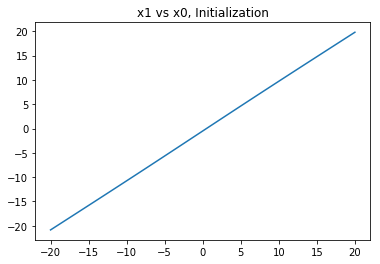

-----Step: 1000
--------Train Cost: 1.2237577438354492 Train Cost Stage1: 0.3565627336502075 Train Cost Stage2: 0.8671949505805969 
--------Test Cost: 0.7549981989545062 Test Cost_Stage1: 0.3034291868588182, Test_Cost_Stage2: 0.4515690070023167
--------14.951056957244873 seconds ---


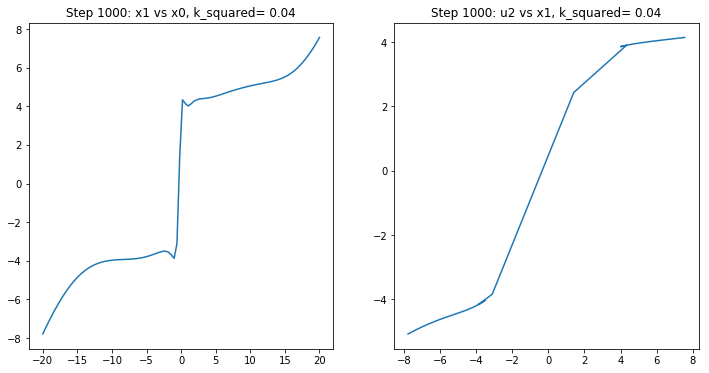

-----Step: 2000
--------Train Cost: 0.4100329279899597 Train Cost Stage1: 0.3206956684589386 Train Cost Stage2: 0.08933727443218231 
--------Test Cost: 0.4951037337272759 Test Cost_Stage1: 0.31536007881395073, Test_Cost_Stage2: 0.1797436523036746
--------14.39982008934021 seconds ---


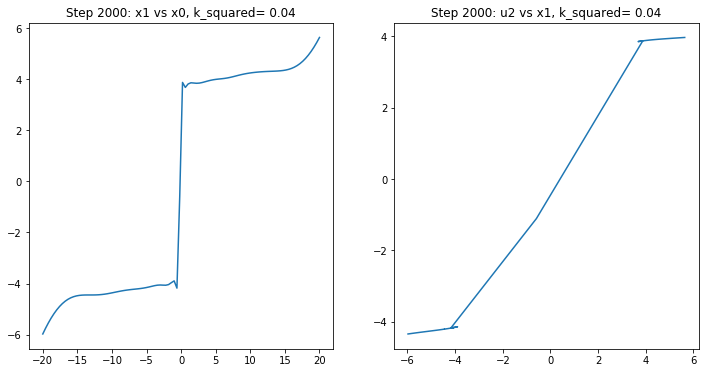

-----Step: 3000
--------Train Cost: 0.40252193808555603 Train Cost Stage1: 0.33950021862983704 Train Cost Stage2: 0.06302172690629959 
--------Test Cost: 0.3897943675556233 Test Cost_Stage1: 0.32375181948236187, Test_Cost_Stage2: 0.06604254579196236
--------14.637802839279175 seconds ---


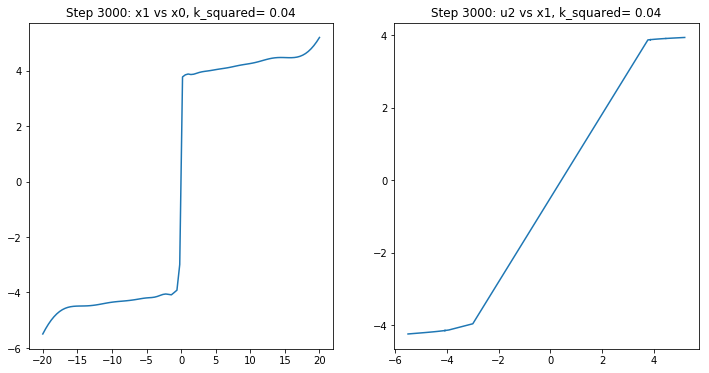

-----Step: 4000
--------Train Cost: 0.41719603538513184 Train Cost Stage1: 0.3393875062465668 Train Cost Stage2: 0.07780852168798447 
--------Test Cost: 0.418828374379135 Test Cost_Stage1: 0.33266069545406424, Test_Cost_Stage2: 0.08616767835309846
--------14.470163583755493 seconds ---


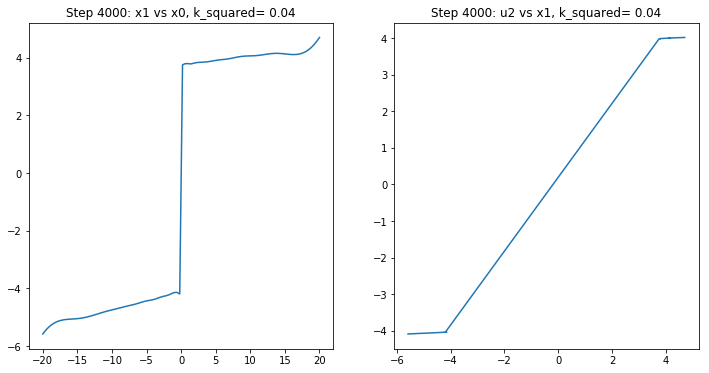

-----Step: 5000
--------Train Cost: 0.37268808484077454 Train Cost Stage1: 0.323610782623291 Train Cost Stage2: 0.04907730221748352 
--------Test Cost: 0.36469778866168684 Test Cost_Stage1: 0.3369258328200861, Test_Cost_Stage2: 0.027771953985581518
--------14.280316829681396 seconds ---


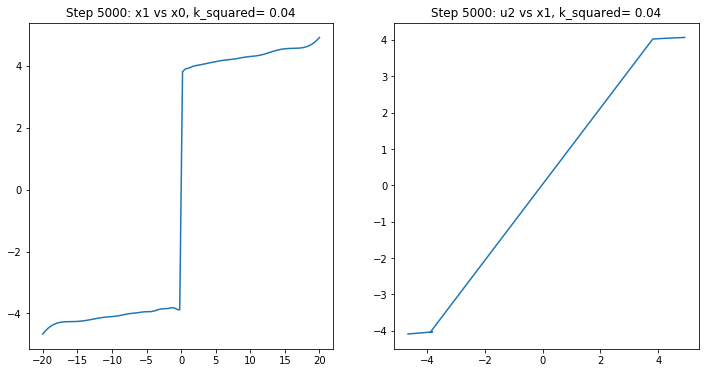

-----Step: 6000
--------Train Cost: 0.38060811161994934 Train Cost Stage1: 0.3261955678462982 Train Cost Stage2: 0.05441254749894142 
--------Test Cost: 0.37665833007039395 Test Cost_Stage1: 0.33633038713631713, Test_Cost_Stage2: 0.040327942233072164
--------14.583956241607666 seconds ---


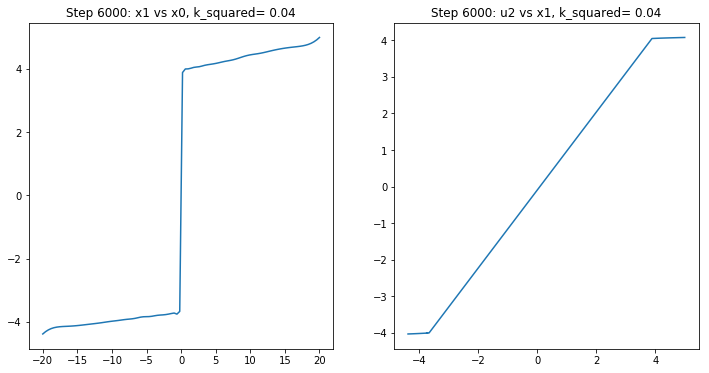

-----Step: 7000
--------Train Cost: 0.40959158539772034 Train Cost Stage1: 0.3437952697277069 Train Cost Stage2: 0.06579630821943283 
--------Test Cost: 0.3858583072577575 Test Cost_Stage1: 0.336787334601011, Test_Cost_Stage2: 0.04907096527639228
--------14.674546957015991 seconds ---


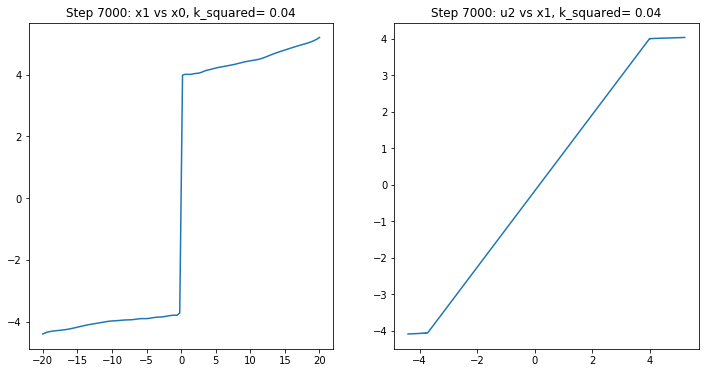

-----Step: 8000
--------Train Cost: 0.3937550187110901 Train Cost Stage1: 0.33009248971939087 Train Cost Stage2: 0.06366252154111862 
--------Test Cost: 0.3767562224082875 Test Cost_Stage1: 0.334986596067296, Test_Cost_Stage2: 0.04176962303961765
--------14.597989320755005 seconds ---


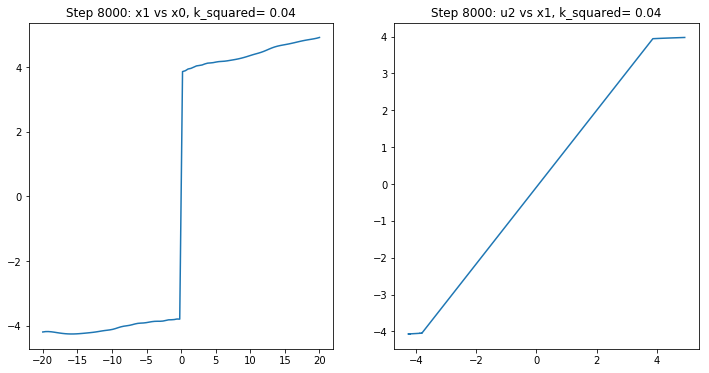

-----Step: 9000
--------Train Cost: 0.39367225766181946 Train Cost Stage1: 0.3442080318927765 Train Cost Stage2: 0.049464236944913864 
--------Test Cost: 0.3777724505394743 Test Cost_Stage1: 0.33543156286445297, Test_Cost_Stage2: 0.04234089085759298
--------14.337969303131104 seconds ---


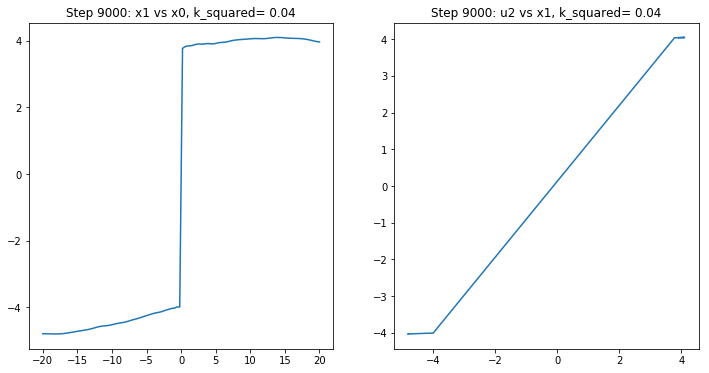

-----Step: 10000
--------Train Cost: 0.3681059181690216 Train Cost Stage1: 0.33683183789253235 Train Cost Stage2: 0.03127409145236015 
--------Test Cost: 0.35809310277377193 Test Cost_Stage1: 0.33741031814494343, Test_Cost_Stage2: 0.02068278087636304
--------14.58896255493164 seconds ---


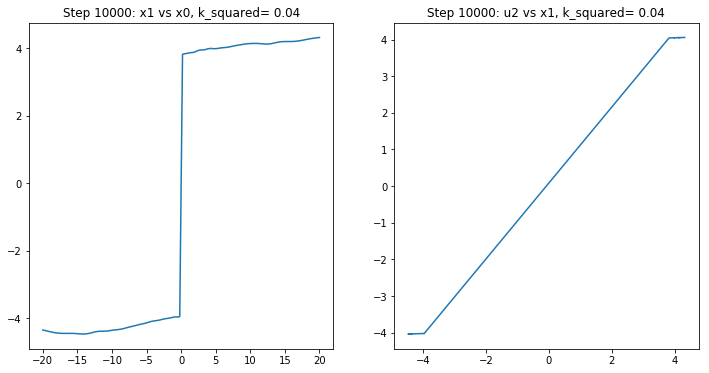

-----Step: 11000
--------Train Cost: 0.47100400924682617 Train Cost Stage1: 0.34505078196525574 Train Cost Stage2: 0.12595322728157043 
--------Test Cost: 0.41171442033603467 Test Cost_Stage1: 0.33198835932500315, Test_Cost_Stage2: 0.0797260567299584
--------14.47700023651123 seconds ---


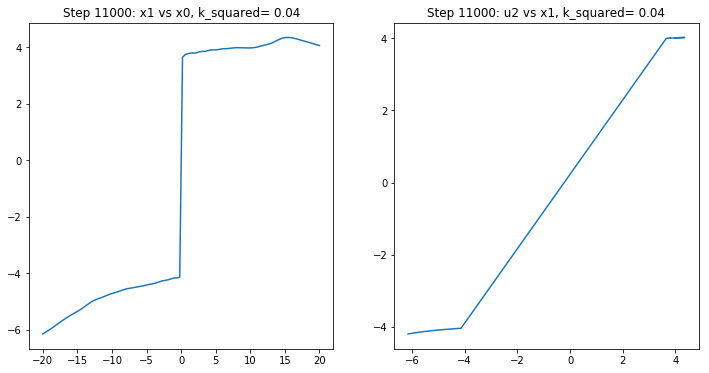

-----Step: 12000
--------Train Cost: 0.34932100772857666 Train Cost Stage1: 0.32818686962127686 Train Cost Stage2: 0.021134141832590103 
--------Test Cost: 0.3501466652247893 Test Cost_Stage1: 0.3343163152500943, Test_Cost_Stage2: 0.01583034378265576
--------14.625469207763672 seconds ---


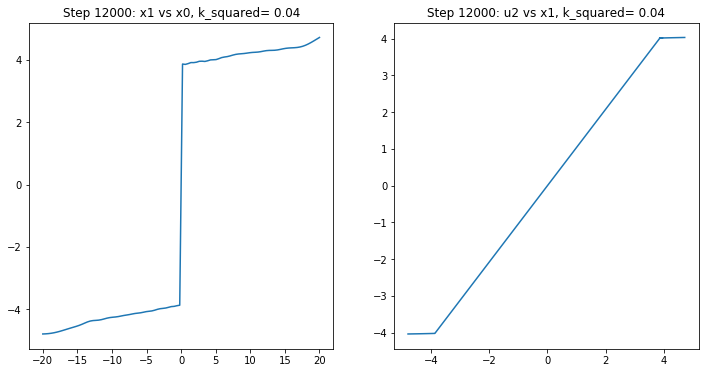

-----Step: 13000
--------Train Cost: 0.3500883877277374 Train Cost Stage1: 0.3217640221118927 Train Cost Stage2: 0.028324365615844727 
--------Test Cost: 0.3594071048911978 Test Cost_Stage1: 0.3303211220201244, Test_Cost_Stage2: 0.029085982123821772
--------14.556383609771729 seconds ---


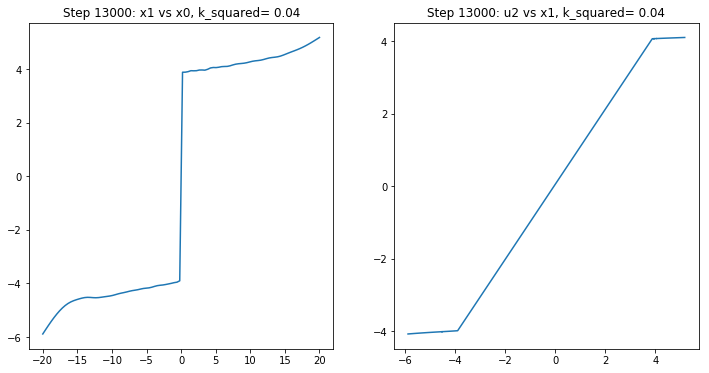

-----Step: 14000
--------Train Cost: 0.3808678388595581 Train Cost Stage1: 0.32752957940101624 Train Cost Stage2: 0.05333825573325157 
--------Test Cost: 0.377728143458593 Test Cost_Stage1: 0.3321586277729273, Test_Cost_Stage2: 0.04556951305979651
--------14.445950508117676 seconds ---


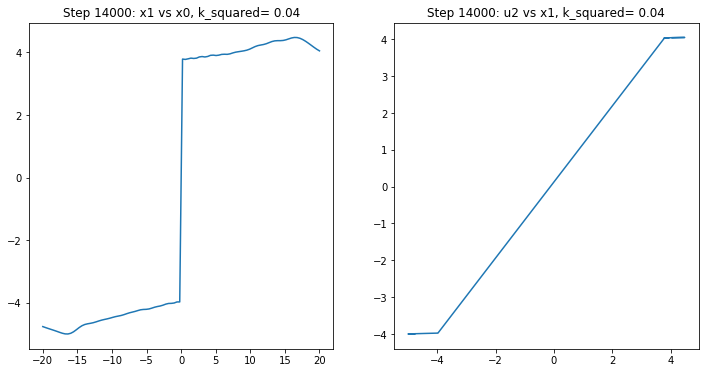

-----Step: 15000
--------Train Cost: 0.3660429120063782 Train Cost Stage1: 0.3438488245010376 Train Cost Stage2: 0.022194083780050278 
--------Test Cost: 0.35130501178292683 Test Cost_Stage1: 0.33501999828693313, Test_Cost_Stage2: 0.016285009892701912
--------13.577442646026611 seconds ---


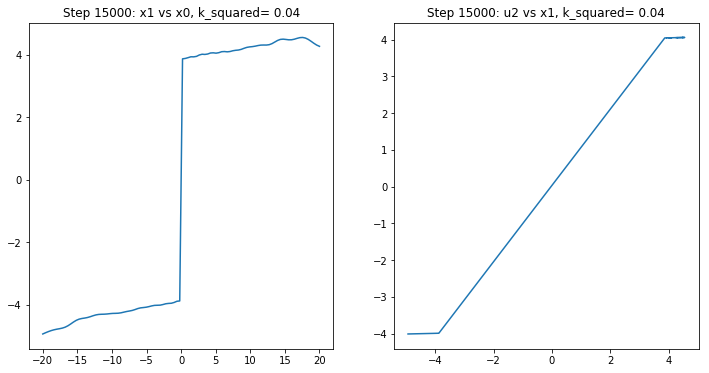

-----Step: 16000
--------Train Cost: 0.437713623046875 Train Cost Stage1: 0.34039705991744995 Train Cost Stage2: 0.09731656312942505 
--------Test Cost: 0.36981726016755917 Test Cost_Stage1: 0.33078968952869575, Test_Cost_Stage2: 0.03902757296330705
--------14.053344964981079 seconds ---


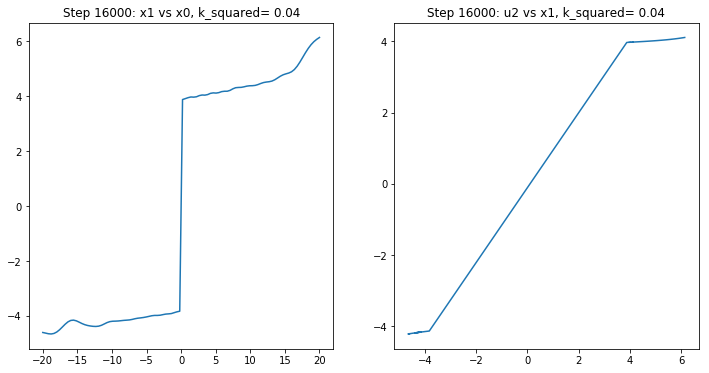

-----Step: 17000
--------Train Cost: 0.3928493559360504 Train Cost Stage1: 0.3451436460018158 Train Cost Stage2: 0.04770570248365402 
--------Test Cost: 0.3772716848104207 Test Cost_Stage1: 0.33598540416283024, Test_Cost_Stage2: 0.04128628441002466
--------13.872777700424194 seconds ---


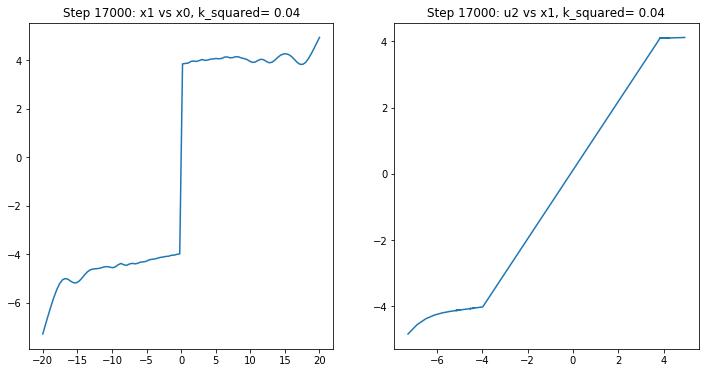

-----Step: 18000
--------Train Cost: 0.36226266622543335 Train Cost Stage1: 0.3456587791442871 Train Cost Stage2: 0.016603896394371986 
--------Test Cost: 0.35040336635382224 Test Cost_Stage1: 0.33441585342667185, Test_Cost_Stage2: 0.015987518926706558
--------13.652575016021729 seconds ---


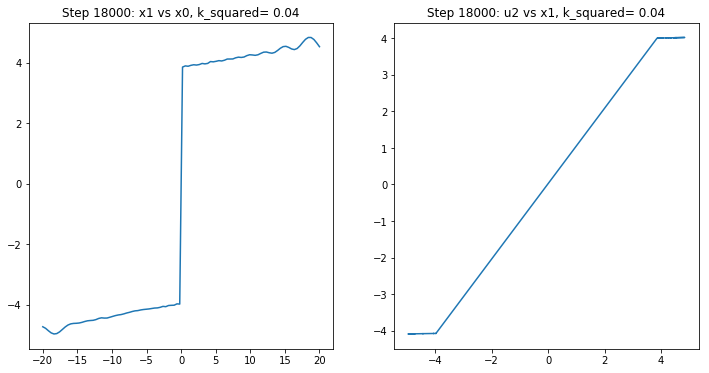

-----Step: 19000
--------Train Cost: 0.37112662196159363 Train Cost Stage1: 0.3302844166755676 Train Cost Stage2: 0.0408422127366066 
--------Test Cost: 0.36489554308586786 Test Cost_Stage1: 0.3361544036461767, Test_Cost_Stage2: 0.028741134195383922
--------14.055719375610352 seconds ---


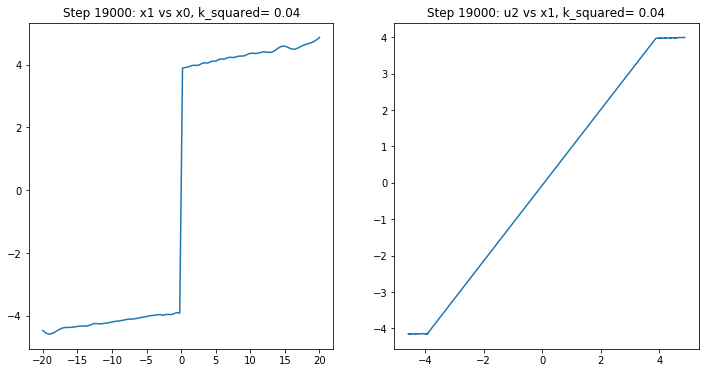

-----Step: 20000
--------Train Cost: 0.3603805601596832 Train Cost Stage1: 0.3308497667312622 Train Cost Stage2: 0.02953079156577587 
--------Test Cost: 0.35563444947970474 Test Cost_Stage1: 0.3349058135211537, Test_Cost_Stage2: 0.02072863196159889
--------14.180062294006348 seconds ---


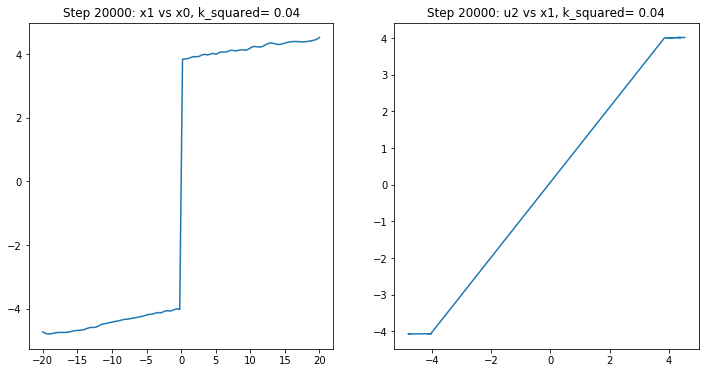

-----Step: 21000
--------Train Cost: 0.3617214560508728 Train Cost Stage1: 0.34342271089553833 Train Cost Stage2: 0.018298758193850517 
--------Test Cost: 0.35238641079397387 Test Cost_Stage1: 0.33409318979484887, Test_Cost_Stage2: 0.01829322081503793
--------13.899821519851685 seconds ---


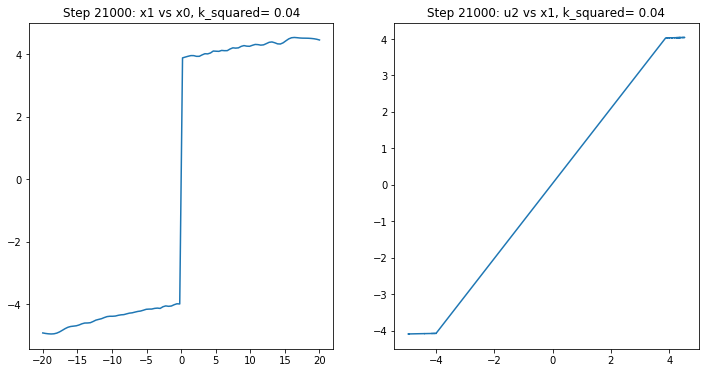

-----Step: 22000
--------Train Cost: 0.35892584919929504 Train Cost Stage1: 0.3370208740234375 Train Cost Stage2: 0.0219049621373415 
--------Test Cost: 0.35110185003846717 Test Cost_Stage1: 0.3351944425544994, Test_Cost_Stage2: 0.015907404232427452
--------13.574344873428345 seconds ---


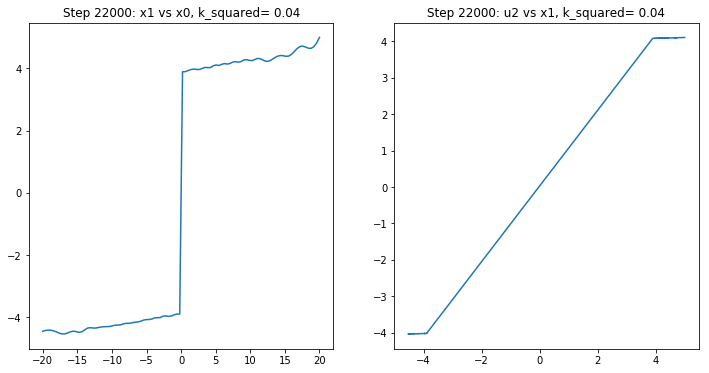

-----Step: 23000
--------Train Cost: 0.3526207208633423 Train Cost Stage1: 0.3325834572315216 Train Cost Stage2: 0.020037276670336723 
--------Test Cost: 0.3502756023448526 Test Cost_Stage1: 0.33612408430880353, Test_Cost_Stage2: 0.014151516545131217
--------14.105563640594482 seconds ---


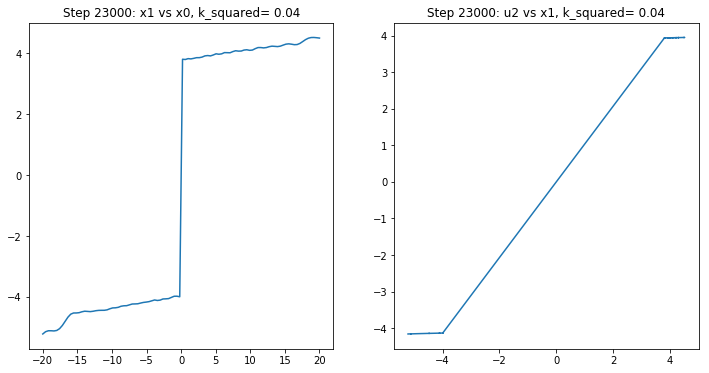

-----Step: 24000
--------Train Cost: 0.3499014675617218 Train Cost Stage1: 0.23011772334575653 Train Cost Stage2: 0.11978373676538467 
--------Test Cost: 0.3346417473400312 Test Cost_Stage1: 0.22610755017358392, Test_Cost_Stage2: 0.10853420215183394
--------14.172834873199463 seconds ---


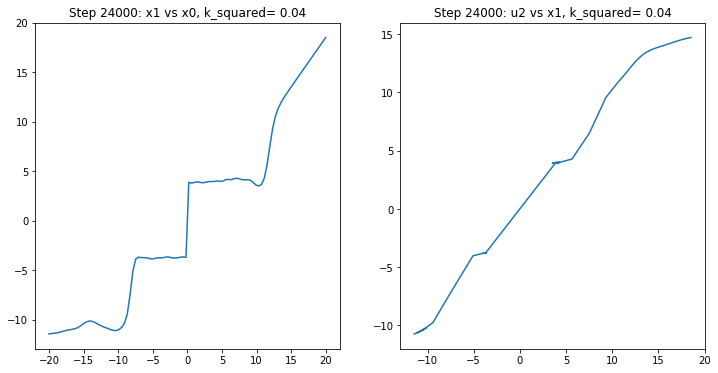

-----Step: 25000
--------Train Cost: 0.5262333154678345 Train Cost Stage1: 0.13902688026428223 Train Cost Stage2: 0.38720640540122986 
--------Test Cost: 0.35575949685900116 Test Cost_Stage1: 0.14525598306125975, Test_Cost_Stage2: 0.21050351152980537
--------14.369725704193115 seconds ---


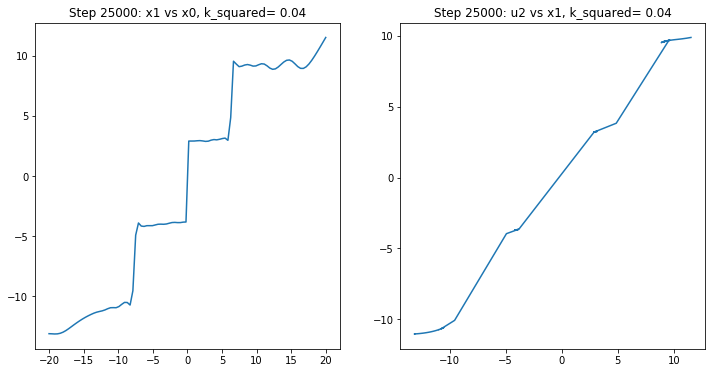

-----Step: 26000
--------Train Cost: 0.2608427405357361 Train Cost Stage1: 0.13306644558906555 Train Cost Stage2: 0.12777629494667053 
--------Test Cost: 0.2882449355735084 Test Cost_Stage1: 0.12967806216200964, Test_Cost_Stage2: 0.15856686420687424
--------14.845577478408813 seconds ---


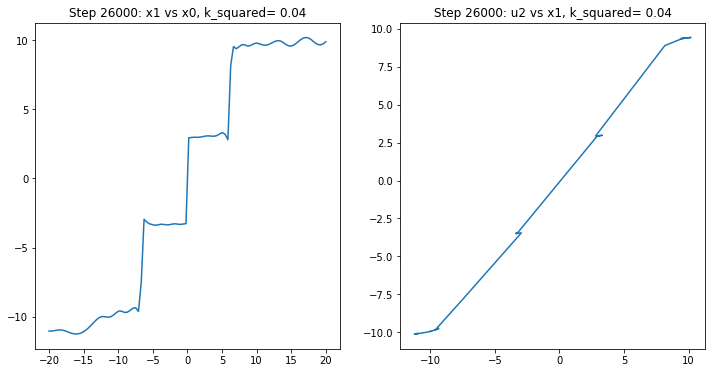

-----Step: 27000
--------Train Cost: 0.260730117559433 Train Cost Stage1: 0.13529039919376373 Train Cost Stage2: 0.12543971836566925 
--------Test Cost: 0.2578163868347257 Test Cost_Stage1: 0.1367495836617673, Test_Cost_Stage2: 0.12106679882768127
--------14.666568994522095 seconds ---


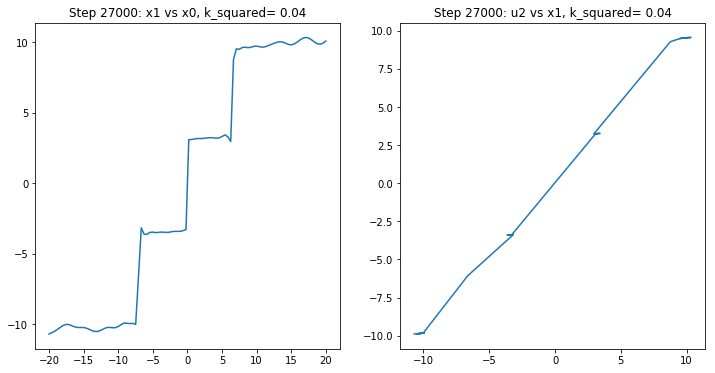

-----Step: 28000
--------Train Cost: 0.2558433413505554 Train Cost Stage1: 0.1458841860294342 Train Cost Stage2: 0.10995914041996002 
--------Test Cost: 0.24374801199103974 Test Cost_Stage1: 0.14884729447082068, Test_Cost_Stage2: 0.09490072111558581
--------14.606629610061646 seconds ---


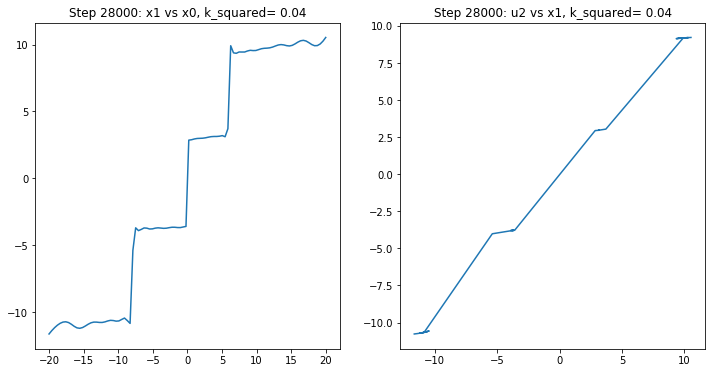

-----Step: 29000
--------Train Cost: 0.23948395252227783 Train Cost Stage1: 0.13121554255485535 Train Cost Stage2: 0.10826841741800308 
--------Test Cost: 0.22667181741313328 Test Cost_Stage1: 0.13247898425454244, Test_Cost_Stage2: 0.0941928310053713
--------14.42118501663208 seconds ---


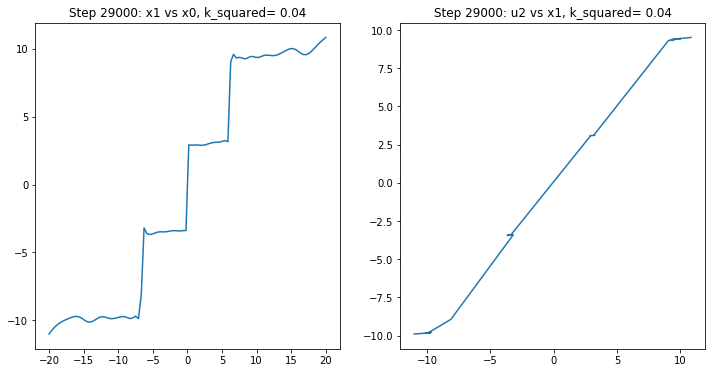

-----Step: 30000
--------Train Cost: 0.2489463984966278 Train Cost Stage1: 0.14781813323497772 Train Cost Stage2: 0.10112825781106949 
--------Test Cost: 0.24508272551171267 Test Cost_Stage1: 0.14855839713145585, Test_Cost_Stage2: 0.09652432530931136
--------14.923900127410889 seconds ---


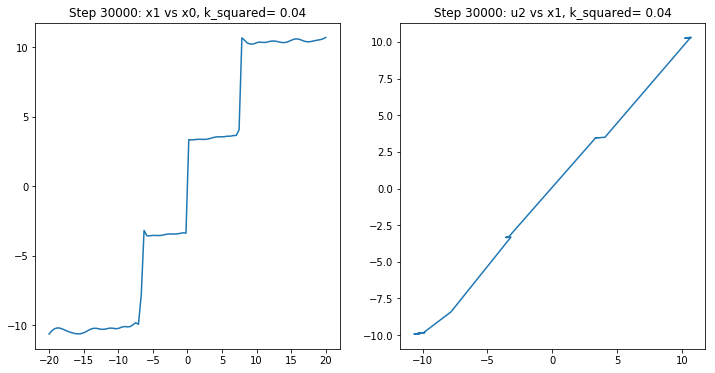

-----Step: 31000
--------Train Cost: 0.26283565163612366 Train Cost Stage1: 0.14135916531085968 Train Cost Stage2: 0.12147647887468338 
--------Test Cost: 0.23232122421722493 Test Cost_Stage1: 0.14340186447443556, Test_Cost_Stage2: 0.08891936102215321
--------15.348411083221436 seconds ---


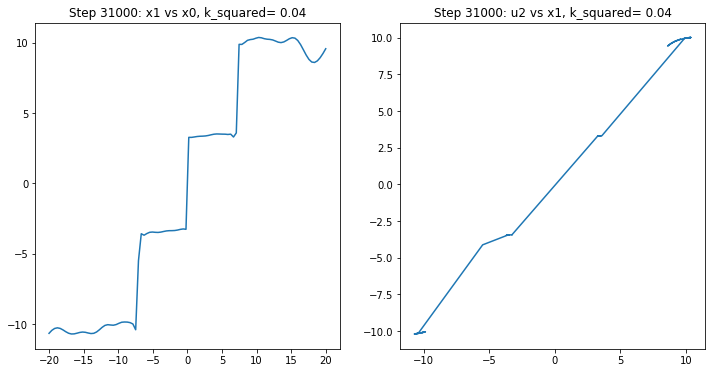

-----Step: 32000
--------Train Cost: 0.23837104439735413 Train Cost Stage1: 0.13980409502983093 Train Cost Stage2: 0.0985669493675232 
--------Test Cost: 0.20110649196554942 Test Cost_Stage1: 0.1418183069477205, Test_Cost_Stage2: 0.059288185326229904
--------14.881263732910156 seconds ---


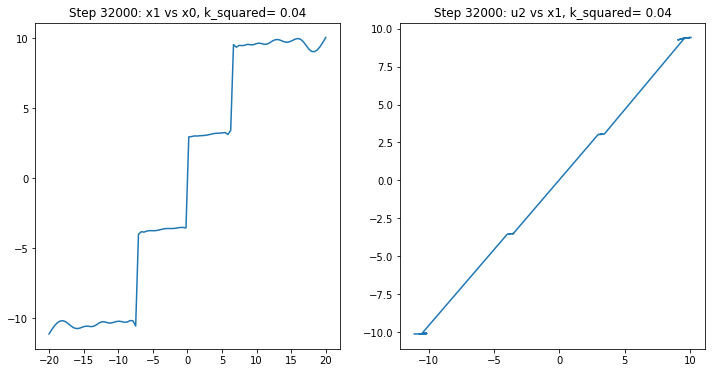

-----Step: 33000
--------Train Cost: 0.24217765033245087 Train Cost Stage1: 0.14251168072223663 Train Cost Stage2: 0.09966596961021423 
--------Test Cost: 0.24822849641665465 Test Cost_Stage1: 0.14067580602530183, Test_Cost_Stage2: 0.10755268553414575
--------15.942089557647705 seconds ---


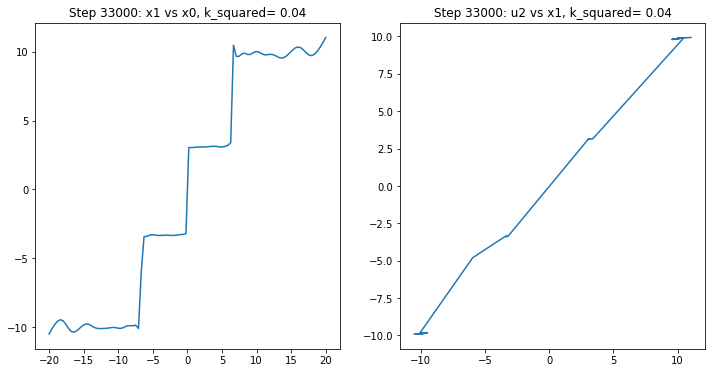

-----Step: 34000
--------Train Cost: 0.26258420944213867 Train Cost Stage1: 0.14245782792568207 Train Cost Stage2: 0.1201263889670372 
--------Test Cost: 0.19318195235343522 Test Cost_Stage1: 0.1426362270167697, Test_Cost_Stage2: 0.05054572130752898
--------15.293418884277344 seconds ---


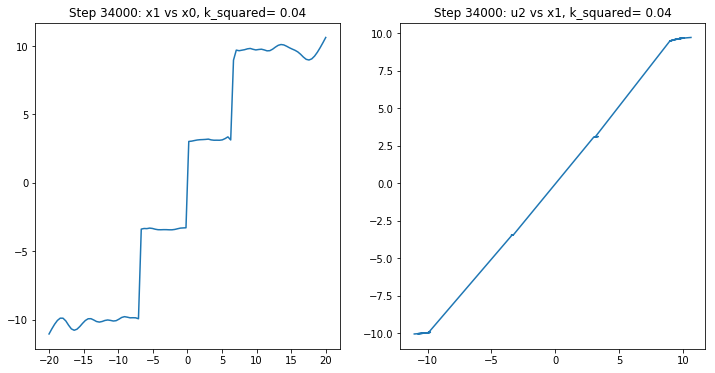

-----Step: 35000
--------Train Cost: 0.24455732107162476 Train Cost Stage1: 0.14032162725925446 Train Cost Stage2: 0.1042356938123703 
--------Test Cost: 0.19962632652215215 Test Cost_Stage1: 0.1468886354510612, Test_Cost_Stage2: 0.05273769835156187
--------14.21567416191101 seconds ---


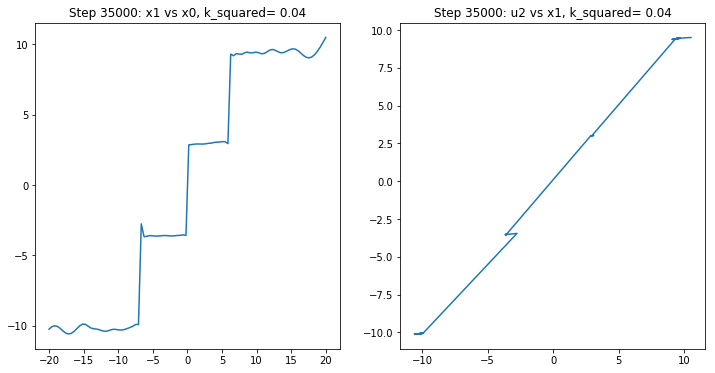

-----Step: 36000
--------Train Cost: 0.2335801124572754 Train Cost Stage1: 0.15287654101848602 Train Cost Stage2: 0.08070357888936996 
--------Test Cost: 0.2532745808745644 Test Cost_Stage1: 0.1477662931062871, Test_Cost_Stage2: 0.1055082907767112
--------14.665822744369507 seconds ---


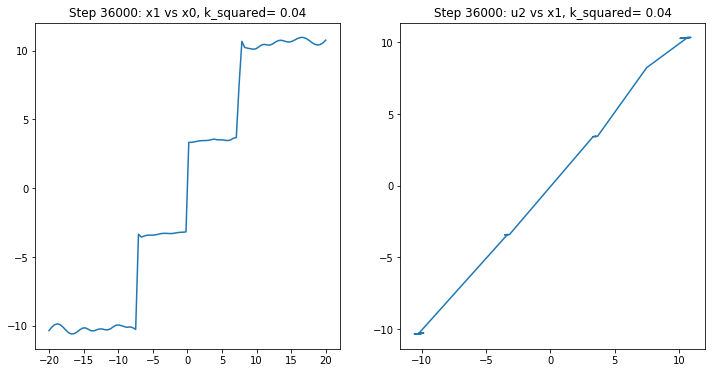

-----Step: 37000
--------Train Cost: 0.2660168409347534 Train Cost Stage1: 0.1599302440881729 Train Cost Stage2: 0.1060865968465805 
--------Test Cost: 0.2997890698070409 Test Cost_Stage1: 0.16253137109518334, Test_Cost_Stage2: 0.13725769342181354
--------14.581371307373047 seconds ---


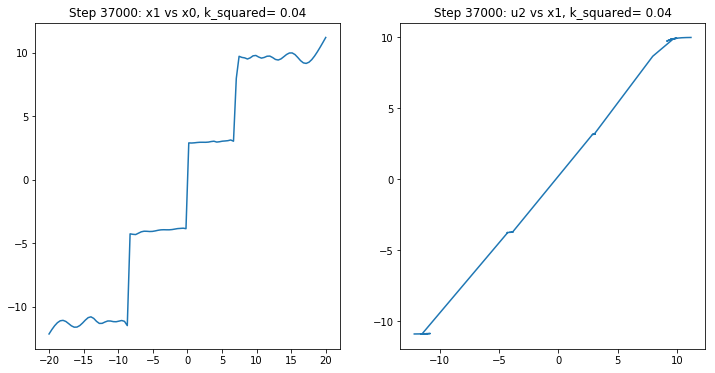

-----Step: 38000
--------Train Cost: 0.22390741109848022 Train Cost Stage1: 0.13786602020263672 Train Cost Stage2: 0.08604138344526291 
--------Test Cost: 0.2036002591031586 Test Cost_Stage1: 0.1420646644490403, Test_Cost_Stage2: 0.06153559683152798
--------14.890493869781494 seconds ---


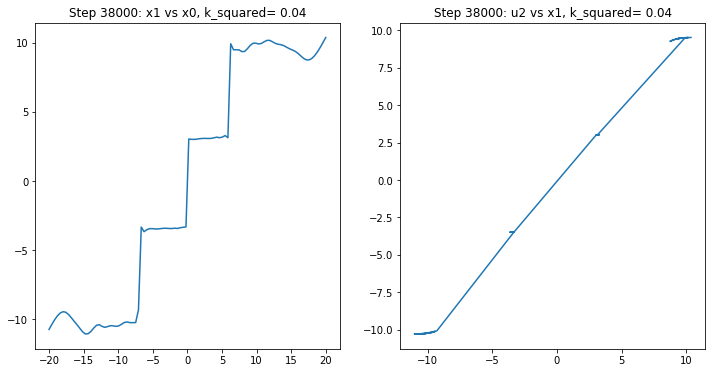

-----Step: 39000
--------Train Cost: 0.23522186279296875 Train Cost Stage1: 0.13901273906230927 Train Cost Stage2: 0.09620913118124008 
--------Test Cost: 0.26000255657904264 Test Cost_Stage1: 0.13523833163430948, Test_Cost_Stage2: 0.12476421987328859
--------15.30759072303772 seconds ---


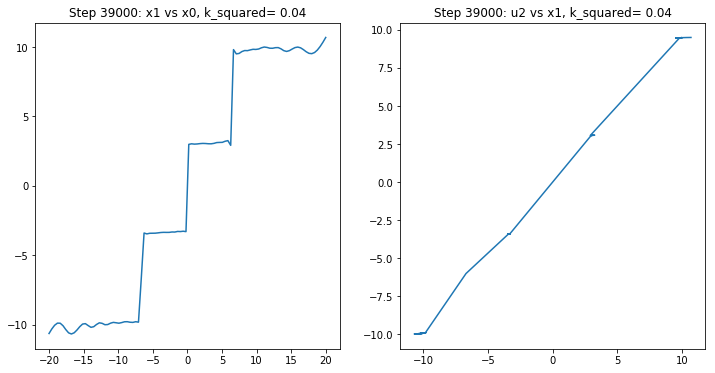

-----Step: 40000
--------Train Cost: 0.2302677035331726 Train Cost Stage1: 0.14792339503765106 Train Cost Stage2: 0.08234430104494095 
--------Test Cost: 0.18586283901511605 Test Cost_Stage1: 0.15199161947811382, Test_Cost_Stage2: 0.03387121917795525
--------14.673428535461426 seconds ---


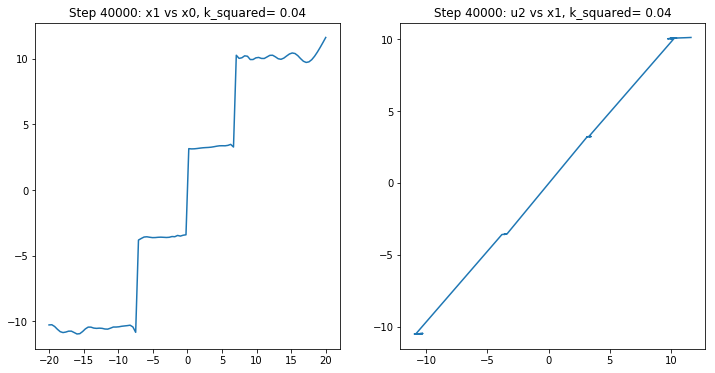

-----Step: 41000
--------Train Cost: 0.23361989855766296 Train Cost Stage1: 0.1462073177099228 Train Cost Stage2: 0.08741258084774017 
--------Test Cost: 0.24424309224520158 Test Cost_Stage1: 0.14549788836117528, Test_Cost_Stage2: 0.09874519955873787
--------14.6209397315979 seconds ---


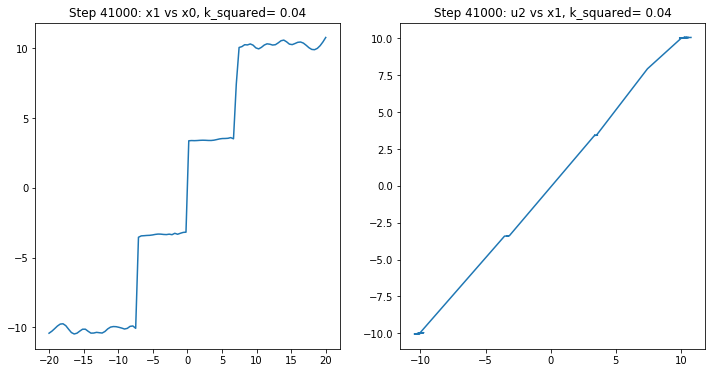

-----Step: 42000
--------Train Cost: 0.26152151823043823 Train Cost Stage1: 0.1432460993528366 Train Cost Stage2: 0.11827541142702103 
--------Test Cost: 0.2461254546601985 Test Cost_Stage1: 0.15245897570639164, Test_Cost_Stage2: 0.0936664706938506
--------14.995669841766357 seconds ---


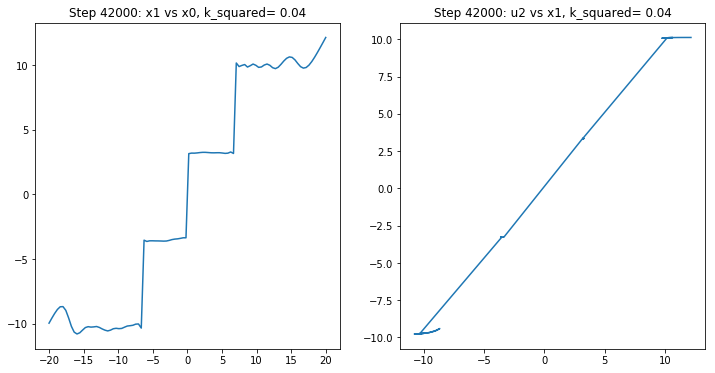

-----Step: 43000
--------Train Cost: 0.22979894280433655 Train Cost Stage1: 0.15462814271450043 Train Cost Stage2: 0.07517080008983612 
--------Test Cost: 0.22629489280630669 Test Cost_Stage1: 0.15586799755905462, Test_Cost_Stage2: 0.07042689246265785
--------14.772560834884644 seconds ---


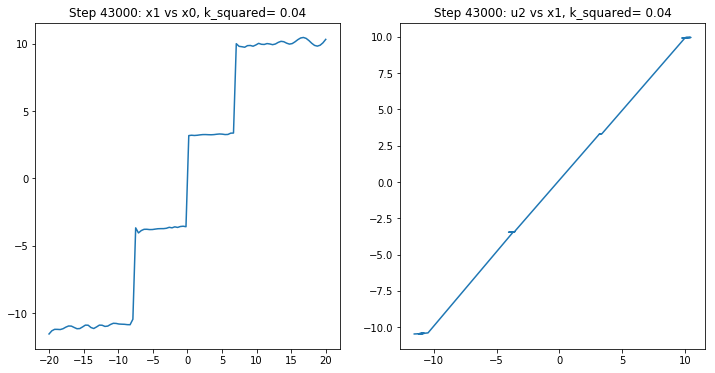

-----Step: 44000
--------Train Cost: 0.24254821240901947 Train Cost Stage1: 0.14411526918411255 Train Cost Stage2: 0.09843294322490692 
--------Test Cost: 0.1842940277716347 Test Cost_Stage1: 0.14312520609995777, Test_Cost_Stage2: 0.04116882010697061
--------14.693320512771606 seconds ---


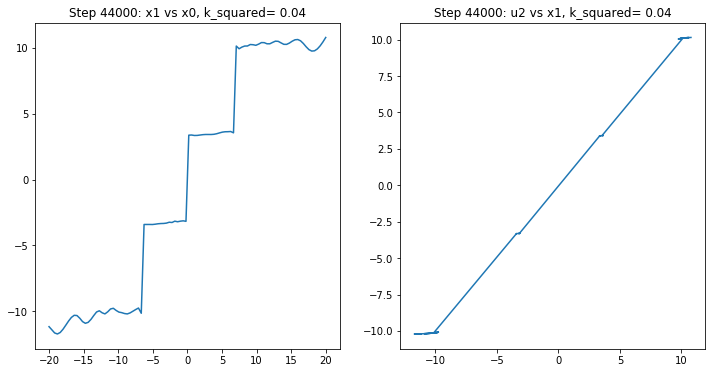

-----Step: 45000
--------Train Cost: 0.21210862696170807 Train Cost Stage1: 0.14164939522743225 Train Cost Stage2: 0.07045923173427582 
--------Test Cost: 0.24708810202427114 Test Cost_Stage1: 0.13475108241550993, Test_Cost_Stage2: 0.11233701605876645
--------14.985162258148193 seconds ---


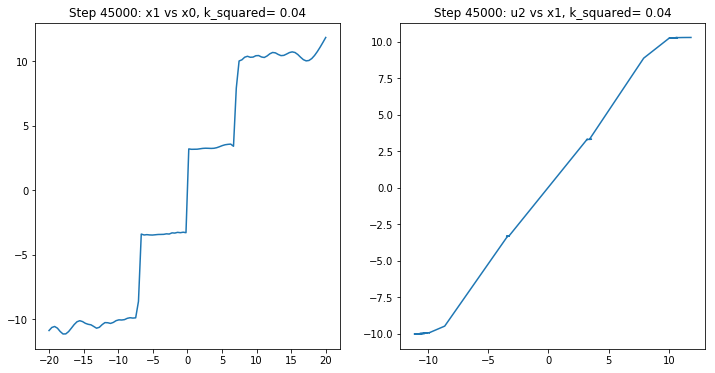

-----Step: 46000
--------Train Cost: 0.2333061844110489 Train Cost Stage1: 0.15622146427631378 Train Cost Stage2: 0.07708472013473511 
--------Test Cost: 0.21087858517459207 Test Cost_Stage1: 0.1592395625877074, Test_Cost_Stage2: 0.05163902327288234
--------14.647120714187622 seconds ---


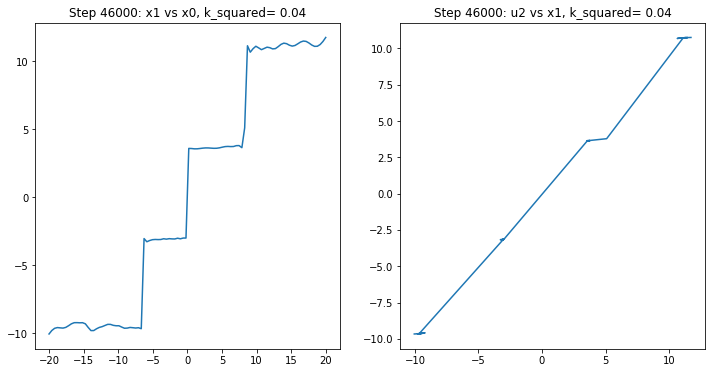

-----Step: 47000
--------Train Cost: 0.2252522110939026 Train Cost Stage1: 0.145987868309021 Train Cost Stage2: 0.07926435023546219 
--------Test Cost: 0.19905430455324594 Test Cost_Stage1: 0.1486010985608898, Test_Cost_Stage2: 0.05045320656529369
--------15.02823519706726 seconds ---


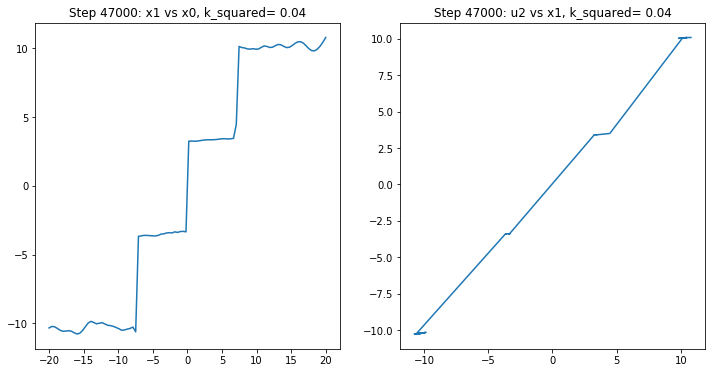

-----Step: 48000
--------Train Cost: 0.2232285737991333 Train Cost Stage1: 0.14536726474761963 Train Cost Stage2: 0.07786130160093307 
--------Test Cost: 0.18975369754619914 Test Cost_Stage1: 0.14687480323476484, Test_Cost_Stage2: 0.042878898395975015
--------15.150722980499268 seconds ---


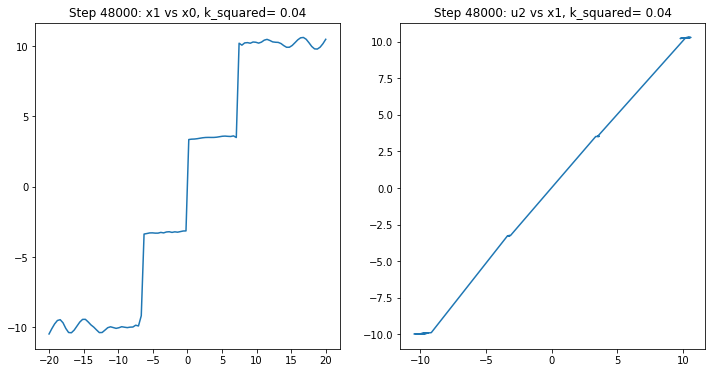

-----Step: 49000
--------Train Cost: 0.22060614824295044 Train Cost Stage1: 0.1416420191526413 Train Cost Stage2: 0.07896413654088974 
--------Test Cost: 0.1944689349948424 Test Cost_Stage1: 0.14046478771698293, Test_Cost_Stage2: 0.05400414387536282
--------14.339733123779297 seconds ---


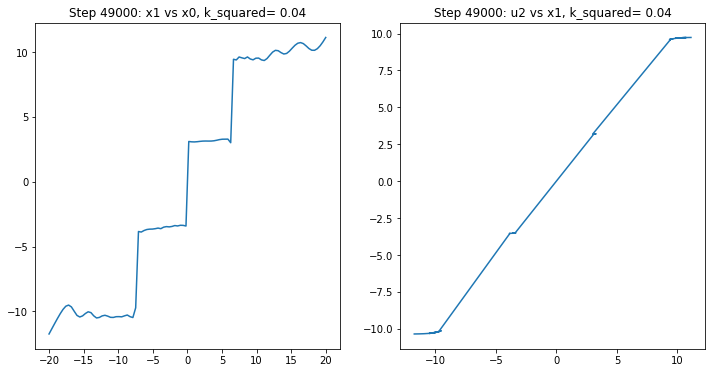

-----Step: 50000
--------Train Cost: 0.22582289576530457 Train Cost Stage1: 0.1708407998085022 Train Cost Stage2: 0.05498209223151207 
--------Test Cost: 0.20135309251410438 Test Cost_Stage1: 0.17366685462535808, Test_Cost_Stage2: 0.02768623580978082
--------15.129832744598389 seconds ---


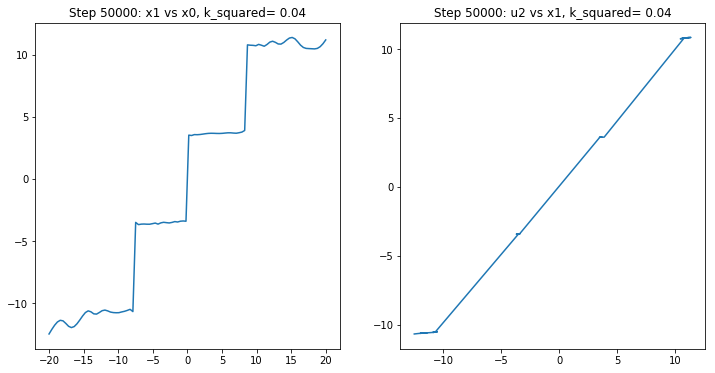

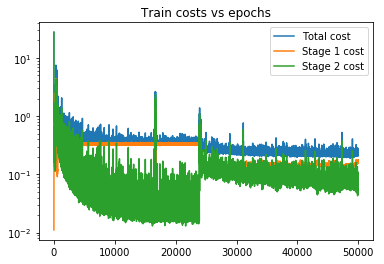

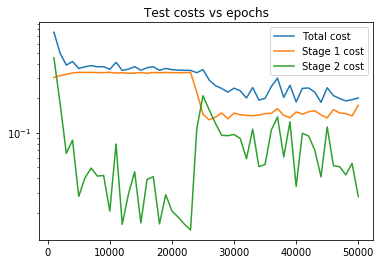

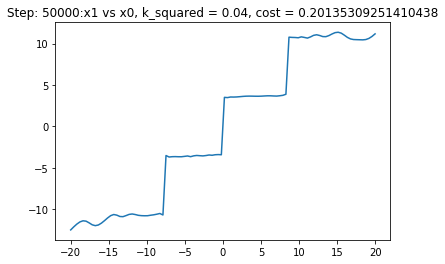

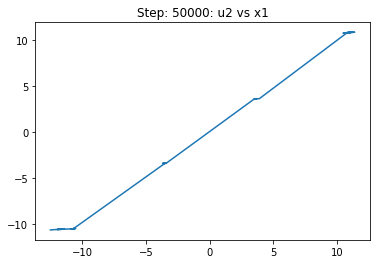

ls1_hu:150,sigmoid,nl:1,ls2_hu:1,identity,nl:1,ls3_hu:30,sigmoid,nl:1,ls4_hu:1,identity,nl:1,k_squared:0.15,lr:0.2,1,me:50000,bsz:10000,std_x0:5.0,std_z:1.0,Adam,krf:0.5
Using glorot normal initializer for encoder/layer1/kernel:0
Using zeros initializer for encoder/layer1/bias:0
Using glorot normal initializer for encoder/layer2/kernel:0
Using zeros initializer for encoder/layer2/bias:0
Using glorot normal initializer for decoder/layer3/kernel:0
Using zeros initializer for decoder/layer3/bias:0
Using glorot normal initializer for decoder/layer4/kernel:0
Using zeros initializer for decoder/layer4/bias:0
Training...


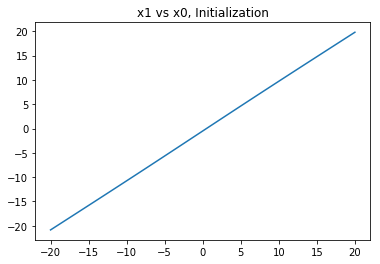

-----Step: 1000
--------Train Cost: 1.4994064569473267 Train Cost Stage1: 0.3475252389907837 Train Cost Stage2: 1.151881217956543 
--------Test Cost: 1.3699630405248215 Test Cost_Stage1: 0.21320525852410563, Test_Cost_Stage2: 1.1567577904998805
--------15.129904747009277 seconds ---


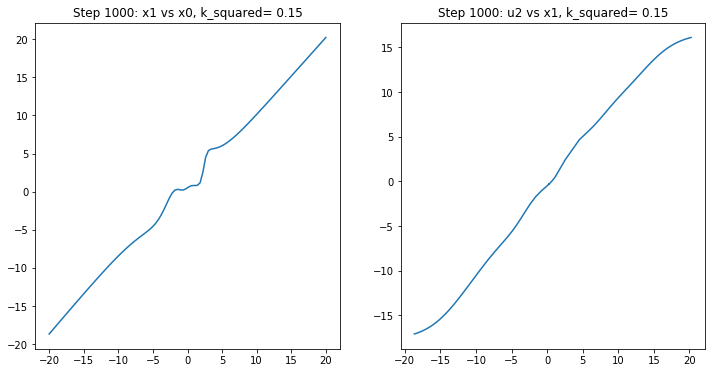

-----Step: 2000
--------Train Cost: 0.6789855360984802 Train Cost Stage1: 0.23651443421840668 Train Cost Stage2: 0.44247108697891235 
--------Test Cost: 0.7049749952579626 Test Cost_Stage1: 0.265014673014016, Test_Cost_Stage2: 0.4399603375499951
--------15.261391878128052 seconds ---


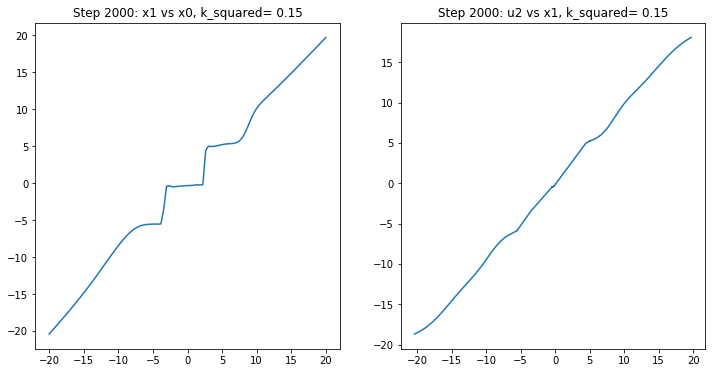

-----Step: 3000
--------Train Cost: 0.5950883030891418 Train Cost Stage1: 0.30704861879348755 Train Cost Stage2: 0.2880396842956543 
--------Test Cost: 0.6182230572426606 Test Cost_Stage1: 0.3042565997254614, Test_Cost_Stage2: 0.31396646594792726
--------15.679481267929077 seconds ---


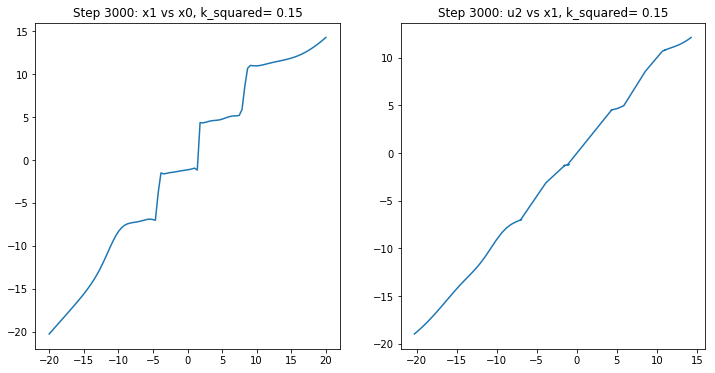

-----Step: 4000
--------Train Cost: 0.6022472381591797 Train Cost Stage1: 0.2954915165901184 Train Cost Stage2: 0.30675575137138367 
--------Test Cost: 0.6008887458369294 Test Cost_Stage1: 0.28533302884253214, Test_Cost_Stage2: 0.3155557258101149
--------14.663630485534668 seconds ---


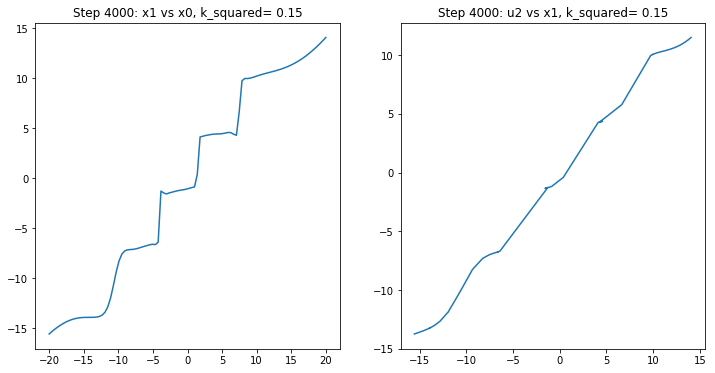

-----Step: 5000
--------Train Cost: 0.5667334794998169 Train Cost Stage1: 0.2960929572582245 Train Cost Stage2: 0.27064049243927 
--------Test Cost: 0.5183809327528316 Test Cost_Stage1: 0.30312497384898984, Test_Cost_Stage2: 0.21525596214819084
--------15.204769372940063 seconds ---


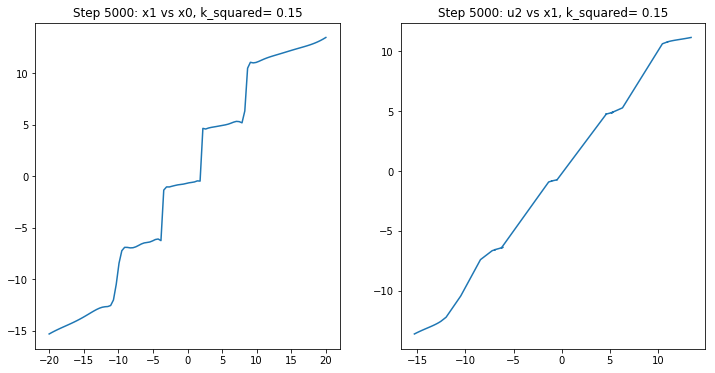

-----Step: 6000
--------Train Cost: 0.5536409616470337 Train Cost Stage1: 0.30348408222198486 Train Cost Stage2: 0.25015687942504883 
--------Test Cost: 0.5293139866970084 Test Cost_Stage1: 0.32377296196055627, Test_Cost_Stage2: 0.20554102921613626
--------15.863844394683838 seconds ---


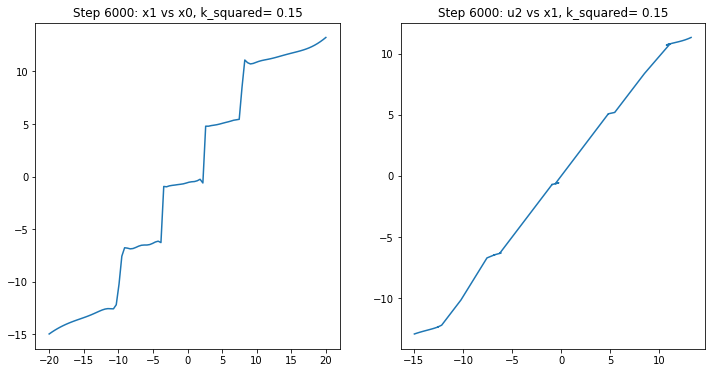

-----Step: 7000
--------Train Cost: 0.5862436890602112 Train Cost Stage1: 0.30358749628067017 Train Cost Stage2: 0.282656192779541 
--------Test Cost: 0.5639499836759345 Test Cost_Stage1: 0.31467610386891026, Test_Cost_Stage2: 0.24927389477867293
--------14.808683633804321 seconds ---


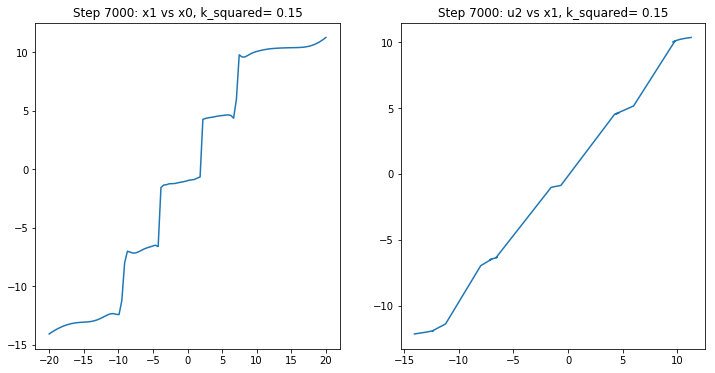

-----Step: 8000
--------Train Cost: 0.5610580444335938 Train Cost Stage1: 0.30973875522613525 Train Cost Stage2: 0.2513192892074585 
--------Test Cost: 0.5823732677598074 Test Cost_Stage1: 0.2988055647384284, Test_Cost_Stage2: 0.28356770532976106
--------15.187321662902832 seconds ---


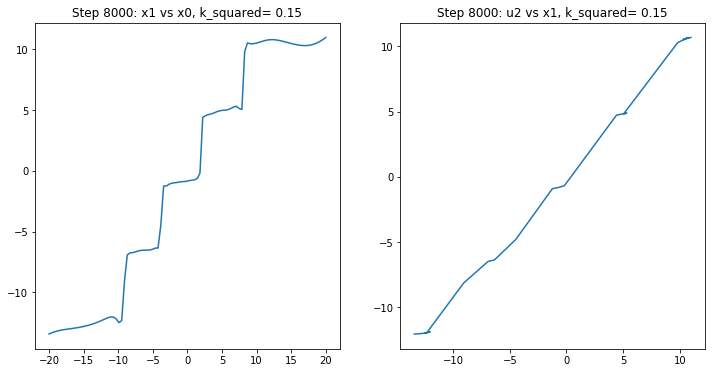

-----Step: 9000
--------Train Cost: 0.517841637134552 Train Cost Stage1: 0.3140873610973358 Train Cost Stage2: 0.20375429093837738 
--------Test Cost: 0.5379629239738538 Test Cost_Stage1: 0.3168836909365856, Test_Cost_Stage2: 0.22107922873093858
--------14.914321660995483 seconds ---


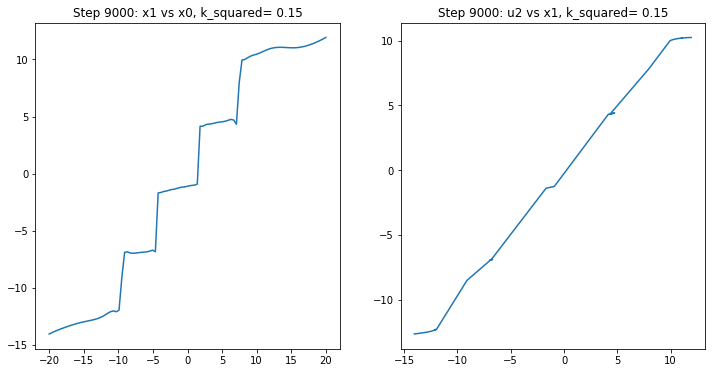

-----Step: 10000
--------Train Cost: 0.5733305215835571 Train Cost Stage1: 0.30876126885414124 Train Cost Stage2: 0.2645692527294159 
--------Test Cost: 0.5012537669264759 Test Cost_Stage1: 0.32724511398854106, Test_Cost_Stage2: 0.17400864524799087
--------14.727098226547241 seconds ---


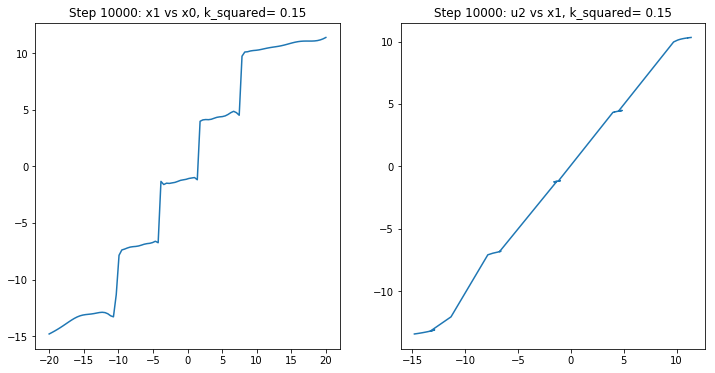

-----Step: 11000
--------Train Cost: 0.5388534069061279 Train Cost Stage1: 0.31405356526374817 Train Cost Stage2: 0.22479982674121857 
--------Test Cost: 0.5026496944050491 Test Cost_Stage1: 0.3229558515004667, Test_Cost_Stage2: 0.17969385006641003
--------14.498575210571289 seconds ---


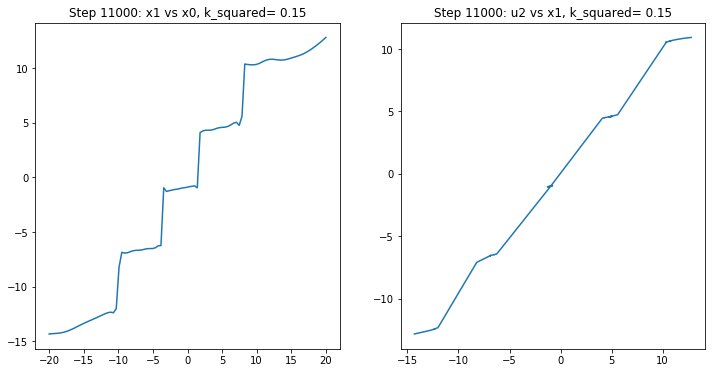

-----Step: 12000
--------Train Cost: 0.557216227054596 Train Cost Stage1: 0.321610689163208 Train Cost Stage2: 0.23560552299022675 
--------Test Cost: 0.6457118220515422 Test Cost_Stage1: 0.28734495648995045, Test_Cost_Stage2: 0.35836685482880404
--------14.992825984954834 seconds ---


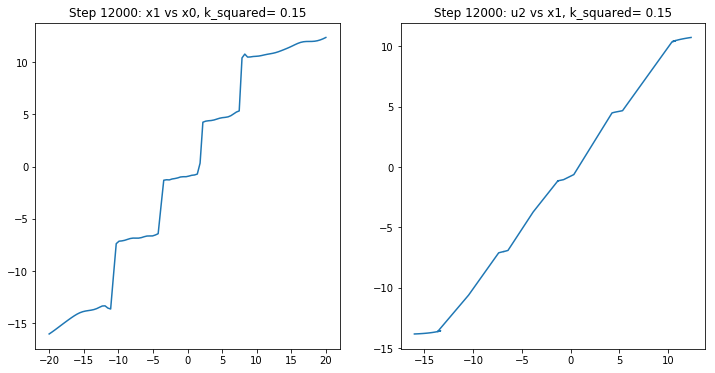

-----Step: 13000
--------Train Cost: 0.5589630007743835 Train Cost Stage1: 0.32023295760154724 Train Cost Stage2: 0.2387300282716751 
--------Test Cost: 0.503512863174103 Test Cost_Stage1: 0.3277711941427753, Test_Cost_Stage2: 0.1757416631036439
--------13.444416046142578 seconds ---


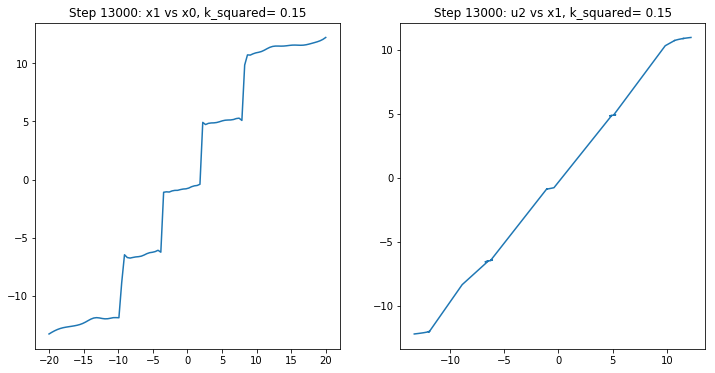

-----Step: 14000
--------Train Cost: 0.5407150983810425 Train Cost Stage1: 0.3327575922012329 Train Cost Stage2: 0.20795752108097076 
--------Test Cost: 0.5070821790727782 Test Cost_Stage1: 0.3266271800381532, Test_Cost_Stage2: 0.18045500121295552
--------14.92188549041748 seconds ---


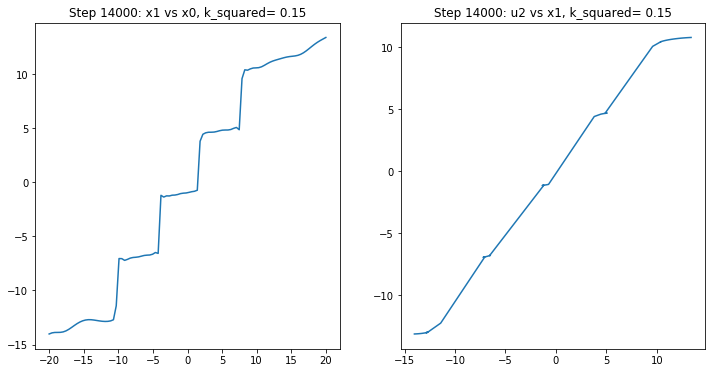

-----Step: 15000
--------Train Cost: 0.5474469661712646 Train Cost Stage1: 0.33691006898880005 Train Cost Stage2: 0.2105368673801422 
--------Test Cost: 0.4993324611689252 Test Cost_Stage1: 0.33840400247868374, Test_Cost_Stage2: 0.16092847095689639
--------14.394511938095093 seconds ---


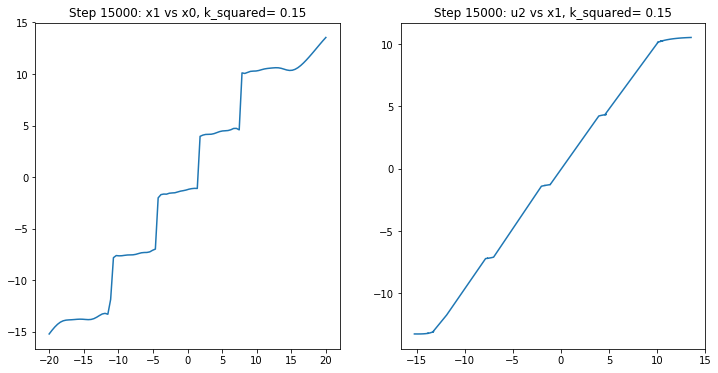

-----Step: 16000
--------Train Cost: 0.5261520147323608 Train Cost Stage1: 0.31648018956184387 Train Cost Stage2: 0.20967182517051697 
--------Test Cost: 0.508497134145302 Test Cost_Stage1: 0.3102496804310424, Test_Cost_Stage2: 0.19824744867015784
--------14.436575651168823 seconds ---


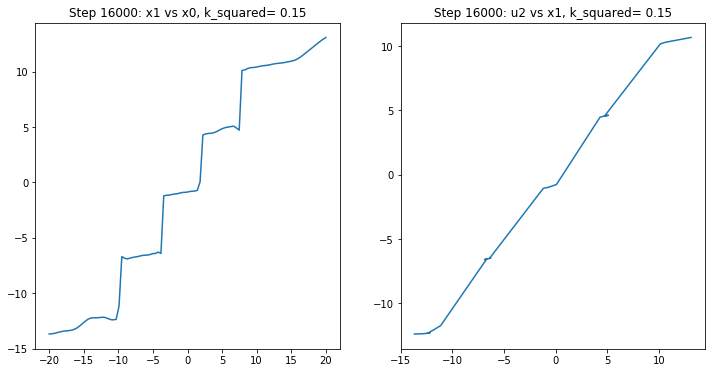

-----Step: 17000
--------Train Cost: 0.5324584245681763 Train Cost Stage1: 0.3180234432220459 Train Cost Stage2: 0.21443496644496918 
--------Test Cost: 0.5075067662916506 Test Cost_Stage1: 0.32382712287693927, Test_Cost_Stage2: 0.18367964061162392
--------14.115293979644775 seconds ---


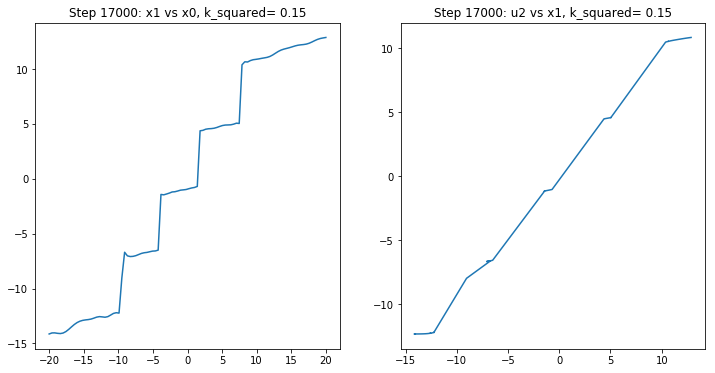

-----Step: 18000
--------Train Cost: 0.5380240678787231 Train Cost Stage1: 0.31637659668922424 Train Cost Stage2: 0.2216474562883377 
--------Test Cost: 0.4985498301725078 Test Cost_Stage1: 0.33271357707257027, Test_Cost_Stage2: 0.16583625148817635
--------14.314119338989258 seconds ---


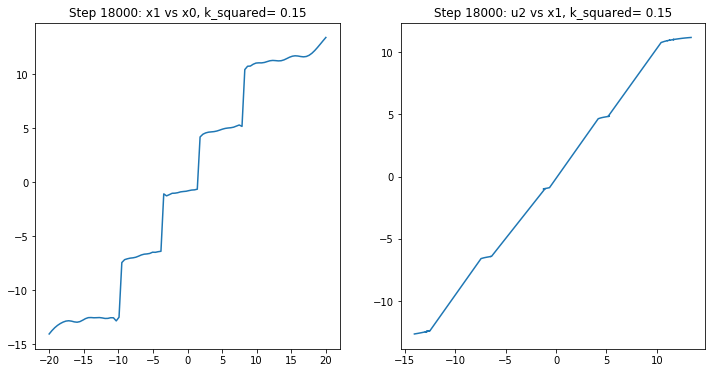

-----Step: 19000
--------Train Cost: 0.5128660202026367 Train Cost Stage1: 0.324886292219162 Train Cost Stage2: 0.18797975778579712 
--------Test Cost: 0.5373294665211756 Test Cost_Stage1: 0.3339036384307709, Test_Cost_Stage2: 0.20342584037984748
--------14.443314790725708 seconds ---


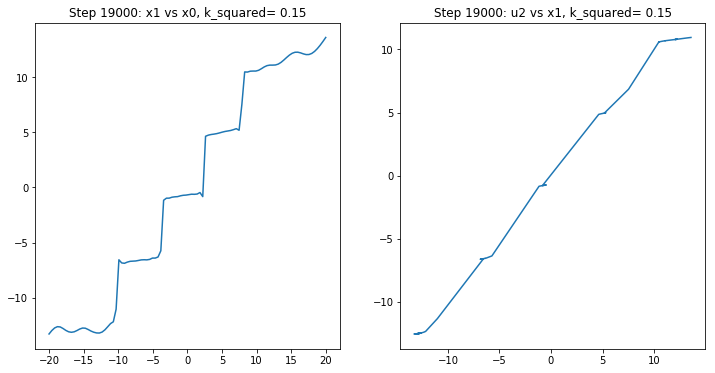

-----Step: 20000
--------Train Cost: 0.5232954025268555 Train Cost Stage1: 0.3082428574562073 Train Cost Stage2: 0.2150525450706482 
--------Test Cost: 0.5464868587196319 Test Cost_Stage1: 0.2971360244332201, Test_Cost_Stage2: 0.2493508354870782
--------13.80130124092102 seconds ---


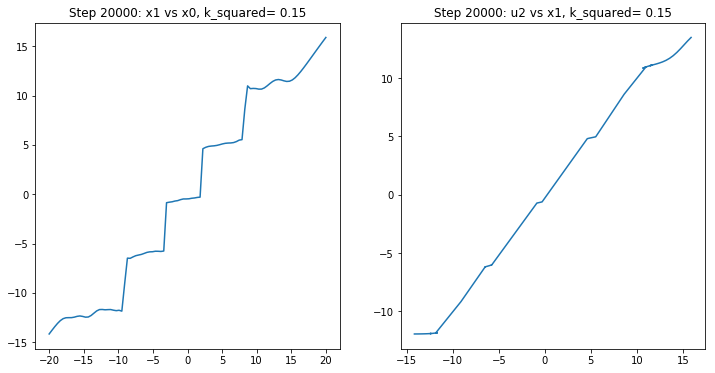

-----Step: 21000
--------Train Cost: 0.5321610569953918 Train Cost Stage1: 0.31989404559135437 Train Cost Stage2: 0.21226699650287628 
--------Test Cost: 0.5062391710157336 Test Cost_Stage1: 0.3208719930251265, Test_Cost_Stage2: 0.18536716828668456
--------14.197598934173584 seconds ---


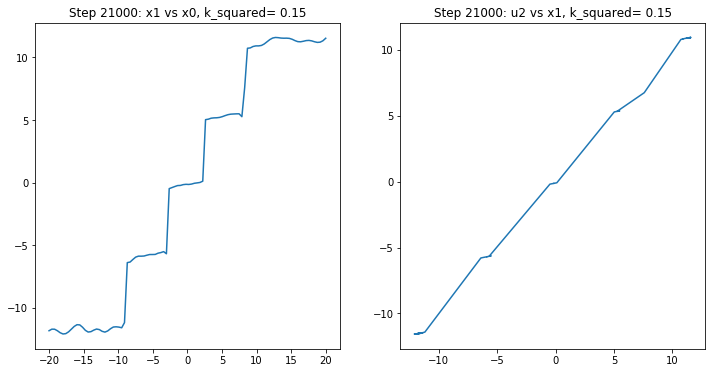

-----Step: 22000
--------Train Cost: 0.5266321301460266 Train Cost Stage1: 0.32805973291397095 Train Cost Stage2: 0.19857241213321686 
--------Test Cost: 0.48203926036190525 Test Cost_Stage1: 0.3367959746152641, Test_Cost_Stage2: 0.14524329872154093
--------14.412757158279419 seconds ---


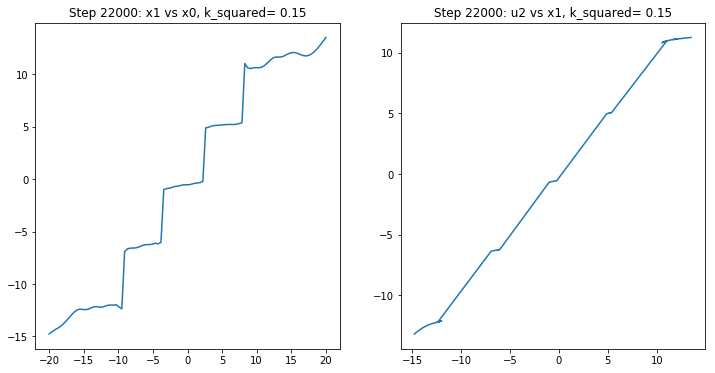

-----Step: 23000
--------Train Cost: 0.5099384784698486 Train Cost Stage1: 0.3292519748210907 Train Cost Stage2: 0.18068651854991913 
--------Test Cost: 0.495263011815043 Test Cost_Stage1: 0.3349910996782418, Test_Cost_Stage2: 0.16027191122115605
--------14.550531148910522 seconds ---


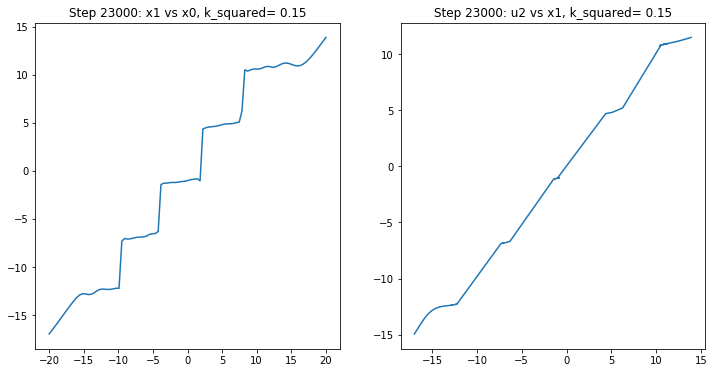

-----Step: 24000
--------Train Cost: 0.5295755863189697 Train Cost Stage1: 0.30975210666656494 Train Cost Stage2: 0.2198234647512436 
--------Test Cost: 0.5250630237542512 Test Cost_Stage1: 0.30425636035583176, Test_Cost_Stage2: 0.2208066632523611
--------15.102629899978638 seconds ---


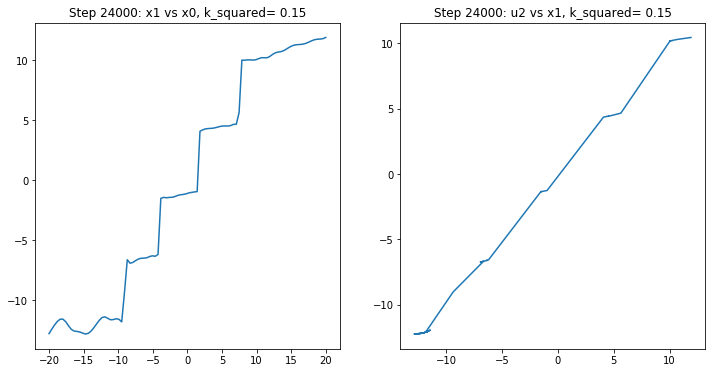

-----Step: 25000
--------Train Cost: 0.5320261120796204 Train Cost Stage1: 0.327588826417923 Train Cost Stage2: 0.20443730056285858 
--------Test Cost: 0.485441926657975 Test Cost_Stage1: 0.33821545755192867, Test_Cost_Stage2: 0.1472264691802132
--------15.1330726146698 seconds ---


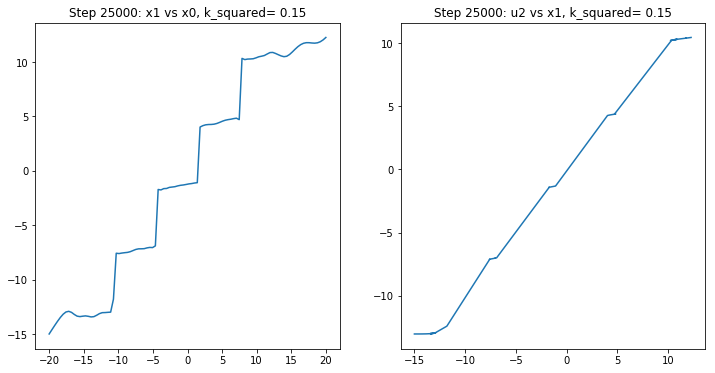

-----Step: 26000
--------Train Cost: 0.5225790143013 Train Cost Stage1: 0.3151811957359314 Train Cost Stage2: 0.20739783346652985 
--------Test Cost: 0.574358800184881 Test Cost_Stage1: 0.3073898917092508, Test_Cost_Stage2: 0.2669689157443603
--------14.924012184143066 seconds ---


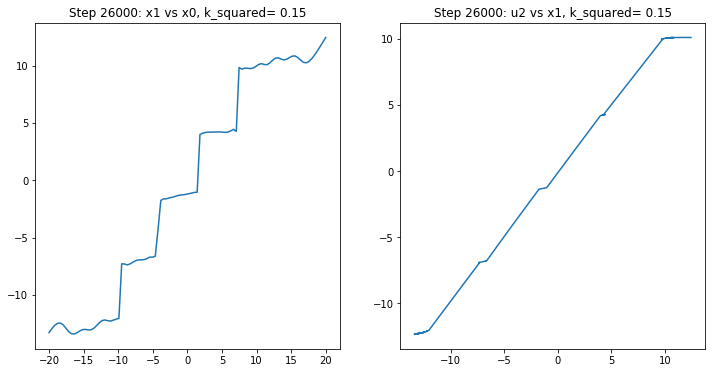

-----Step: 27000
--------Train Cost: 0.5323867797851562 Train Cost Stage1: 0.3331920802593231 Train Cost Stage2: 0.19919468462467194 
--------Test Cost: 0.501950690788046 Test Cost_Stage1: 0.3354437643325883, Test_Cost_Stage2: 0.16650693387867216
--------14.673822164535522 seconds ---


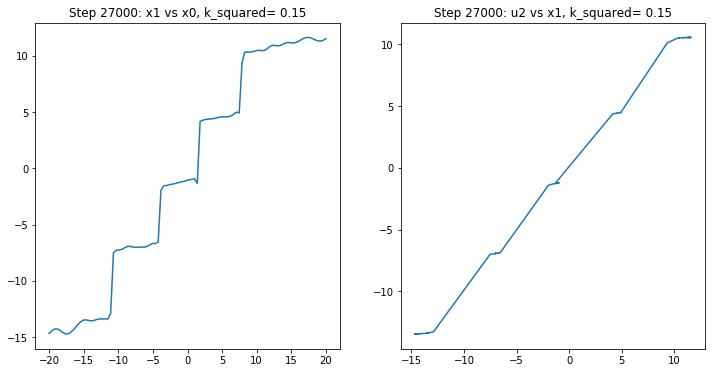

-----Step: 28000
--------Train Cost: 0.5275574922561646 Train Cost Stage1: 0.3369326889514923 Train Cost Stage2: 0.19062480330467224 
--------Test Cost: 0.48288782972541516 Test Cost_Stage1: 0.3361770186364311, Test_Cost_Stage2: 0.1467108132632877
--------15.093551397323608 seconds ---


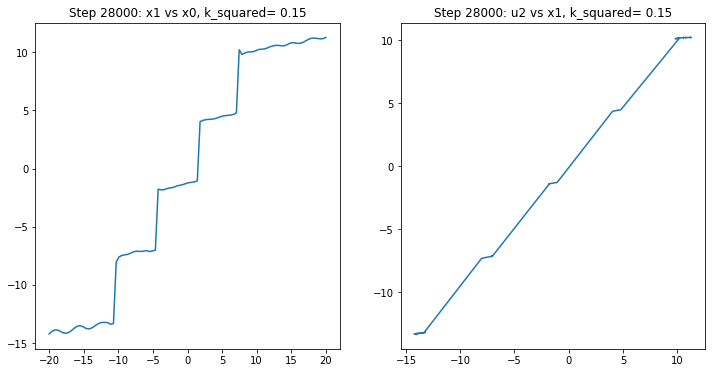

-----Step: 29000
--------Train Cost: 0.5417361259460449 Train Cost Stage1: 0.3451369106769562 Train Cost Stage2: 0.19659921526908875 
--------Test Cost: 0.5111029670538022 Test Cost_Stage1: 0.36841387282698795, Test_Cost_Stage2: 0.14268910761451012
--------14.790804862976074 seconds ---


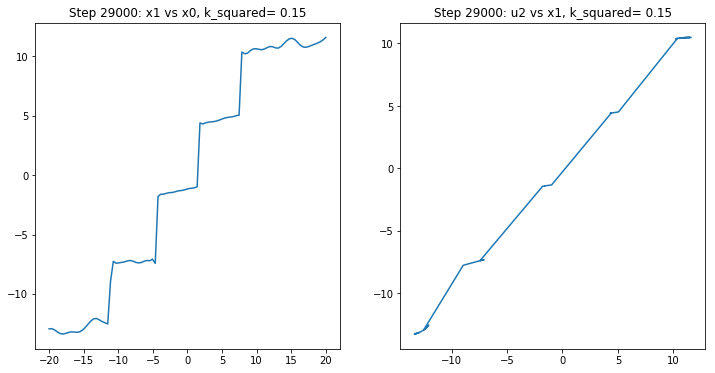

-----Step: 30000
--------Train Cost: 0.543628990650177 Train Cost Stage1: 0.3182799220085144 Train Cost Stage2: 0.2253490686416626 
--------Test Cost: 0.5004687686790855 Test Cost_Stage1: 0.35153185449006896, Test_Cost_Stage2: 0.1489369131229547
--------15.207153797149658 seconds ---


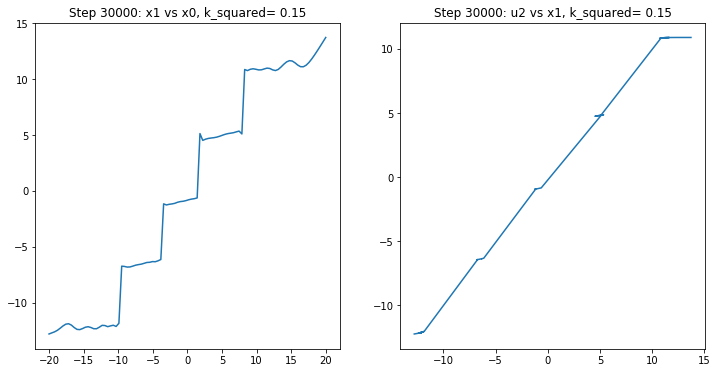

-----Step: 31000
--------Train Cost: 0.5207339525222778 Train Cost Stage1: 0.33780398964881897 Train Cost Stage2: 0.18292996287345886 
--------Test Cost: 0.6603606392796469 Test Cost_Stage1: 0.31392159626635646, Test_Cost_Stage2: 0.34643905128540287
--------14.531397581100464 seconds ---


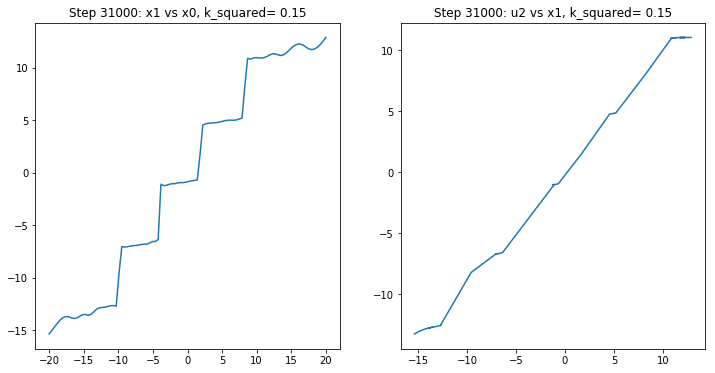

-----Step: 32000
--------Train Cost: 0.5275807976722717 Train Cost Stage1: 0.33502456545829773 Train Cost Stage2: 0.1925562471151352 
--------Test Cost: 0.507205938697857 Test Cost_Stage1: 0.3322103919653747, Test_Cost_Stage2: 0.17499555082620474
--------15.236637592315674 seconds ---


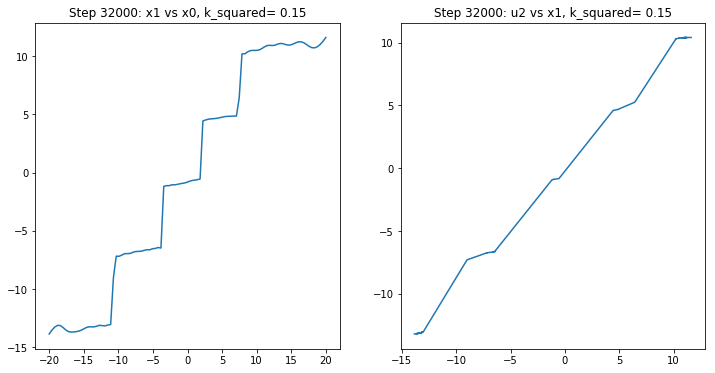

-----Step: 33000
--------Train Cost: 0.511743426322937 Train Cost Stage1: 0.3206704556941986 Train Cost Stage2: 0.1910729706287384 
--------Test Cost: 0.5171696996803484 Test Cost_Stage1: 0.3179586048440745, Test_Cost_Stage2: 0.19921109250009916
--------14.54303789138794 seconds ---


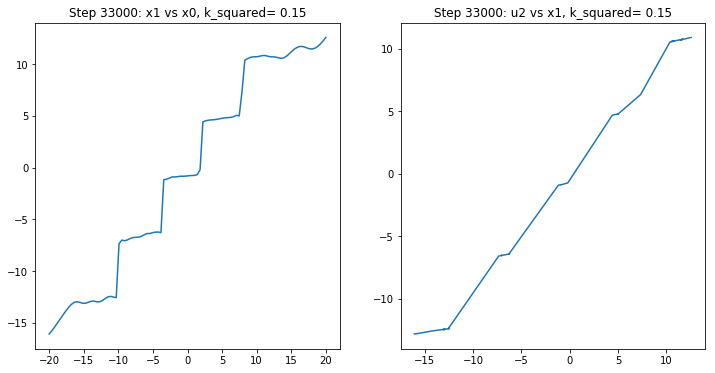

-----Step: 34000
--------Train Cost: 0.5344666242599487 Train Cost Stage1: 0.3174647092819214 Train Cost Stage2: 0.21700188517570496 
--------Test Cost: 0.6247048662926673 Test Cost_Stage1: 0.29960665504310713, Test_Cost_Stage2: 0.325098201367734
--------15.13744044303894 seconds ---


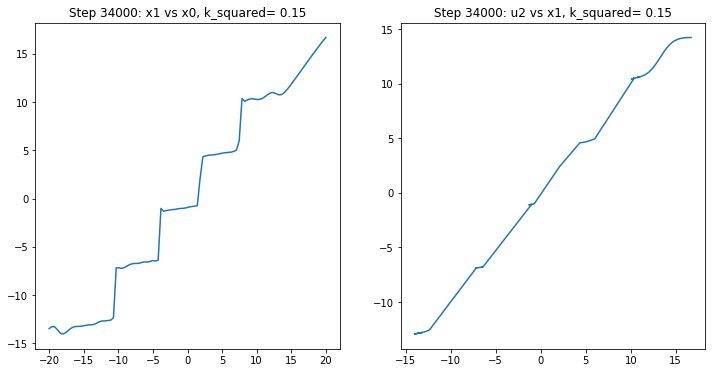

-----Step: 35000
--------Train Cost: 0.5293574929237366 Train Cost Stage1: 0.32891976833343506 Train Cost Stage2: 0.20043770968914032 
--------Test Cost: 0.5318228048498476 Test Cost_Stage1: 0.33396564835952225, Test_Cost_Stage2: 0.1978571736927843
--------14.808938264846802 seconds ---


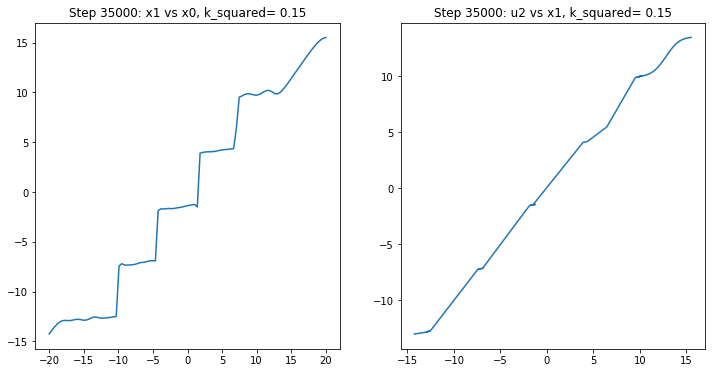

-----Step: 36000
--------Train Cost: 0.4965780973434448 Train Cost Stage1: 0.33381637930870056 Train Cost Stage2: 0.16276170313358307 
--------Test Cost: 0.48674074948069346 Test Cost_Stage1: 0.3347463522769561, Test_Cost_Stage2: 0.15199439866371176
--------15.934062004089355 seconds ---


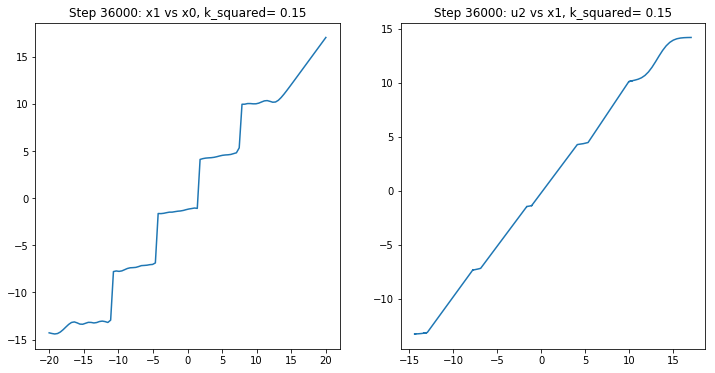

-----Step: 37000
--------Train Cost: 0.5197507739067078 Train Cost Stage1: 0.32545971870422363 Train Cost Stage2: 0.19429107010364532 
--------Test Cost: 0.49327337012732847 Test Cost_Stage1: 0.32572061309899053, Test_Cost_Stage2: 0.16755275900312394
--------14.662644624710083 seconds ---


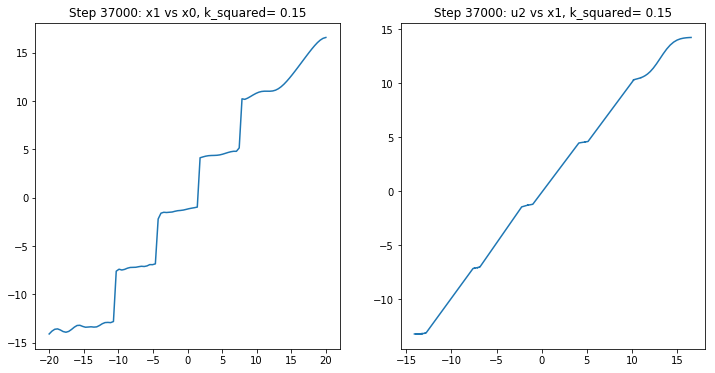

-----Step: 38000
--------Train Cost: 0.5170972347259521 Train Cost Stage1: 0.3193264305591583 Train Cost Stage2: 0.19777081906795502 
--------Test Cost: 0.5176380770540906 Test Cost_Stage1: 0.30590167165462623, Test_Cost_Stage2: 0.211736397064697
--------14.482990264892578 seconds ---


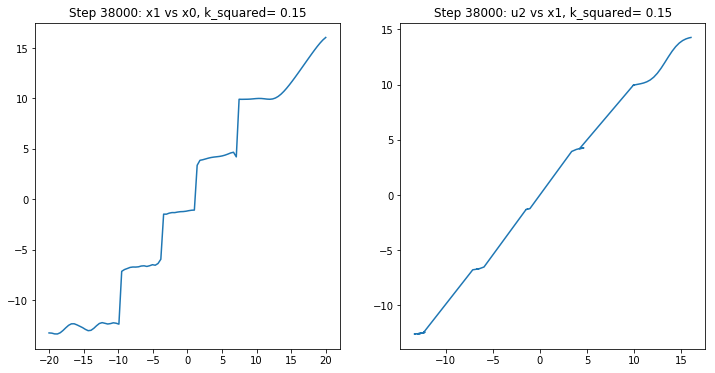

-----Step: 39000
--------Train Cost: 0.5027580857276917 Train Cost Stage1: 0.32679635286331177 Train Cost Stage2: 0.17596174776554108 
--------Test Cost: 0.5078012631659377 Test Cost_Stage1: 0.3311031312312041, Test_Cost_Stage2: 0.17669814066480435
--------15.400254726409912 seconds ---


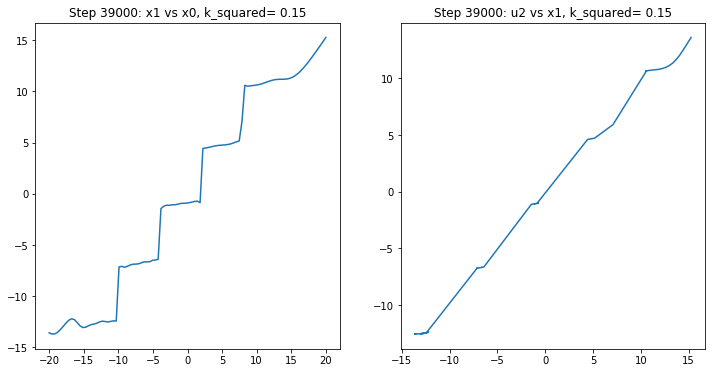

-----Step: 40000
--------Train Cost: 0.51160728931427 Train Cost Stage1: 0.3276766240596771 Train Cost Stage2: 0.18393069505691528 
--------Test Cost: 0.4935100510981555 Test Cost_Stage1: 0.3399810160606436, Test_Cost_Stage2: 0.15352902912203137
--------15.570505857467651 seconds ---


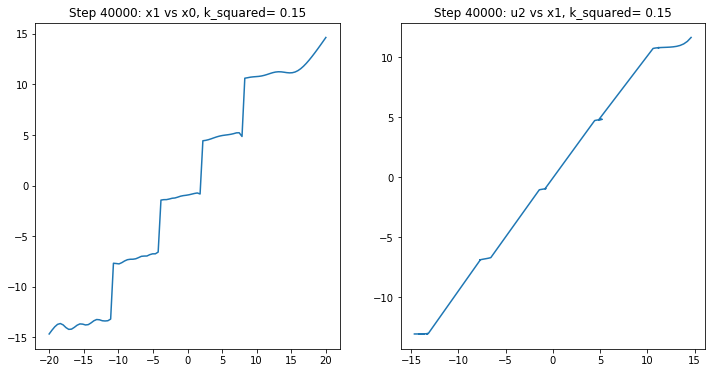

-----Step: 41000
--------Train Cost: 0.5372563600540161 Train Cost Stage1: 0.3382280170917511 Train Cost Stage2: 0.19902831315994263 
--------Test Cost: 0.4756855663252717 Test Cost_Stage1: 0.34254327356103803, Test_Cost_Stage2: 0.13314229512650572
--------15.515637397766113 seconds ---


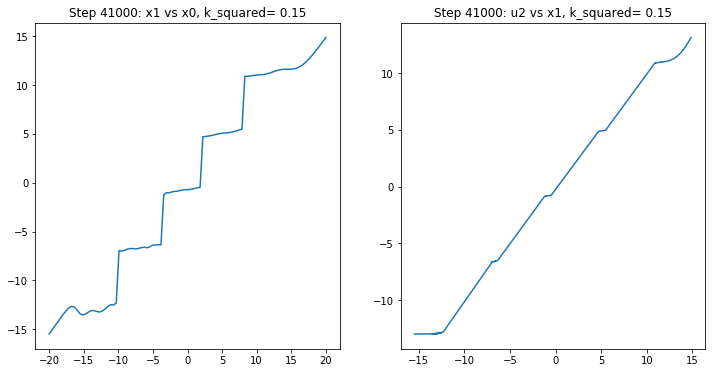

-----Step: 42000
--------Train Cost: 0.5157655477523804 Train Cost Stage1: 0.3288165032863617 Train Cost Stage2: 0.18694902956485748 
--------Test Cost: 0.4918222750538442 Test Cost_Stage1: 0.33787507307188136, Test_Cost_Stage2: 0.15394719697626627
--------14.683227062225342 seconds ---


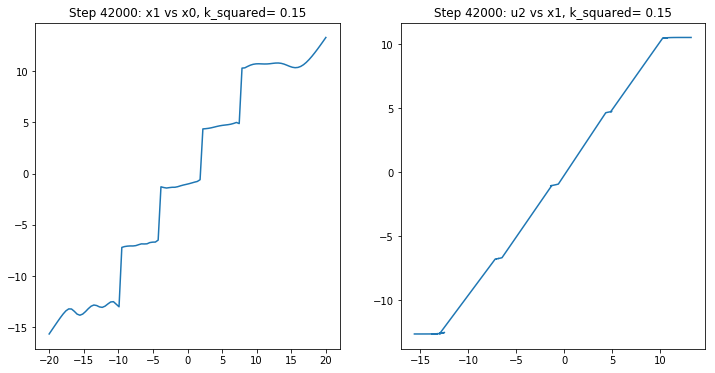

-----Step: 43000
--------Train Cost: 0.5051239132881165 Train Cost Stage1: 0.32777470350265503 Train Cost Stage2: 0.17734919488430023 
--------Test Cost: 0.4903682935321958 Test Cost_Stage1: 0.33585637039108374, Test_Cost_Stage2: 0.15451193386377318
--------15.404892206192017 seconds ---


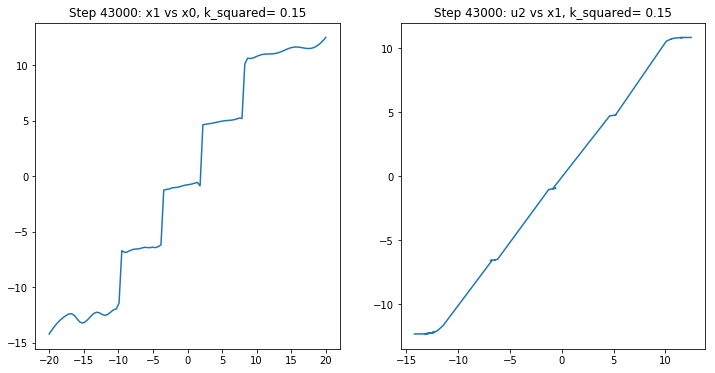

-----Step: 44000
--------Train Cost: 0.5351066589355469 Train Cost Stage1: 0.34149378538131714 Train Cost Stage2: 0.19361290335655212 
--------Test Cost: 0.4968197675717832 Test Cost_Stage1: 0.34558408256058737, Test_Cost_Stage2: 0.15123569378965981
--------15.562351942062378 seconds ---


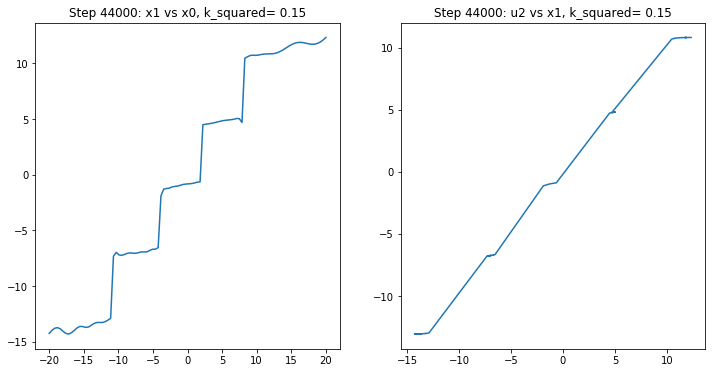

-----Step: 45000
--------Train Cost: 0.5275160670280457 Train Cost Stage1: 0.3284244239330292 Train Cost Stage2: 0.19909162819385529 
--------Test Cost: 0.5071263764876411 Test Cost_Stage1: 0.33005767283120996, Test_Cost_Stage2: 0.17706872399014964
--------14.69010615348816 seconds ---


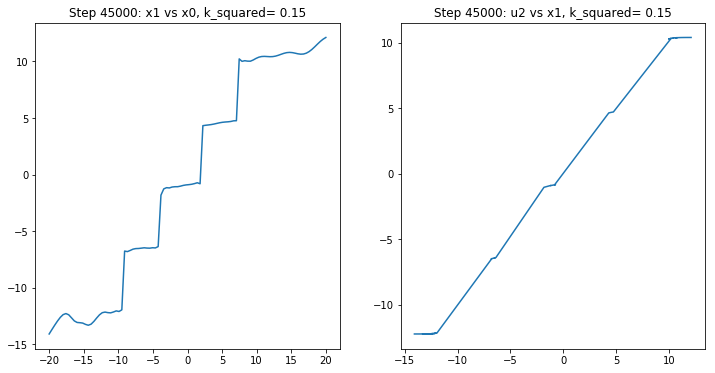

-----Step: 46000
--------Train Cost: 0.5226758718490601 Train Cost Stage1: 0.31200823187828064 Train Cost Stage2: 0.21066762506961823 
--------Test Cost: 0.5036721774586959 Test Cost_Stage1: 0.31903402863552144, Test_Cost_Stage2: 0.18463814846909152
--------14.91041874885559 seconds ---


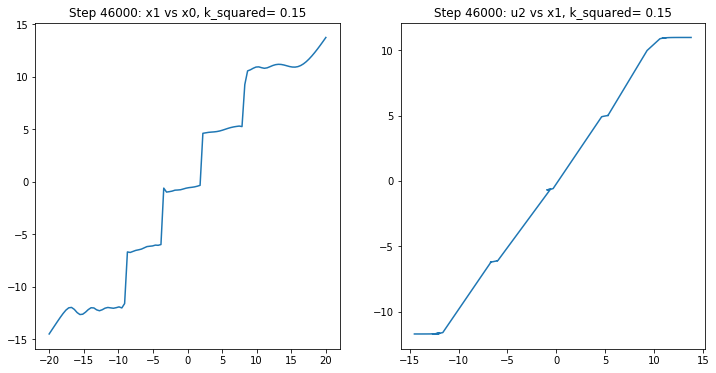

-----Step: 47000
--------Train Cost: 0.49454399943351746 Train Cost Stage1: 0.30838680267333984 Train Cost Stage2: 0.1861571967601776 
--------Test Cost: 0.49150953087397964 Test Cost_Stage1: 0.31994068604911663, Test_Cost_Stage2: 0.17156884803744288
--------14.968013048171997 seconds ---


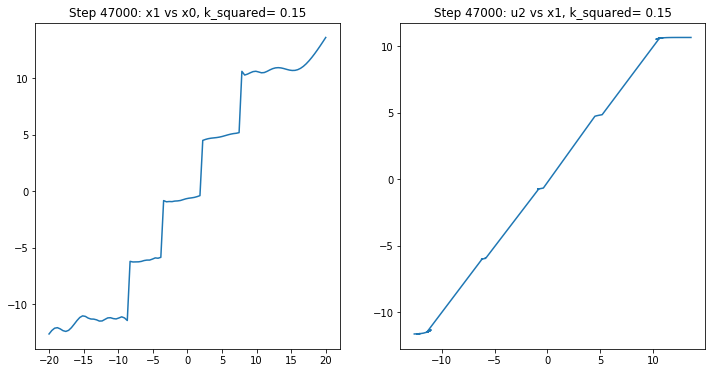

-----Step: 48000
--------Train Cost: 0.5049548745155334 Train Cost Stage1: 0.3326311409473419 Train Cost Stage2: 0.17232371866703033 
--------Test Cost: 0.5768087281700478 Test Cost_Stage1: 0.3153157336042527, Test_Cost_Stage2: 0.2614929877659227
--------15.112733602523804 seconds ---


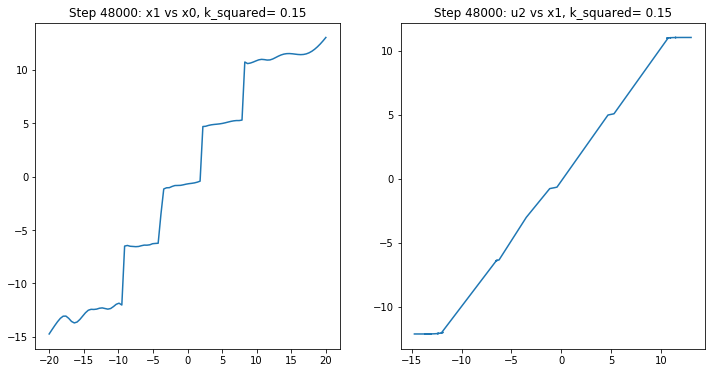

-----Step: 49000
--------Train Cost: 0.5526168346405029 Train Cost Stage1: 0.32215940952301025 Train Cost Stage2: 0.23045742511749268 
--------Test Cost: 0.48934130551777155 Test Cost_Stage1: 0.32632700058279157, Test_Cost_Stage2: 0.1630143032446175
--------15.059171676635742 seconds ---


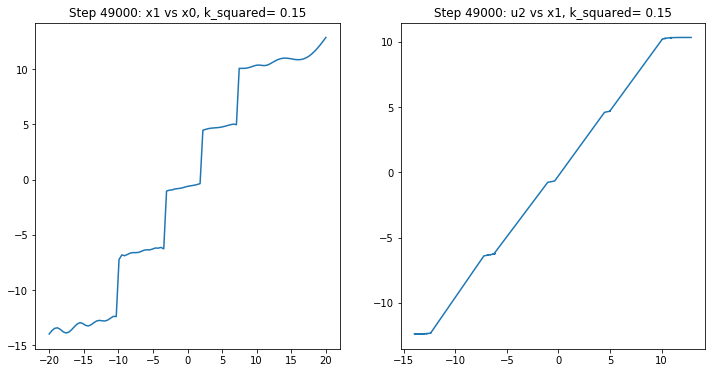

-----Step: 50000
--------Train Cost: 0.49814844131469727 Train Cost Stage1: 0.34074777364730835 Train Cost Stage2: 0.15740065276622772 
--------Test Cost: 0.4851771512991828 Test Cost_Stage1: 0.35313139070973915, Test_Cost_Stage2: 0.1320457477509823
--------14.857353925704956 seconds ---


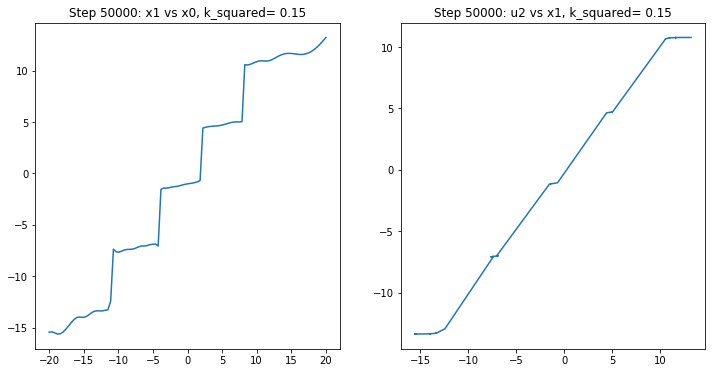

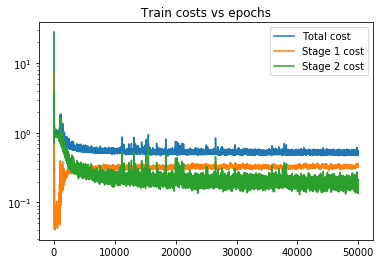

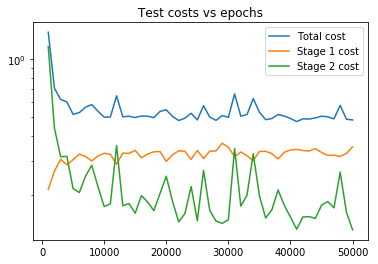

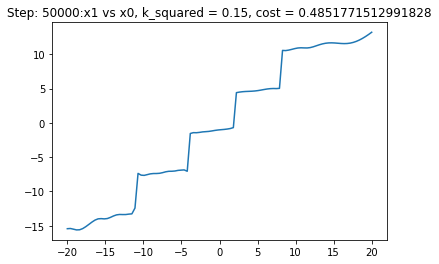

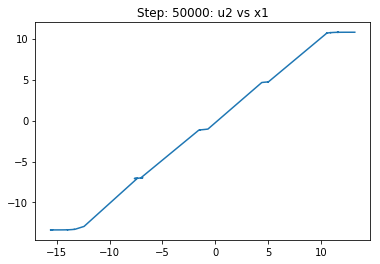

ls1_hu:150,sigmoid,nl:1,ls2_hu:1,identity,nl:1,ls3_hu:30,sigmoid,nl:1,ls4_hu:1,identity,nl:1,k_squared:0.2,lr:0.2,1,me:50000,bsz:10000,std_x0:5.0,std_z:1.0,Adam,krf:0.5
Using glorot normal initializer for encoder/layer1/kernel:0
Using zeros initializer for encoder/layer1/bias:0
Using glorot normal initializer for encoder/layer2/kernel:0
Using zeros initializer for encoder/layer2/bias:0
Using glorot normal initializer for decoder/layer3/kernel:0
Using zeros initializer for decoder/layer3/bias:0
Using glorot normal initializer for decoder/layer4/kernel:0
Using zeros initializer for decoder/layer4/bias:0
Training...


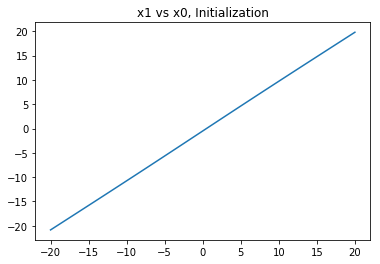

-----Step: 1000
--------Train Cost: 0.9411770105361938 Train Cost Stage1: 0.005133630707859993 Train Cost Stage2: 0.936043381690979 
--------Test Cost: 0.9764021808299463 Test Cost_Stage1: 0.0019316333317875311, Test_Cost_Stage2: 0.9744705296404512
--------15.027153253555298 seconds ---


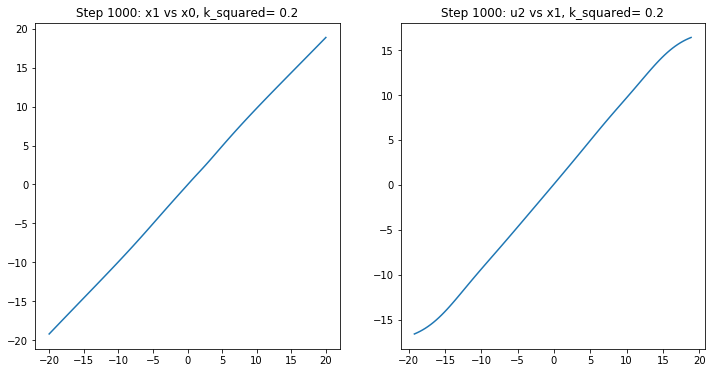

-----Step: 2000
--------Train Cost: 0.9728434681892395 Train Cost Stage1: 0.008741490542888641 Train Cost Stage2: 0.9641019701957703 
--------Test Cost: 0.9854608841420236 Test Cost_Stage1: 0.01422842219049941, Test_Cost_Stage2: 0.9712324562254715
--------15.216660261154175 seconds ---


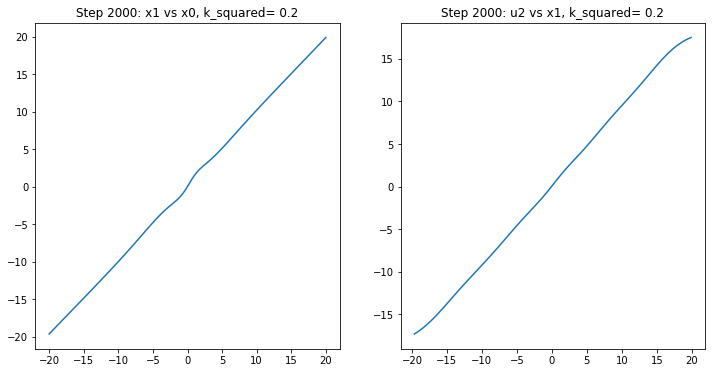

-----Step: 3000
--------Train Cost: 0.8595662117004395 Train Cost Stage1: 0.2573357820510864 Train Cost Stage2: 0.602230429649353 
--------Test Cost: 0.8310773334370393 Test Cost_Stage1: 0.2506035596157609, Test_Cost_Stage2: 0.580473750872853
--------14.576614141464233 seconds ---


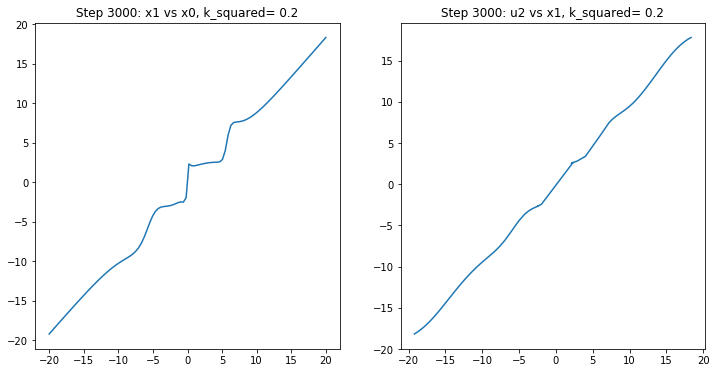

-----Step: 4000
--------Train Cost: 0.7053552269935608 Train Cost Stage1: 0.2917294502258301 Train Cost Stage2: 0.4136257767677307 
--------Test Cost: 0.6802932317687146 Test Cost_Stage1: 0.31761735780815004, Test_Cost_Stage2: 0.36267587566414405
--------15.694123983383179 seconds ---


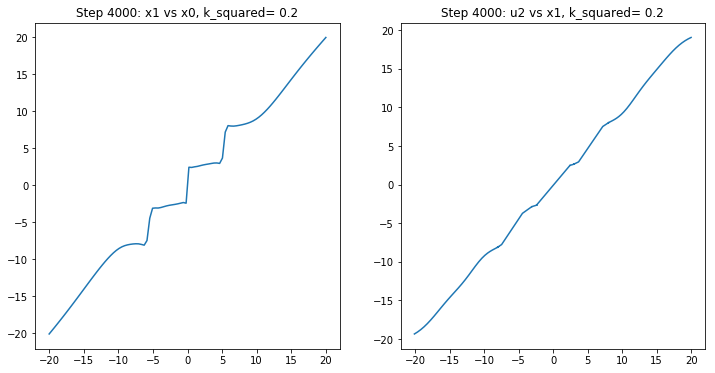

-----Step: 5000
--------Train Cost: 0.6708493232727051 Train Cost Stage1: 0.3148692548274994 Train Cost Stage2: 0.3559800684452057 
--------Test Cost: 0.6558770403735282 Test Cost_Stage1: 0.3241604600143905, Test_Cost_Stage2: 0.3317165715183788
--------15.24133038520813 seconds ---


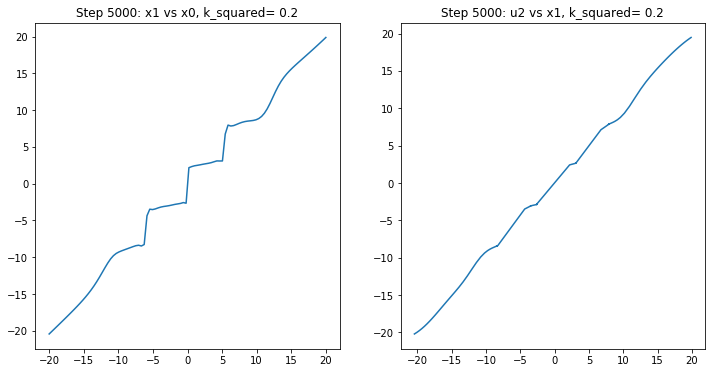

-----Step: 6000
--------Train Cost: 0.6619538068771362 Train Cost Stage1: 0.3425999879837036 Train Cost Stage2: 0.3193538188934326 
--------Test Cost: 0.6459870899221825 Test Cost_Stage1: 0.34605454325054946, Test_Cost_Stage2: 0.2999325667139004
--------15.657798528671265 seconds ---


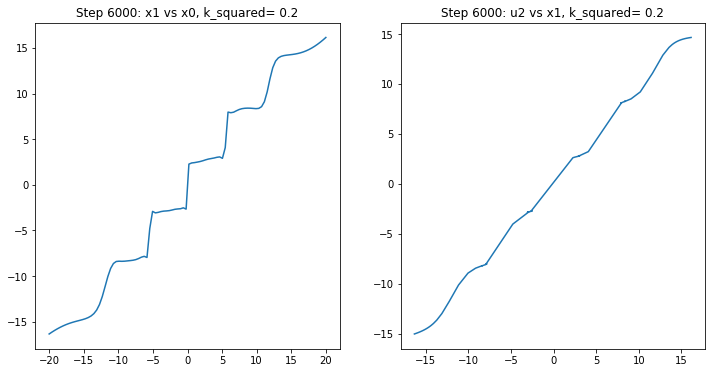

-----Step: 7000
--------Train Cost: 0.6781401634216309 Train Cost Stage1: 0.3334077298641205 Train Cost Stage2: 0.3447324335575104 
--------Test Cost: 0.6305362919123422 Test Cost_Stage1: 0.32433054510237014, Test_Cost_Stage2: 0.30620574235578263
--------15.407906293869019 seconds ---


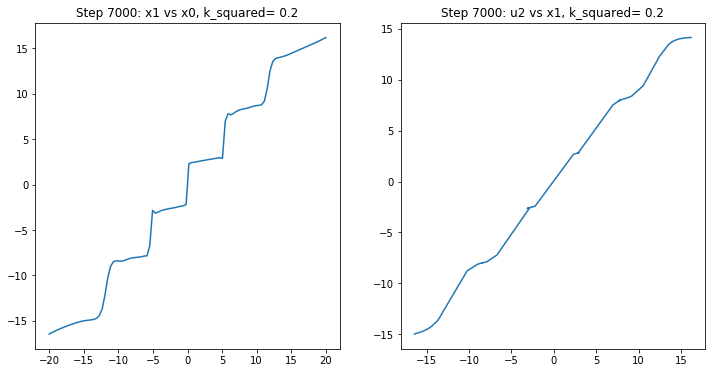

-----Step: 8000
--------Train Cost: 0.6133718490600586 Train Cost Stage1: 0.3209090828895569 Train Cost Stage2: 0.2924627363681793 
--------Test Cost: 0.6309760054092174 Test Cost_Stage1: 0.32641080812894846, Test_Cost_Stage2: 0.3045651960614737
--------15.226823091506958 seconds ---


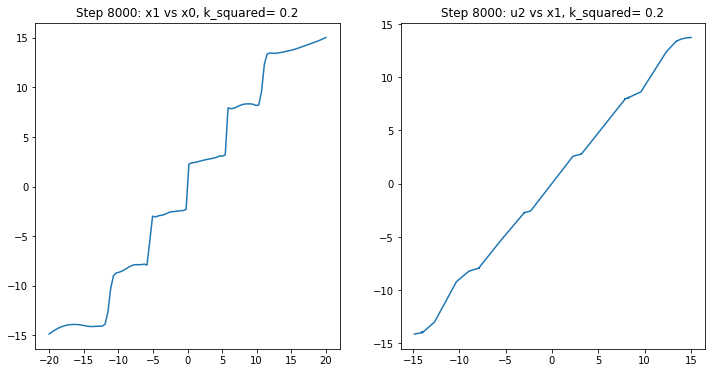

-----Step: 9000
--------Train Cost: 0.6260462999343872 Train Cost Stage1: 0.3459084630012512 Train Cost Stage2: 0.280137836933136 
--------Test Cost: 0.5999355175482761 Test Cost_Stage1: 0.3464329005918785, Test_Cost_Stage2: 0.25350261330657
--------14.795706033706665 seconds ---


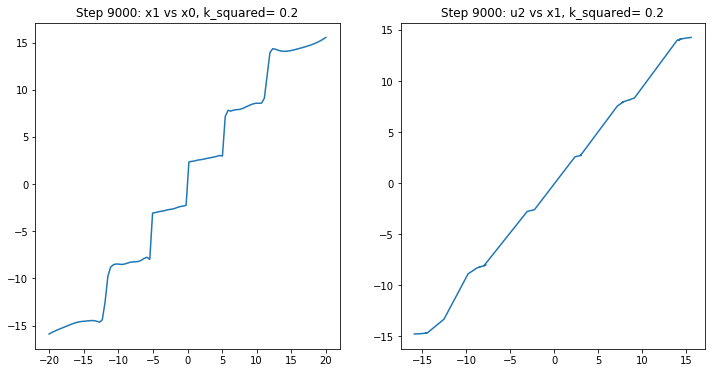

-----Step: 10000
--------Train Cost: 0.6431392431259155 Train Cost Stage1: 0.32987740635871887 Train Cost Stage2: 0.31326183676719666 
--------Test Cost: 0.6104010986991404 Test Cost_Stage1: 0.3241497467533151, Test_Cost_Stage2: 0.28625134844524786
--------14.79374361038208 seconds ---


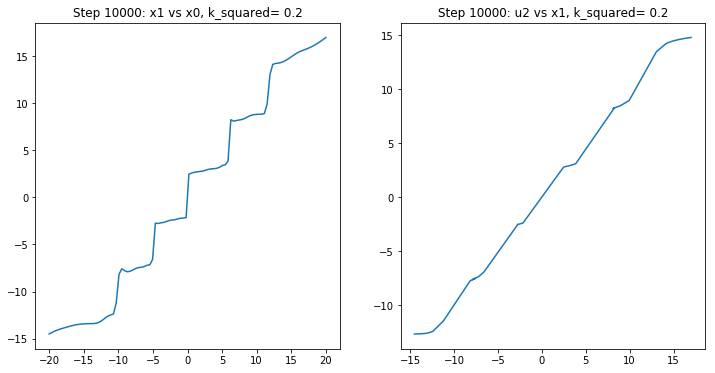

-----Step: 11000
--------Train Cost: 0.6178610324859619 Train Cost Stage1: 0.3465346693992615 Train Cost Stage2: 0.27132636308670044 
--------Test Cost: 0.6070826450951805 Test Cost_Stage1: 0.3502508461903625, Test_Cost_Stage2: 0.2568317886469501
--------13.659200668334961 seconds ---


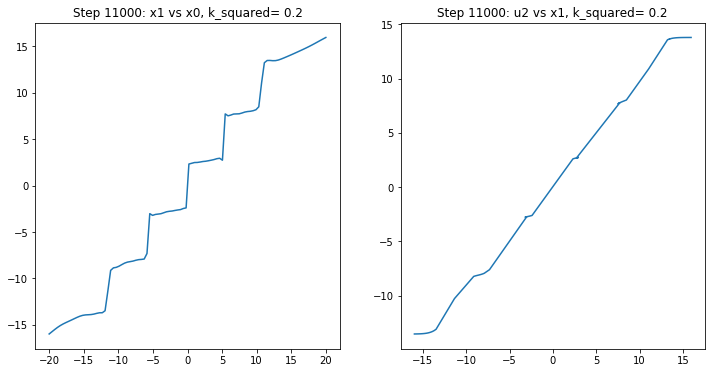

-----Step: 12000
--------Train Cost: 0.6598987579345703 Train Cost Stage1: 0.35264575481414795 Train Cost Stage2: 0.3072529733181 
--------Test Cost: 0.6517524147897559 Test Cost_Stage1: 0.3599622250790485, Test_Cost_Stage2: 0.29179018425846276
--------14.420547723770142 seconds ---


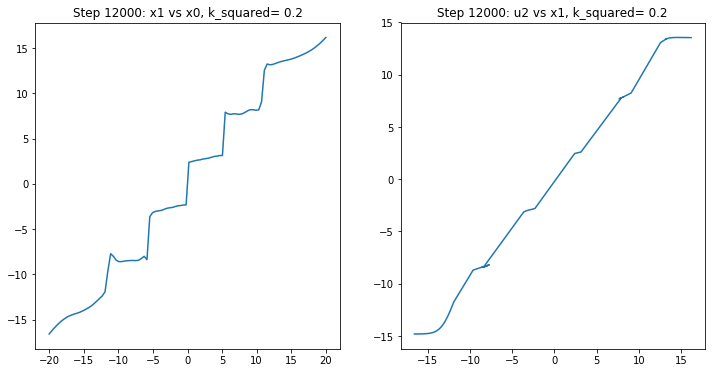

-----Step: 13000
--------Train Cost: 0.6470344662666321 Train Cost Stage1: 0.3556584417819977 Train Cost Stage2: 0.2913760244846344 
--------Test Cost: 0.6048801541924598 Test Cost_Stage1: 0.37516675902499236, Test_Cost_Stage2: 0.22971339672990365
--------14.915464639663696 seconds ---


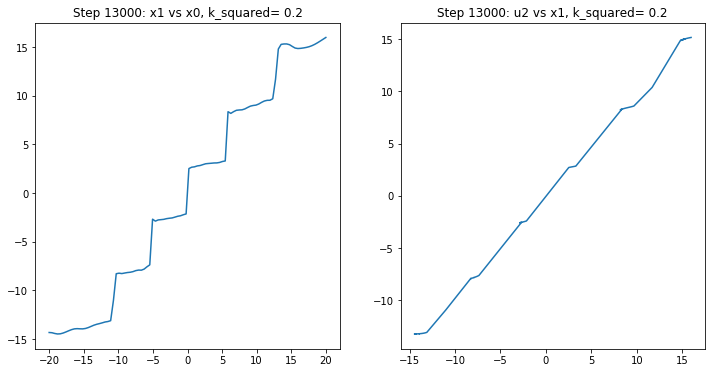

-----Step: 14000
--------Train Cost: 0.5981839299201965 Train Cost Stage1: 0.35516929626464844 Train Cost Stage2: 0.2430146485567093 
--------Test Cost: 0.6265598121421705 Test Cost_Stage1: 0.34392199681802416, Test_Cost_Stage2: 0.2826378286569926
--------14.113002061843872 seconds ---


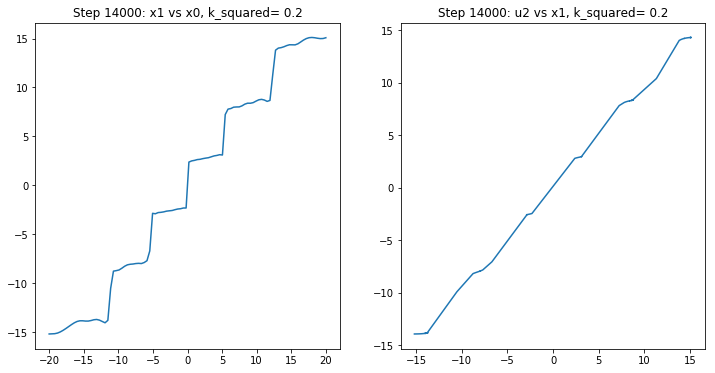

-----Step: 15000
--------Train Cost: 0.6649930477142334 Train Cost Stage1: 0.378391832113266 Train Cost Stage2: 0.2866012454032898 
--------Test Cost: 0.6698466008001167 Test Cost_Stage1: 0.36836646000709167, Test_Cost_Stage2: 0.30148014622841307
--------14.205710649490356 seconds ---


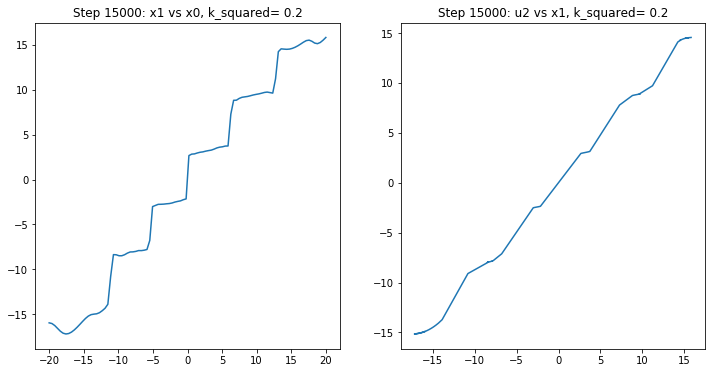

-----Step: 16000
--------Train Cost: 0.6114094257354736 Train Cost Stage1: 0.3636983633041382 Train Cost Stage2: 0.24771107733249664 
--------Test Cost: 0.6330195374263058 Test Cost_Stage1: 0.3509434585932719, Test_Cost_Stage2: 0.2820760757836967
--------14.640282392501831 seconds ---


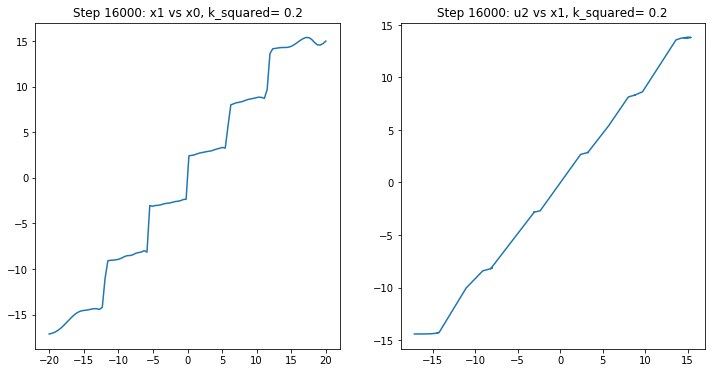

-----Step: 17000
--------Train Cost: 0.6213219165802002 Train Cost Stage1: 0.37050899863243103 Train Cost Stage2: 0.25081291794776917 
--------Test Cost: 0.5858216734056976 Test Cost_Stage1: 0.3858284673854808, Test_Cost_Stage2: 0.1999932143724842
--------14.646631240844727 seconds ---


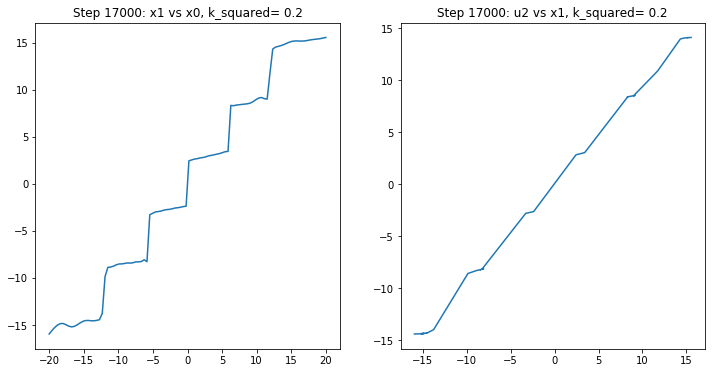

-----Step: 18000
--------Train Cost: 0.6134874224662781 Train Cost Stage1: 0.36634331941604614 Train Cost Stage2: 0.24714408814907074 
--------Test Cost: 0.6432842235560641 Test Cost_Stage1: 0.3389932674096075, Test_Cost_Stage2: 0.30429094477366153
--------14.882766008377075 seconds ---


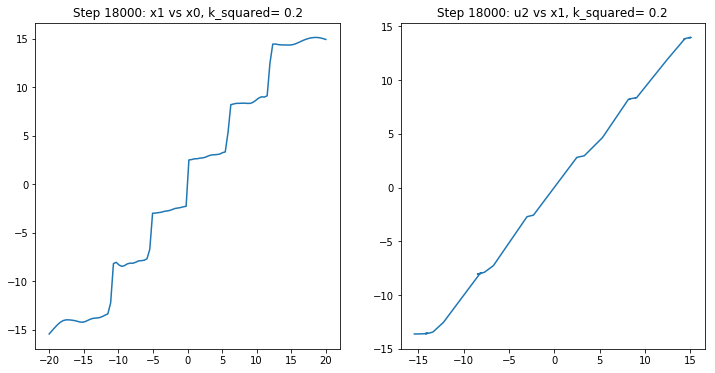

-----Step: 19000
--------Train Cost: 0.5898030400276184 Train Cost Stage1: 0.3493165075778961 Train Cost Stage2: 0.2404865175485611 
--------Test Cost: 0.6085815035520598 Test Cost_Stage1: 0.34397249198135416, Test_Cost_Stage2: 0.2646090184137583
--------14.05329704284668 seconds ---


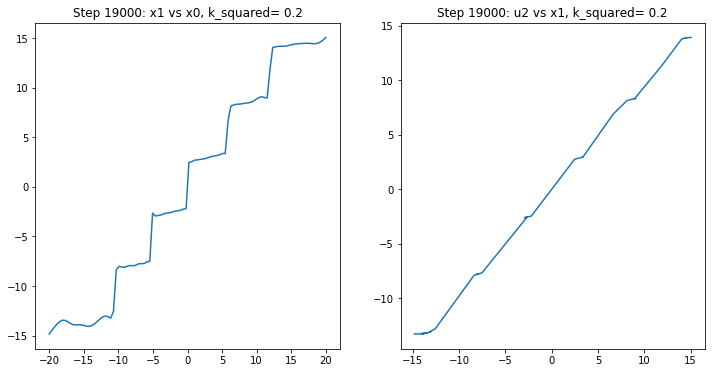

-----Step: 20000
--------Train Cost: 0.5874320268630981 Train Cost Stage1: 0.3584412634372711 Train Cost Stage2: 0.22899077832698822 
--------Test Cost: 0.6394192610445149 Test Cost_Stage1: 0.3568324947344839, Test_Cost_Stage2: 0.28258675809944356
--------14.312568426132202 seconds ---


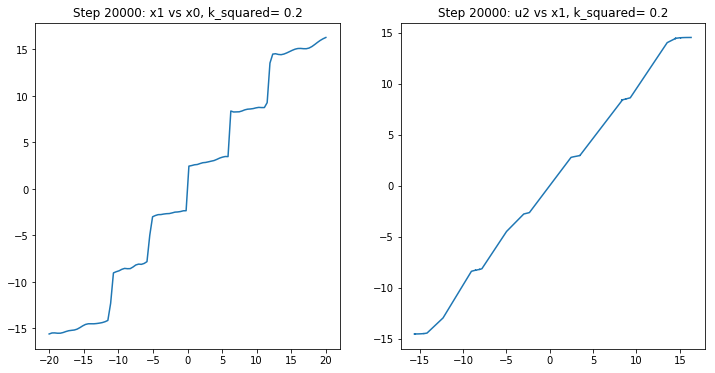

-----Step: 21000
--------Train Cost: 0.6195003390312195 Train Cost Stage1: 0.3702213764190674 Train Cost Stage2: 0.2492789477109909 
--------Test Cost: 0.6362506956866135 Test Cost_Stage1: 0.3684875016505691, Test_Cost_Stage2: 0.26776319474610505
--------14.937618732452393 seconds ---


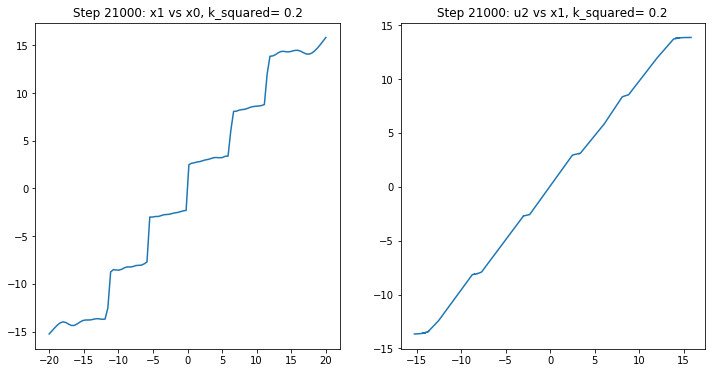

-----Step: 22000
--------Train Cost: 0.5996382236480713 Train Cost Stage1: 0.3570237457752228 Train Cost Stage2: 0.2426144778728485 
--------Test Cost: 0.5865979981444401 Test Cost_Stage1: 0.3662958366601734, Test_Cost_Stage2: 0.22030217189303175
--------15.15013575553894 seconds ---


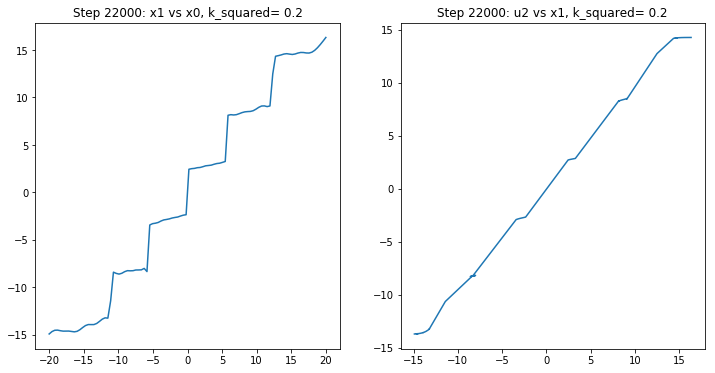

-----Step: 23000
--------Train Cost: 0.583003044128418 Train Cost Stage1: 0.363734632730484 Train Cost Stage2: 0.21926838159561157 
--------Test Cost: 0.6381268214410437 Test Cost_Stage1: 0.34821838650949166, Test_Cost_Stage2: 0.28990842150606333
--------14.983344554901123 seconds ---


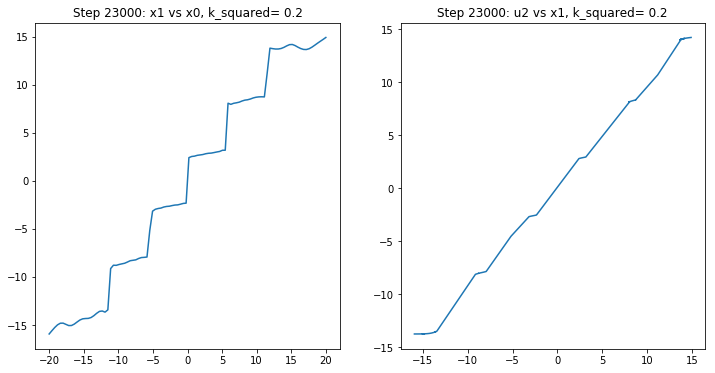

-----Step: 24000
--------Train Cost: 0.6075515151023865 Train Cost Stage1: 0.37987667322158813 Train Cost Stage2: 0.22767482697963715 
--------Test Cost: 0.6449150822123705 Test Cost_Stage1: 0.360313812946743, Test_Cost_Stage2: 0.28460127010044767
--------14.974157571792603 seconds ---


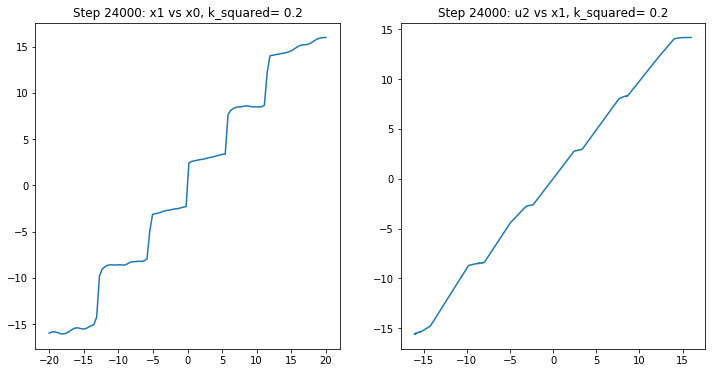

-----Step: 25000
--------Train Cost: 0.6296062469482422 Train Cost Stage1: 0.3428862392902374 Train Cost Stage2: 0.28672000765800476 
--------Test Cost: 0.5825975331843803 Test Cost_Stage1: 0.34658527622813795, Test_Cost_Stage2: 0.23601225841565523
--------15.007735967636108 seconds ---


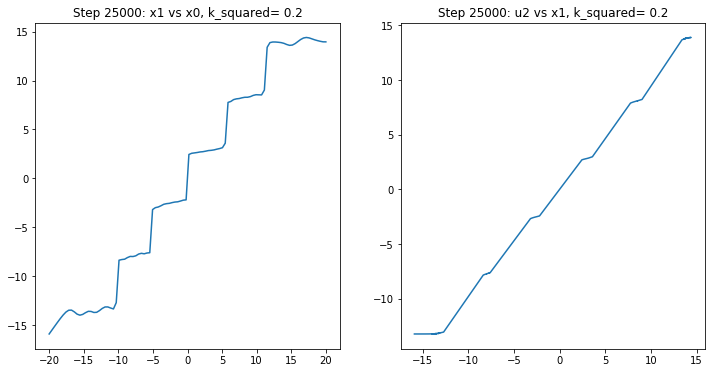

-----Step: 26000
--------Train Cost: 0.6002422571182251 Train Cost Stage1: 0.3528655171394348 Train Cost Stage2: 0.24737675487995148 
--------Test Cost: 0.5824774675227281 Test Cost_Stage1: 0.3586929094807819, Test_Cost_Stage2: 0.22378455869734462
--------15.5256667137146 seconds ---


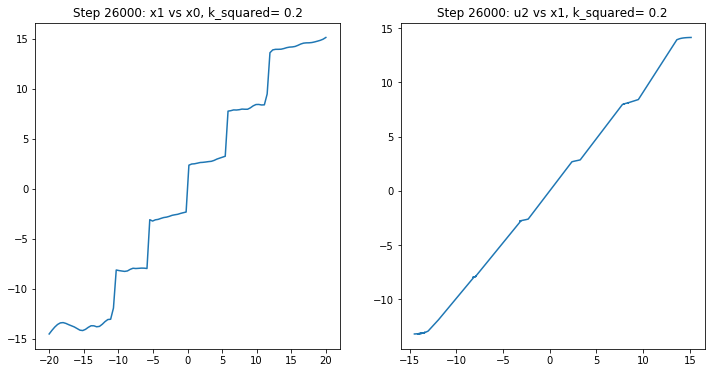

-----Step: 27000
--------Train Cost: 0.6172213554382324 Train Cost Stage1: 0.3603953421115875 Train Cost Stage2: 0.2568259835243225 
--------Test Cost: 0.5961190811491675 Test Cost_Stage1: 0.377081297486433, Test_Cost_Stage2: 0.21903779493057132
--------15.12454104423523 seconds ---


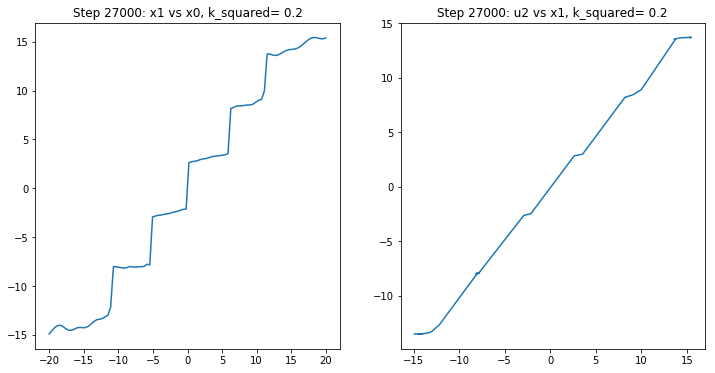

-----Step: 28000
--------Train Cost: 0.6388086080551147 Train Cost Stage1: 0.3465842306613922 Train Cost Stage2: 0.29222437739372253 
--------Test Cost: 0.6422744316416564 Test Cost_Stage1: 0.33388820590011026, Test_Cost_Stage2: 0.3083862229152589
--------14.916339635848999 seconds ---


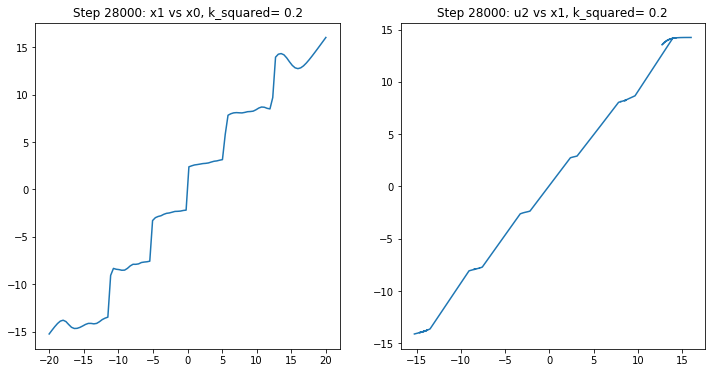

-----Step: 29000
--------Train Cost: 0.5947192311286926 Train Cost Stage1: 0.3430115282535553 Train Cost Stage2: 0.25170770287513733 
--------Test Cost: 0.6179804297228509 Test Cost_Stage1: 0.3348147970941241, Test_Cost_Stage2: 0.2831656422550009
--------15.2239248752594 seconds ---


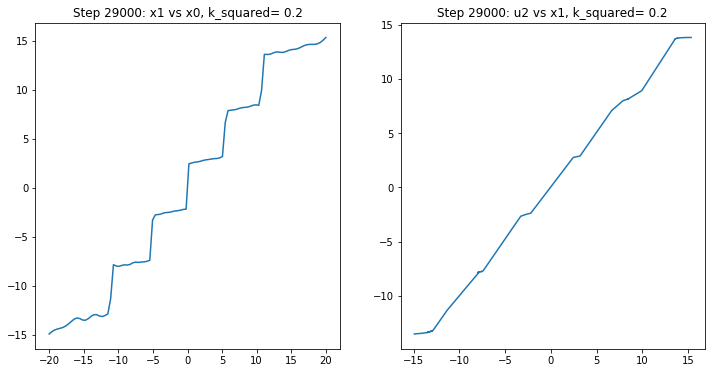

-----Step: 30000
--------Train Cost: 0.6519482135772705 Train Cost Stage1: 0.3632199168205261 Train Cost Stage2: 0.2887282967567444 
--------Test Cost: 0.6787528081477263 Test Cost_Stage1: 0.32035808588725834, Test_Cost_Stage2: 0.35839473512091935
--------14.897318840026855 seconds ---


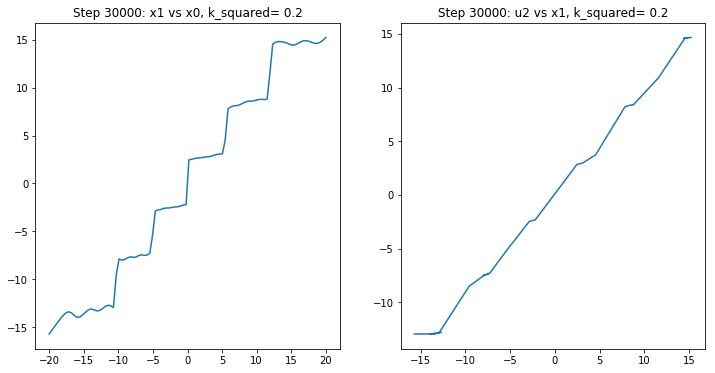

-----Step: 31000
--------Train Cost: 0.64277184009552 Train Cost Stage1: 0.3734648823738098 Train Cost Stage2: 0.2693069875240326 
--------Test Cost: 0.5849787699902245 Test Cost_Stage1: 0.3812098520248575, Test_Cost_Stage2: 0.20376891660319693
--------15.269647598266602 seconds ---


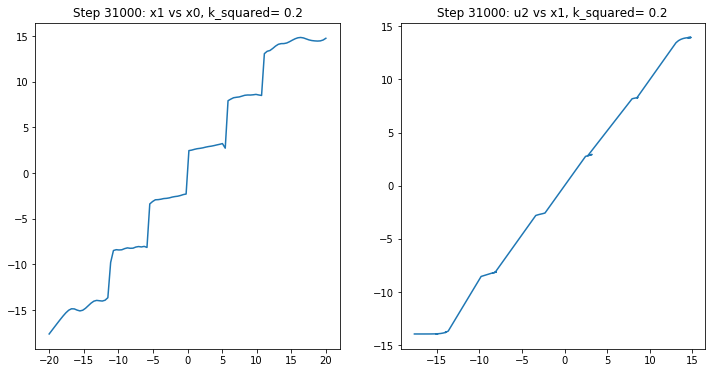

-----Step: 32000
--------Train Cost: 0.6165019273757935 Train Cost Stage1: 0.3479670286178589 Train Cost Stage2: 0.26853489875793457 
--------Test Cost: 0.587063984892464 Test Cost_Stage1: 0.34886450496465005, Test_Cost_Stage2: 0.23819947209144515
--------15.051396131515503 seconds ---


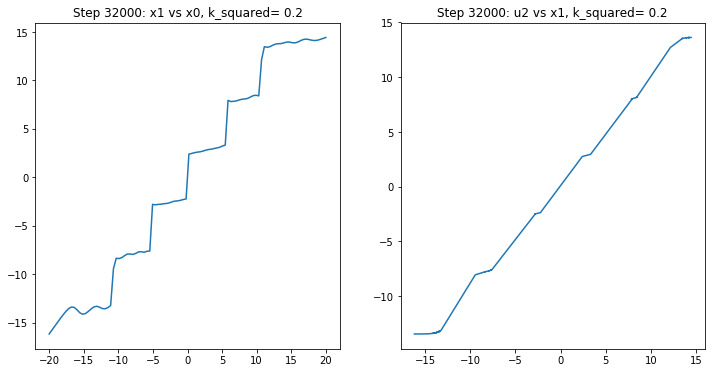

-----Step: 33000
--------Train Cost: 0.6585705280303955 Train Cost Stage1: 0.36661967635154724 Train Cost Stage2: 0.2919508218765259 
--------Test Cost: 0.6165257698236558 Test Cost_Stage1: 0.35205055415771247, Test_Cost_Stage2: 0.2644752121229444
--------14.995487928390503 seconds ---


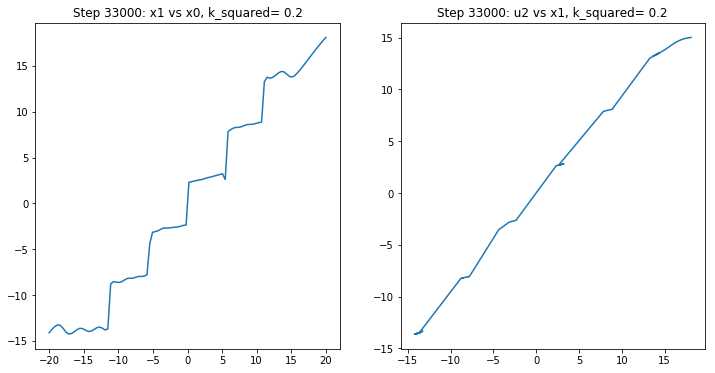

-----Step: 34000
--------Train Cost: 0.6221176981925964 Train Cost Stage1: 0.35971251130104065 Train Cost Stage2: 0.2624051868915558 
--------Test Cost: 0.5767331284710372 Test Cost_Stage1: 0.36686791668081964, Test_Cost_Stage2: 0.20986520723020652
--------14.796342611312866 seconds ---


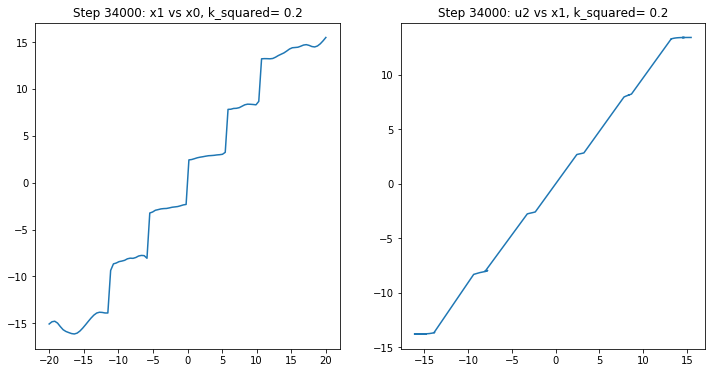

-----Step: 35000
--------Train Cost: 0.5976976752281189 Train Cost Stage1: 0.34183642268180847 Train Cost Stage2: 0.2558612525463104 
--------Test Cost: 0.5696255996010323 Test Cost_Stage1: 0.35440558972789277, Test_Cost_Stage2: 0.2152200090524231
--------15.11414361000061 seconds ---


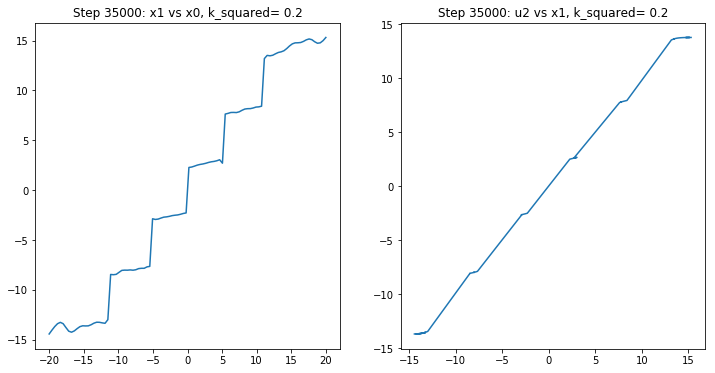

-----Step: 36000
--------Train Cost: 0.6141048073768616 Train Cost Stage1: 0.39394837617874146 Train Cost Stage2: 0.2201564460992813 
--------Test Cost: 0.6314956601189462 Test Cost_Stage1: 0.384175343695624, Test_Cost_Stage2: 0.24732032987897273
--------15.269166231155396 seconds ---


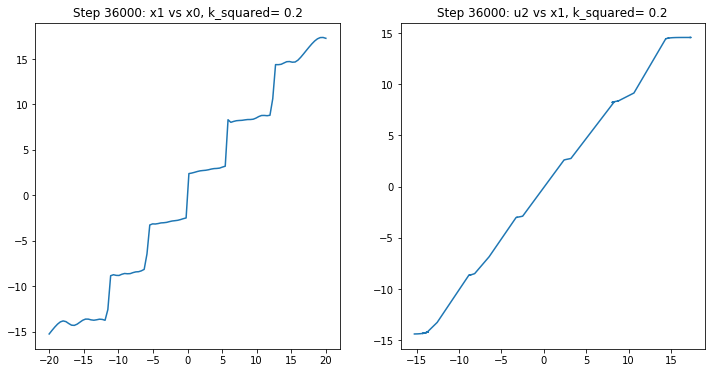

-----Step: 37000
--------Train Cost: 0.5971454381942749 Train Cost Stage1: 0.3627298176288605 Train Cost Stage2: 0.23441565036773682 
--------Test Cost: 0.5808035711025853 Test Cost_Stage1: 0.3739861430464706, Test_Cost_Stage2: 0.20681743104155553
--------15.091672420501709 seconds ---


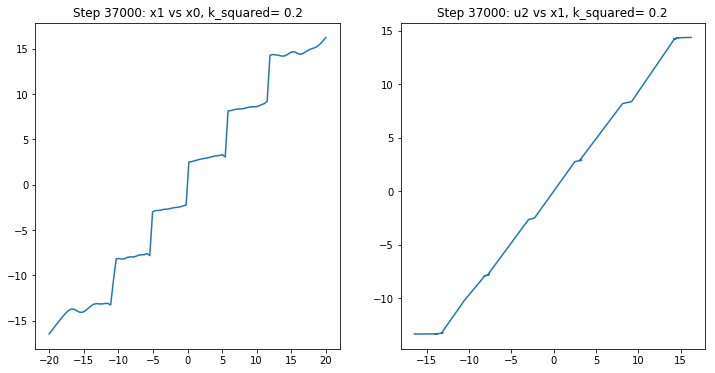

-----Step: 38000
--------Train Cost: 0.5744420289993286 Train Cost Stage1: 0.3488130271434784 Train Cost Stage2: 0.22562900185585022 
--------Test Cost: 0.5868740586255625 Test Cost_Stage1: 0.3423097807584175, Test_Cost_Stage2: 0.2445642749038207
--------14.979530572891235 seconds ---


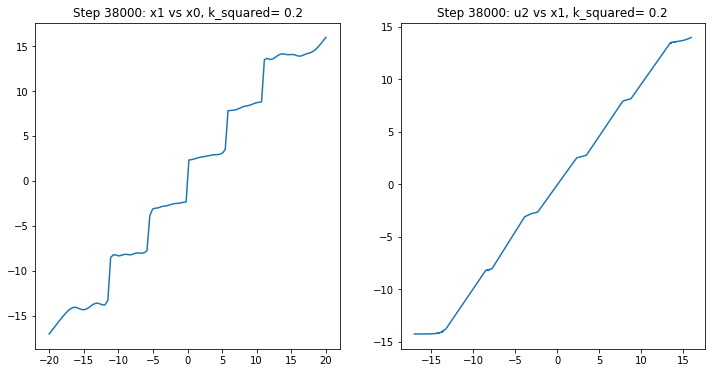

-----Step: 39000
--------Train Cost: 0.5912649631500244 Train Cost Stage1: 0.36749067902565 Train Cost Stage2: 0.22377431392669678 
--------Test Cost: 0.5750145758546742 Test Cost_Stage1: 0.35705255551247733, Test_Cost_Stage2: 0.21796200868892454
--------15.746092796325684 seconds ---


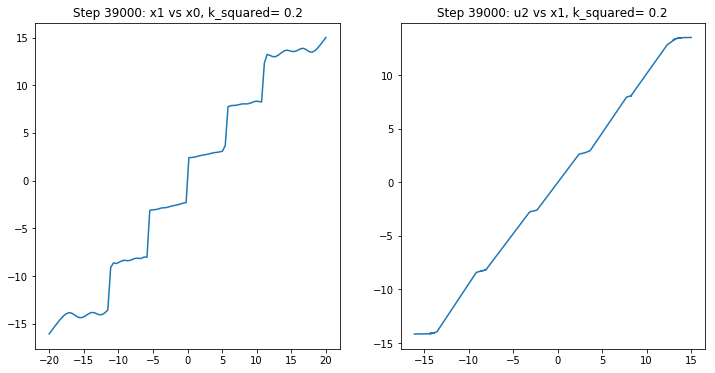

-----Step: 40000
--------Train Cost: 0.5999928712844849 Train Cost Stage1: 0.36871299147605896 Train Cost Stage2: 0.2312798649072647 
--------Test Cost: 0.6163822821702325 Test Cost_Stage1: 0.3648210779177066, Test_Cost_Stage2: 0.25156118999642624
--------15.084931135177612 seconds ---


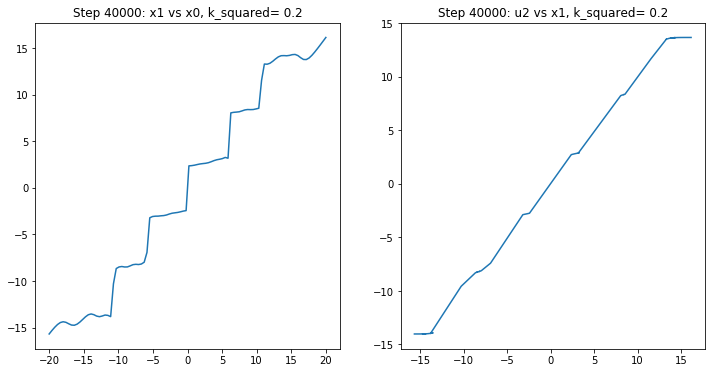

-----Step: 41000
--------Train Cost: 0.6108766794204712 Train Cost Stage1: 0.36047881841659546 Train Cost Stage2: 0.25039786100387573 
--------Test Cost: 0.5887423310417605 Test Cost_Stage1: 0.3549463626046344, Test_Cost_Stage2: 0.23379596822722118
--------15.334618330001831 seconds ---


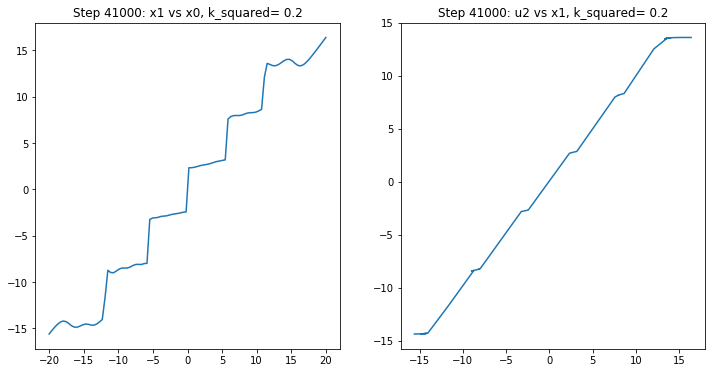

-----Step: 42000
--------Train Cost: 0.6082557439804077 Train Cost Stage1: 0.3812233507633209 Train Cost Stage2: 0.2270323783159256 
--------Test Cost: 0.5836843733570977 Test Cost_Stage1: 0.38527053575146153, Test_Cost_Stage2: 0.19841383959831846
--------14.968448638916016 seconds ---


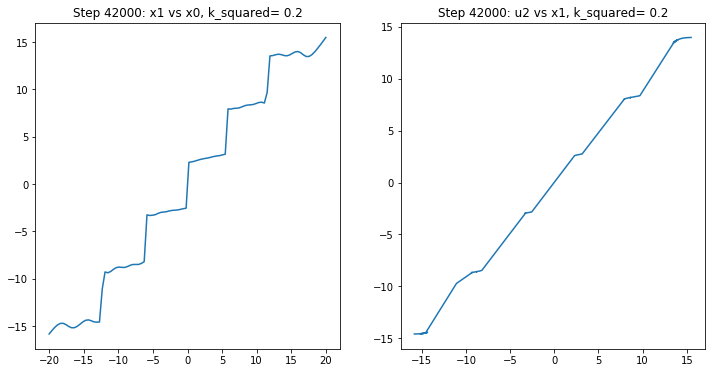

-----Step: 43000
--------Train Cost: 0.6161702275276184 Train Cost Stage1: 0.3591279685497284 Train Cost Stage2: 0.25704225897789 
--------Test Cost: 0.5869069381149425 Test Cost_Stage1: 0.3657343467086139, Test_Cost_Stage2: 0.22117259129892536
--------15.044052600860596 seconds ---


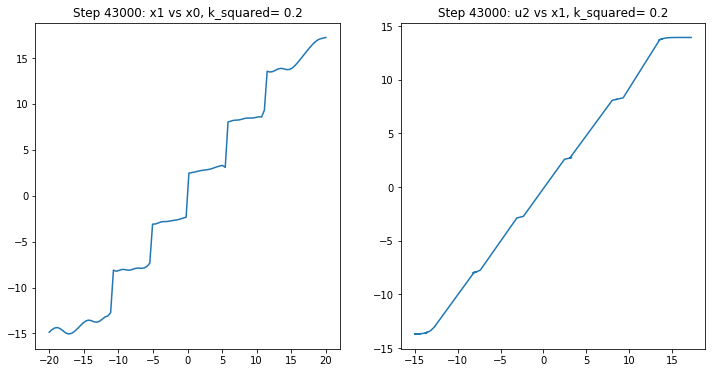

-----Step: 44000
--------Train Cost: 0.6174842119216919 Train Cost Stage1: 0.3597152829170227 Train Cost Stage2: 0.2577689588069916 
--------Test Cost: 0.6616873798908001 Test Cost_Stage1: 0.3475993536557807, Test_Cost_Stage2: 0.31408802829229227
--------14.805969953536987 seconds ---


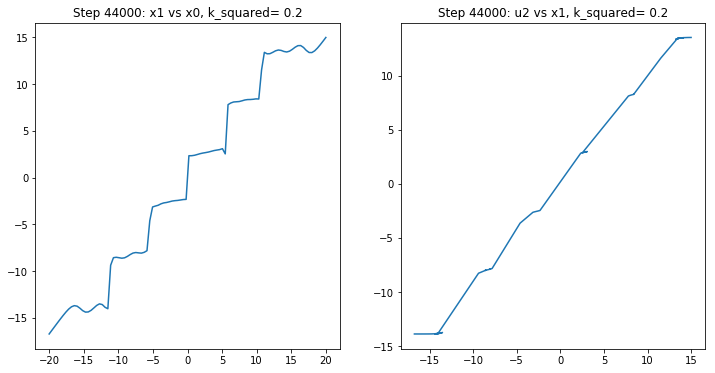

-----Step: 45000
--------Train Cost: 0.5936367511749268 Train Cost Stage1: 0.3708895146846771 Train Cost Stage2: 0.22274723649024963 
--------Test Cost: 0.6098317692335302 Test Cost_Stage1: 0.3560776926644804, Test_Cost_Stage2: 0.25375407667756156
--------15.429388523101807 seconds ---


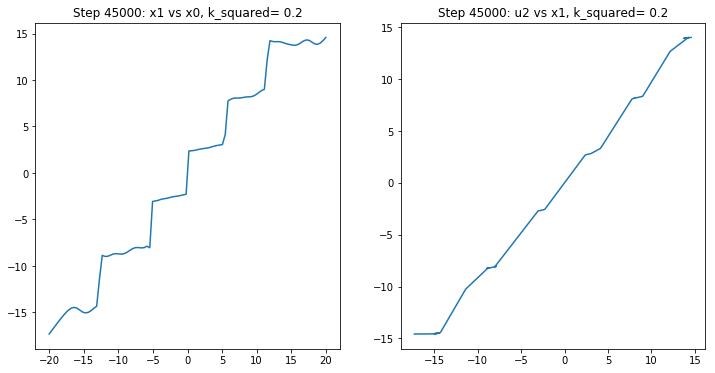

-----Step: 46000
--------Train Cost: 0.5963108539581299 Train Cost Stage1: 0.3509000539779663 Train Cost Stage2: 0.2454107701778412 
--------Test Cost: 0.5719213141464784 Test Cost_Stage1: 0.36247365606117354, Test_Cost_Stage2: 0.2094476358729627
--------15.059821844100952 seconds ---


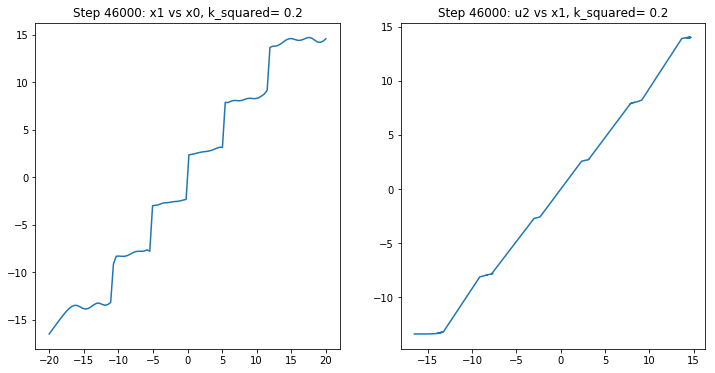

-----Step: 47000
--------Train Cost: 0.5654144883155823 Train Cost Stage1: 0.36464178562164307 Train Cost Stage2: 0.2007727026939392 
--------Test Cost: 0.5836657547231976 Test Cost_Stage1: 0.36342004190426164, Test_Cost_Stage2: 0.22024570067079924
--------15.431949138641357 seconds ---


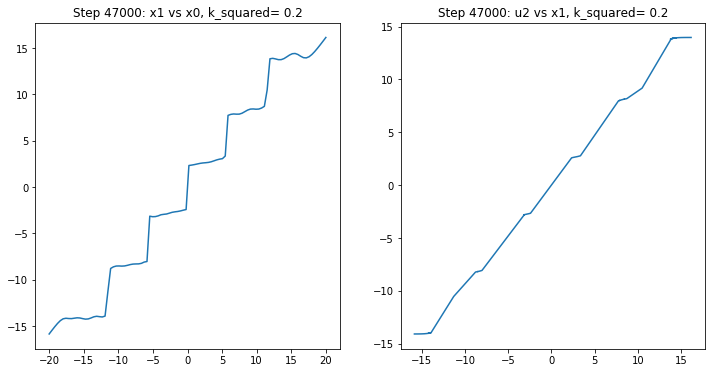

-----Step: 48000
--------Train Cost: 0.6015954613685608 Train Cost Stage1: 0.3590550422668457 Train Cost Stage2: 0.2425404042005539 
--------Test Cost: 0.6282818343259259 Test Cost_Stage1: 0.36347541628233493, Test_Cost_Stage2: 0.26480641546150285
--------15.463838815689087 seconds ---


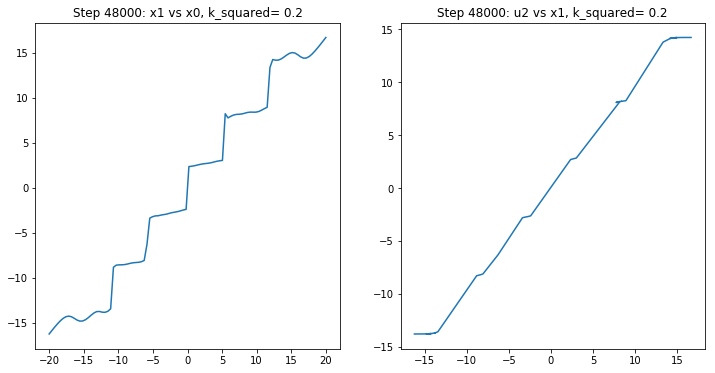

-----Step: 49000
--------Train Cost: 0.6246792674064636 Train Cost Stage1: 0.3568897843360901 Train Cost Stage2: 0.26778948307037354 
--------Test Cost: 0.6205284905947042 Test Cost_Stage1: 0.3567107890132791, Test_Cost_Stage2: 0.26381771847618707
--------14.959941387176514 seconds ---


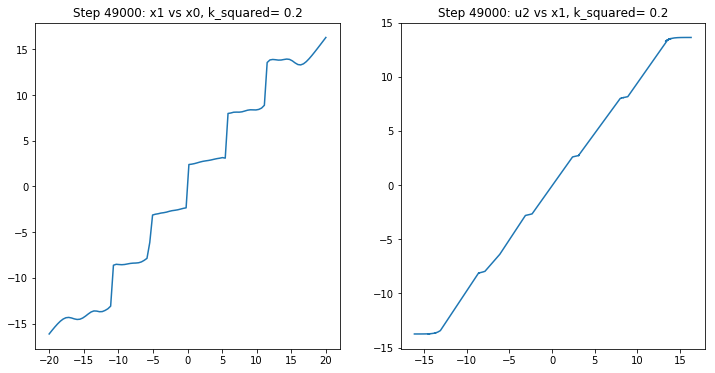

-----Step: 50000
--------Train Cost: 0.598125696182251 Train Cost Stage1: 0.3487671911716461 Train Cost Stage2: 0.24935849010944366 
--------Test Cost: 0.6282507995215433 Test Cost_Stage1: 0.33716478571605707, Test_Cost_Stage2: 0.2910860241912649
--------14.913508176803589 seconds ---


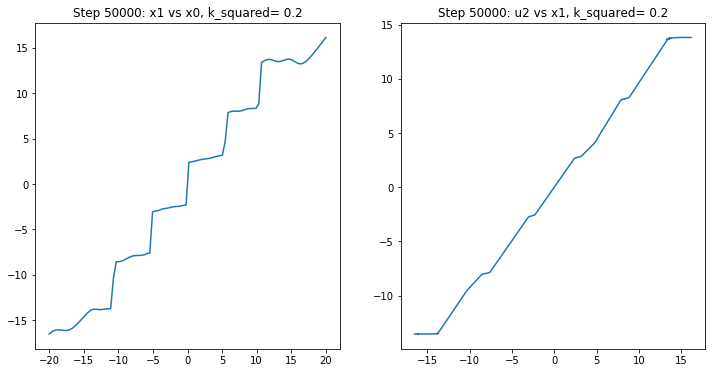

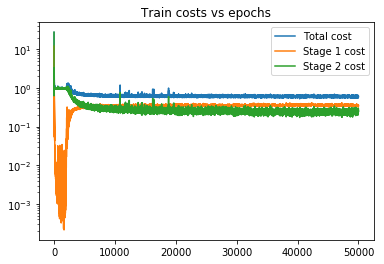

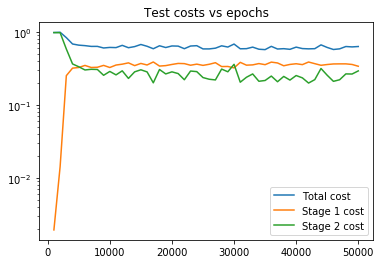

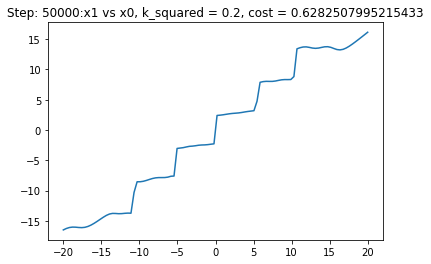

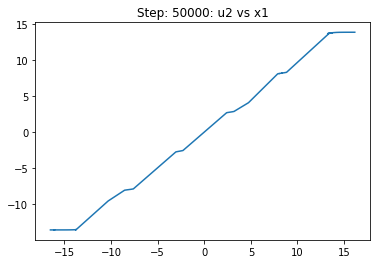

ls1_hu:150,sigmoid,nl:1,ls2_hu:1,identity,nl:1,ls3_hu:30,sigmoid,nl:1,ls4_hu:1,identity,nl:1,k_squared:0.5,lr:0.2,1,me:50000,bsz:10000,std_x0:5.0,std_z:1.0,Adam,krf:0.5
Using glorot normal initializer for encoder/layer1/kernel:0
Using zeros initializer for encoder/layer1/bias:0
Using glorot normal initializer for encoder/layer2/kernel:0
Using zeros initializer for encoder/layer2/bias:0
Using glorot normal initializer for decoder/layer3/kernel:0
Using zeros initializer for decoder/layer3/bias:0
Using glorot normal initializer for decoder/layer4/kernel:0
Using zeros initializer for decoder/layer4/bias:0
Training...


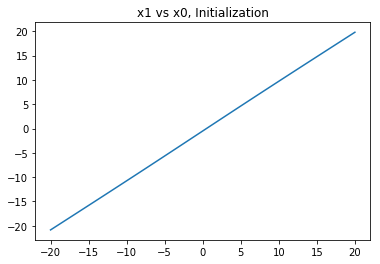

-----Step: 1000
--------Train Cost: 0.9370331764221191 Train Cost Stage1: 0.0016489243134856224 Train Cost Stage2: 0.9353842735290527 
--------Test Cost: 0.9858274212205064 Test Cost_Stage1: 0.011283145487784372, Test_Cost_Stage2: 0.9745442554912837
--------15.180509567260742 seconds ---


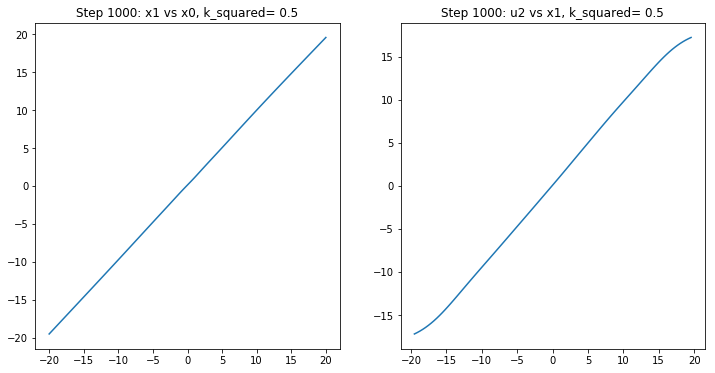

-----Step: 2000
--------Train Cost: 0.9763190746307373 Train Cost Stage1: 0.000258151296293363 Train Cost Stage2: 0.9760609269142151 
--------Test Cost: 0.9662376555591756 Test Cost_Stage1: 0.0005306688752060782, Test_Cost_Stage2: 0.9657069870117185
--------15.096160173416138 seconds ---


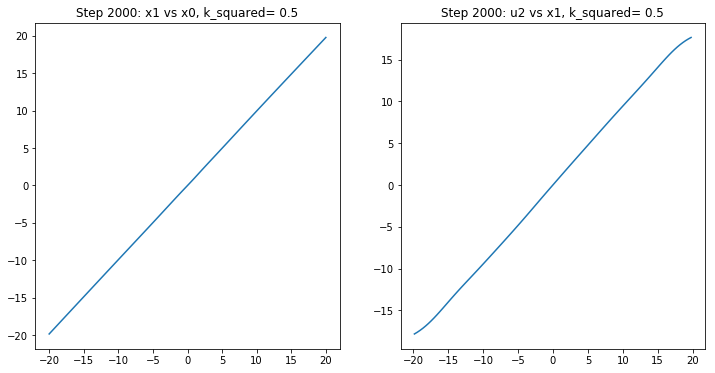

-----Step: 3000
--------Train Cost: 0.9524427652359009 Train Cost Stage1: 0.002132707741111517 Train Cost Stage2: 0.9503100514411926 
--------Test Cost: 0.9710149159564558 Test Cost_Stage1: 0.001201632423354069, Test_Cost_Stage2: 0.9698132671119216
--------15.260250568389893 seconds ---


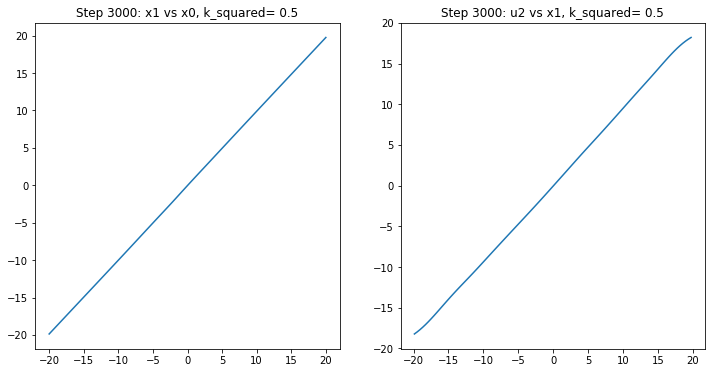

-----Step: 4000
--------Train Cost: 0.9886427521705627 Train Cost Stage1: 0.004170294385403395 Train Cost Stage2: 0.9844724535942078 
--------Test Cost: 0.9656886222243477 Test Cost_Stage1: 0.00037586062361823376, Test_Cost_Stage2: 0.9653127573116816
--------15.10603952407837 seconds ---


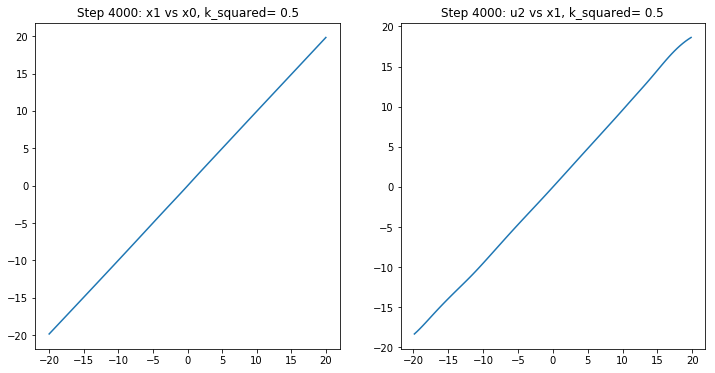

-----Step: 5000
--------Train Cost: 0.9816054701805115 Train Cost Stage1: 0.0002628042711876333 Train Cost Stage2: 0.9813426733016968 
--------Test Cost: 0.9648471072351502 Test Cost_Stage1: 0.0007061927319378498, Test_Cost_Stage2: 0.9641409293920007
--------15.74981689453125 seconds ---


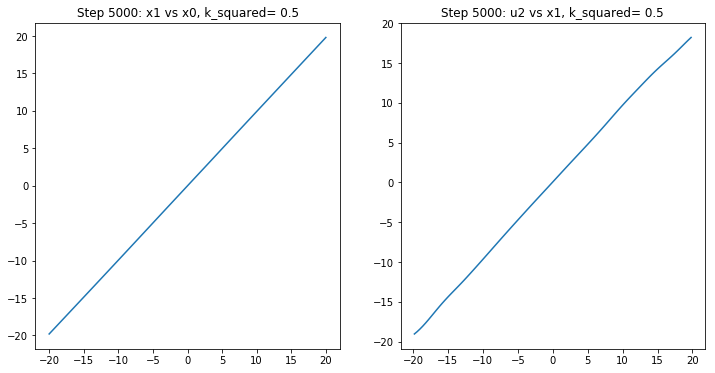

-----Step: 6000
--------Train Cost: 0.9690027832984924 Train Cost Stage1: 0.00014418840873986483 Train Cost Stage2: 0.9688585996627808 
--------Test Cost: 0.9668810247154918 Test Cost_Stage1: 0.00017274051137145563, Test_Cost_Stage2: 0.9667082827348461
--------14.991596460342407 seconds ---


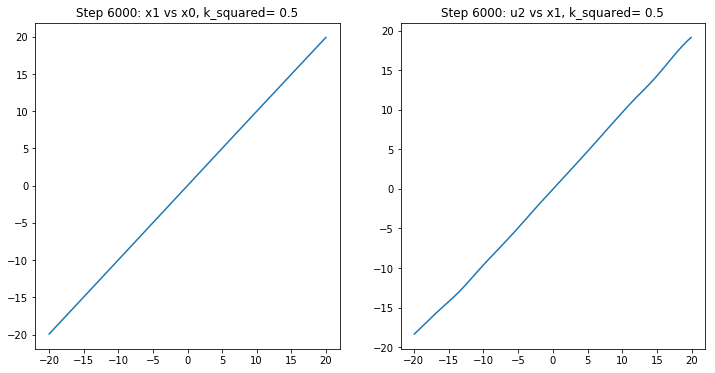

-----Step: 7000
--------Train Cost: 0.9631742835044861 Train Cost Stage1: 0.0002100261190207675 Train Cost Stage2: 0.9629642367362976 
--------Test Cost: 0.9714105857967785 Test Cost_Stage1: 0.00039734302127089036, Test_Cost_Stage2: 0.9710132583531192
--------14.805944204330444 seconds ---


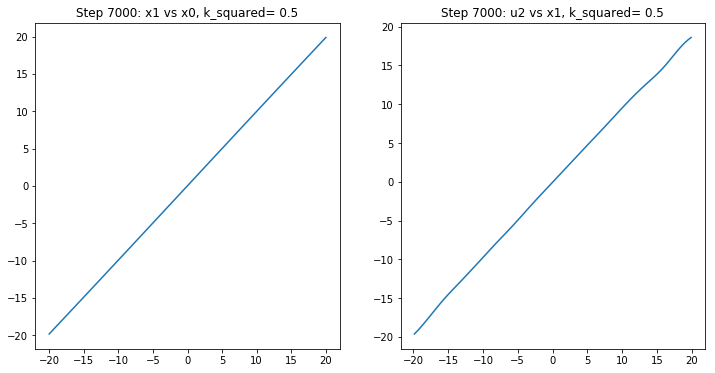

-----Step: 8000
--------Train Cost: 0.9393205642700195 Train Cost Stage1: 0.00012214570597279817 Train Cost Stage2: 0.9391984343528748 
--------Test Cost: 0.9656419917494583 Test Cost_Stage1: 0.00011094135966751915, Test_Cost_Stage2: 0.9655310588255914
--------15.130602598190308 seconds ---


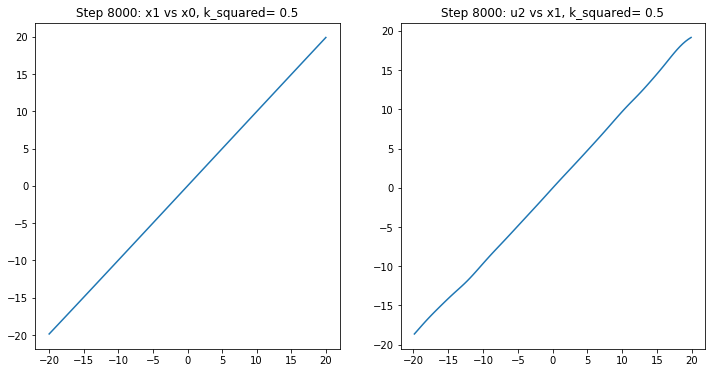

-----Step: 9000
--------Train Cost: 0.9868372678756714 Train Cost Stage1: 0.0001932344603119418 Train Cost Stage2: 0.9866440296173096 
--------Test Cost: 0.9793248693819607 Test Cost_Stage1: 0.0002298032732440189, Test_Cost_Stage2: 0.9790950393333944
--------11.652848958969116 seconds ---


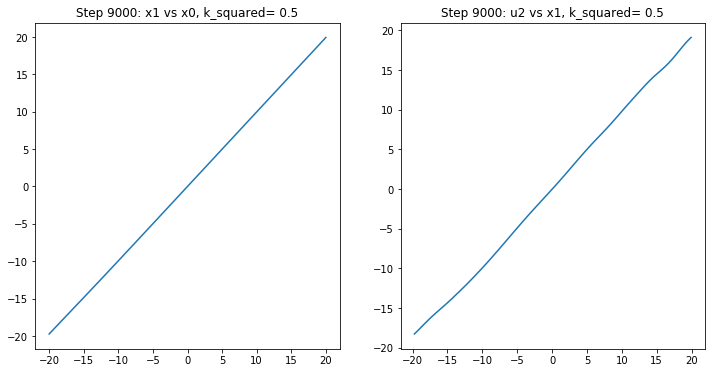

-----Step: 10000
--------Train Cost: 0.9835340976715088 Train Cost Stage1: 0.00017529874457977712 Train Cost Stage2: 0.9833588004112244 
--------Test Cost: 0.9697368072359647 Test Cost_Stage1: 0.00017357063008569635, Test_Cost_Stage2: 0.9695632399242153
--------10.418407201766968 seconds ---


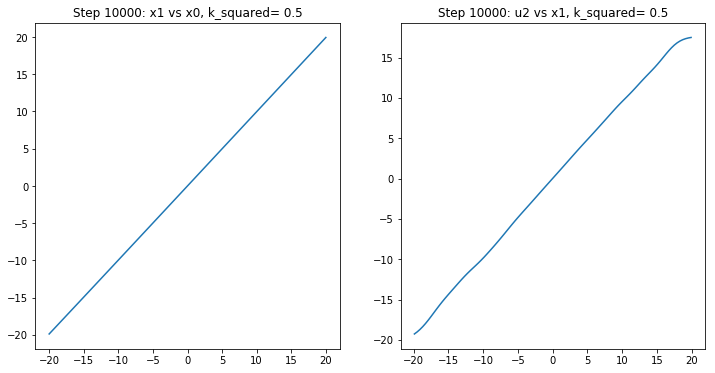

-----Step: 11000
--------Train Cost: 0.9817694425582886 Train Cost Stage1: 0.00020815737661905587 Train Cost Stage2: 0.9815613031387329 
--------Test Cost: 0.9666143210091938 Test Cost_Stage1: 0.0002444962867726593, Test_Cost_Stage2: 0.9663698009145368
--------9.799217939376831 seconds ---


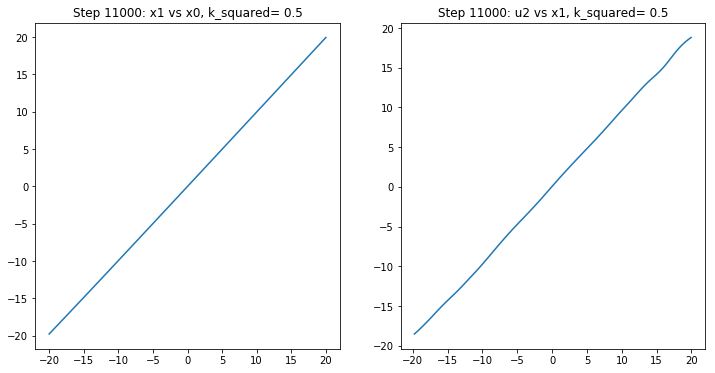

-----Step: 12000
--------Train Cost: 0.980558454990387 Train Cost Stage1: 0.00019301702559459955 Train Cost Stage2: 0.9803654551506042 
--------Test Cost: 0.963895522821412 Test Cost_Stage1: 0.00017389565185461483, Test_Cost_Stage2: 0.9637216353816417
--------9.874306678771973 seconds ---


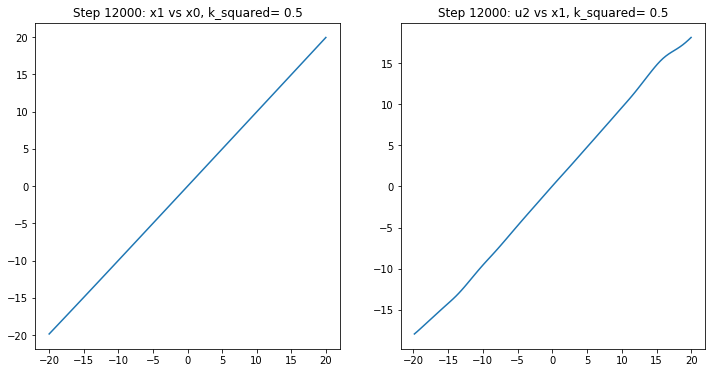

-----Step: 13000
--------Train Cost: 0.9924549460411072 Train Cost Stage1: 0.17924852669239044 Train Cost Stage2: 0.8132064342498779 
--------Test Cost: 0.9795610760277874 Test Cost_Stage1: 0.17232914165720675, Test_Cost_Stage2: 0.8072319319699145
--------9.726663589477539 seconds ---


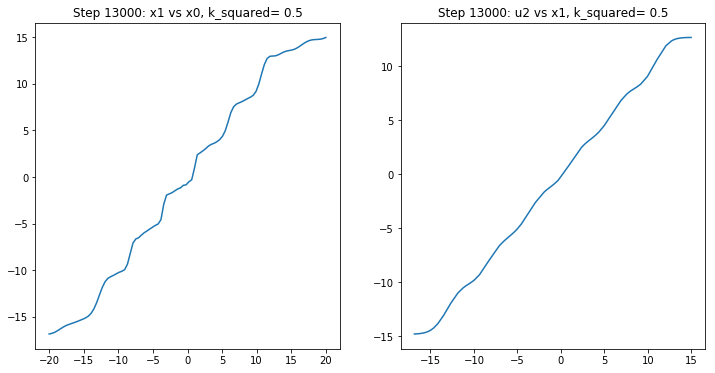

-----Step: 14000
--------Train Cost: 0.9724194407463074 Train Cost Stage1: 0.20031730830669403 Train Cost Stage2: 0.7721021175384521 
--------Test Cost: 0.9789077432439159 Test Cost_Stage1: 0.1785724032998548, Test_Cost_Stage2: 0.800335341642188
--------10.506855726242065 seconds ---


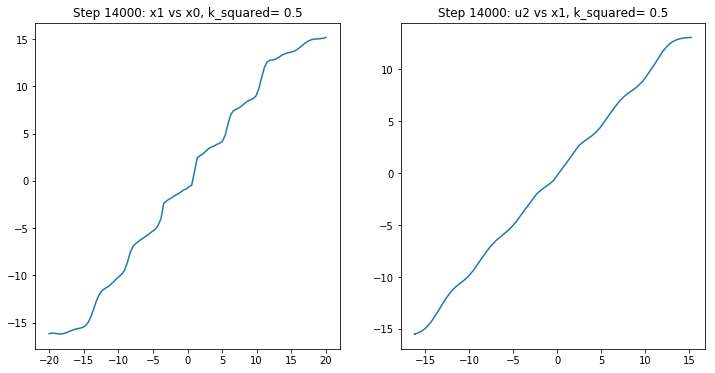

-----Step: 15000
--------Train Cost: 0.999763011932373 Train Cost Stage1: 0.19973941147327423 Train Cost Stage2: 0.80002361536026 
--------Test Cost: 0.9819383073972914 Test Cost_Stage1: 0.18108116181921535, Test_Cost_Stage2: 0.8008571683857393
--------10.310076475143433 seconds ---


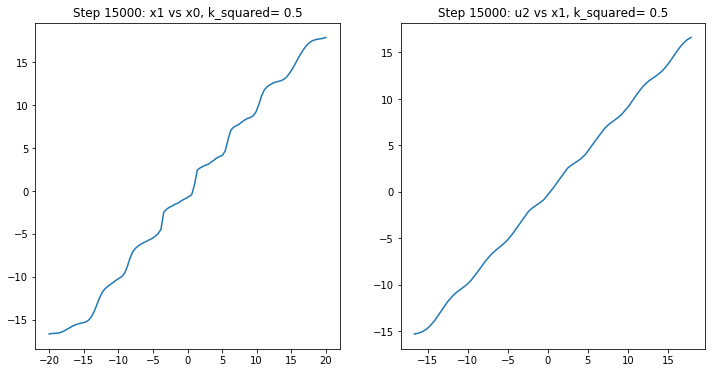

-----Step: 16000
--------Train Cost: 0.9962213039398193 Train Cost Stage1: 0.21972087025642395 Train Cost Stage2: 0.7765004634857178 
--------Test Cost: 0.9817400064200732 Test Cost_Stage1: 0.23389887461635267, Test_Cost_Stage2: 0.7478411546843626
--------10.52130126953125 seconds ---


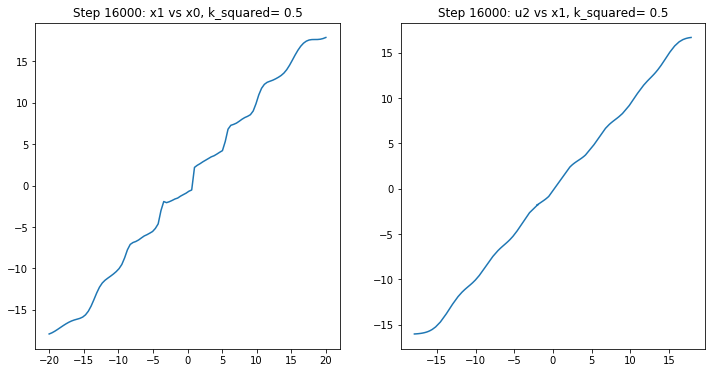

-----Step: 17000
--------Train Cost: 0.976539134979248 Train Cost Stage1: 0.21006089448928833 Train Cost Stage2: 0.7664782404899597 
--------Test Cost: 0.9581400922427329 Test Cost_Stage1: 0.22384964934853924, Test_Cost_Stage2: 0.7342904734078632
--------10.162442922592163 seconds ---


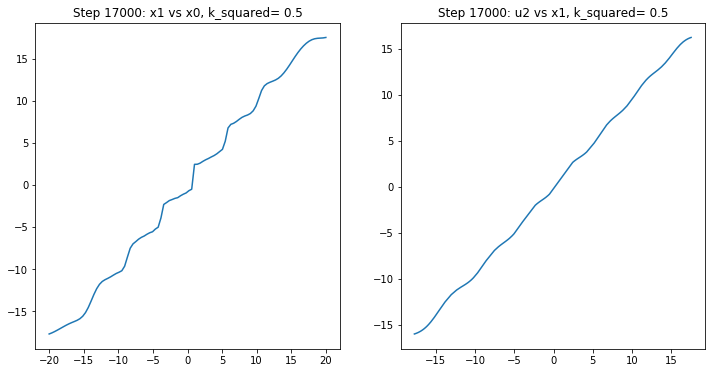

-----Step: 18000
--------Train Cost: 1.0417723655700684 Train Cost Stage1: 0.2641758322715759 Train Cost Stage2: 0.7775965929031372 
--------Test Cost: 1.0275610704131921 Test Cost_Stage1: 0.24429981510182472, Test_Cost_Stage2: 0.7832612367773099
--------9.530059337615967 seconds ---


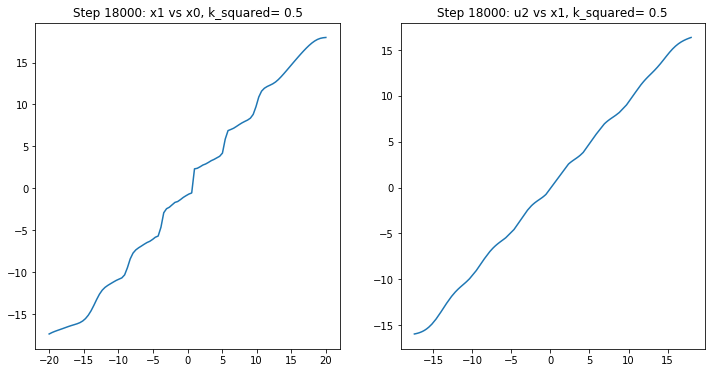

-----Step: 19000
--------Train Cost: 0.9676687717437744 Train Cost Stage1: 0.20581647753715515 Train Cost Stage2: 0.7618523240089417 
--------Test Cost: 0.9799939121796033 Test Cost_Stage1: 0.2045235561943074, Test_Cost_Stage2: 0.7754703552812775
--------10.200236082077026 seconds ---


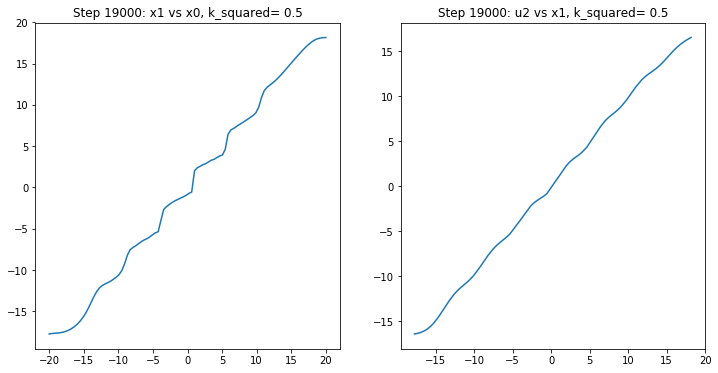

-----Step: 20000
--------Train Cost: 0.9750730991363525 Train Cost Stage1: 0.20828334987163544 Train Cost Stage2: 0.7667897343635559 
--------Test Cost: 0.956343710490649 Test Cost_Stage1: 0.20745488773112908, Test_Cost_Stage2: 0.7488888026340242
--------9.980350017547607 seconds ---


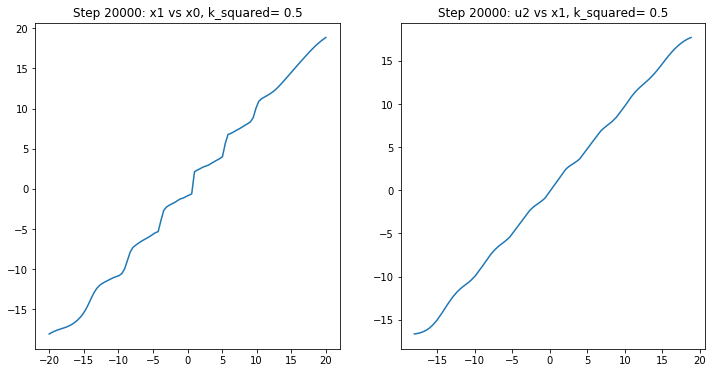

-----Step: 21000
--------Train Cost: 0.9785303473472595 Train Cost Stage1: 0.2391890436410904 Train Cost Stage2: 0.7393413186073303 
--------Test Cost: 0.9752037484891134 Test Cost_Stage1: 0.22937096455222095, Test_Cost_Stage2: 0.745832779706616
--------10.211067914962769 seconds ---


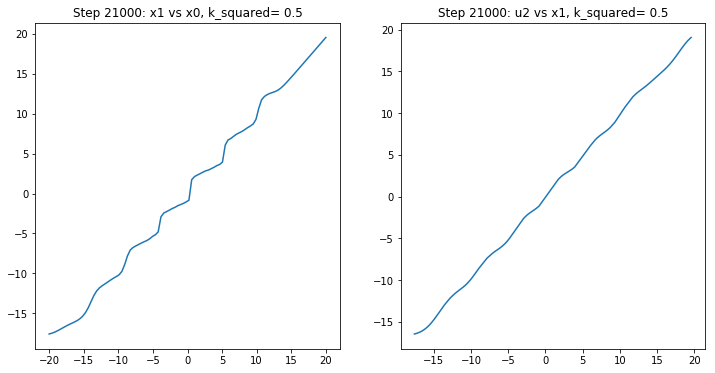

-----Step: 22000
--------Train Cost: 0.9514027833938599 Train Cost Stage1: 0.22941794991493225 Train Cost Stage2: 0.72198486328125 
--------Test Cost: 0.9590505323614871 Test Cost_Stage1: 0.23363189213641838, Test_Cost_Stage2: 0.7254186212062067
--------10.057170867919922 seconds ---


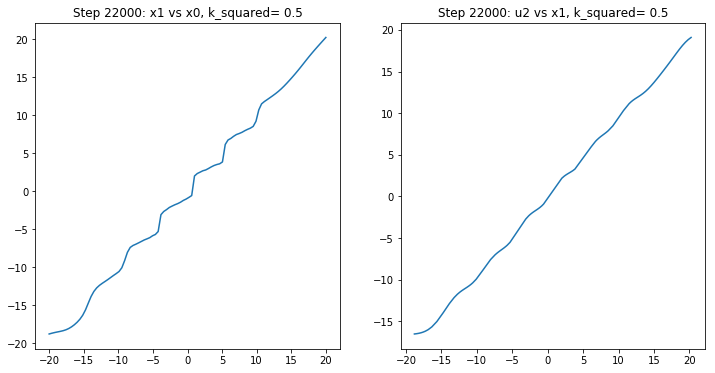

-----Step: 23000
--------Train Cost: 0.9612098932266235 Train Cost Stage1: 0.2482256144285202 Train Cost Stage2: 0.7129842638969421 
--------Test Cost: 0.9704723717567709 Test Cost_Stage1: 0.22244990450563024, Test_Cost_Stage2: 0.7480224650657812
--------9.953081846237183 seconds ---


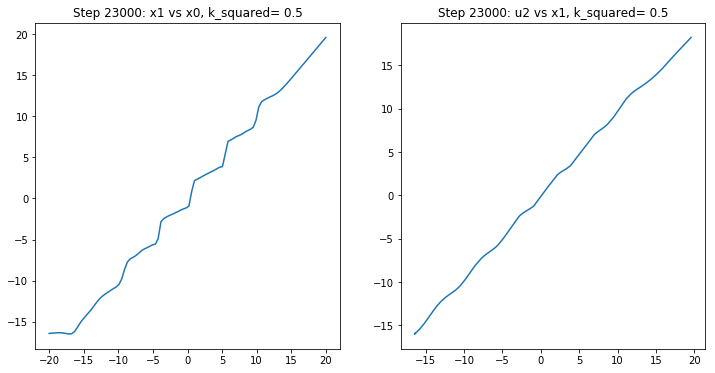

-----Step: 24000
--------Train Cost: 0.9499598145484924 Train Cost Stage1: 0.24685971438884735 Train Cost Stage2: 0.7031000852584839 
--------Test Cost: 0.9543032371368599 Test Cost_Stage1: 0.24310680508060628, Test_Cost_Stage2: 0.7111964104358293
--------9.744478464126587 seconds ---


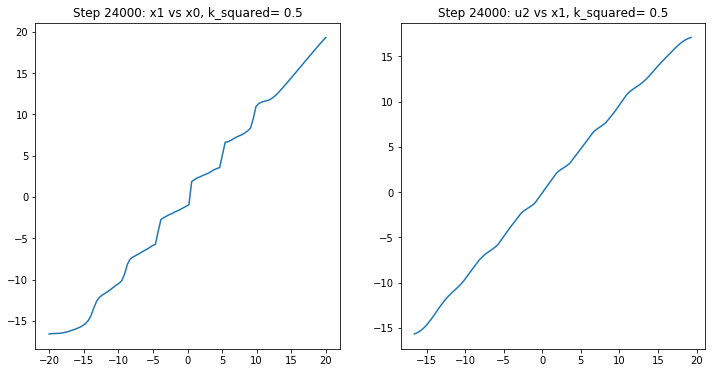

-----Step: 25000
--------Train Cost: 0.9709053039550781 Train Cost Stage1: 0.27117273211479187 Train Cost Stage2: 0.6997325420379639 
--------Test Cost: 0.9638156328561063 Test Cost_Stage1: 0.2885531210898425, Test_Cost_Stage2: 0.6752625154674938
--------9.75933027267456 seconds ---


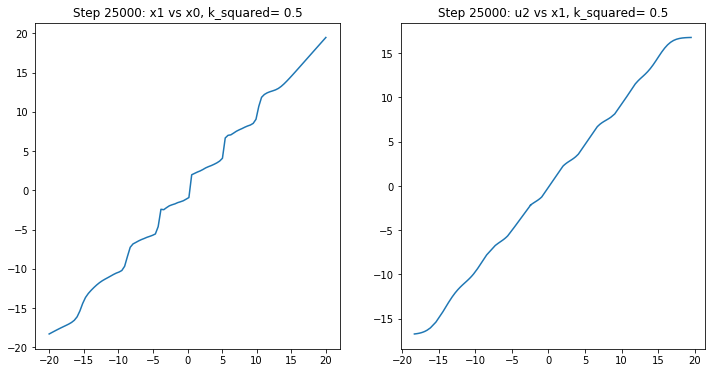

-----Step: 26000
--------Train Cost: 0.9525079727172852 Train Cost Stage1: 0.2690180838108063 Train Cost Stage2: 0.6834898591041565 
--------Test Cost: 0.9503287994628579 Test Cost_Stage1: 0.27196618949498474, Test_Cost_Stage2: 0.6783625905386972
--------9.852934122085571 seconds ---


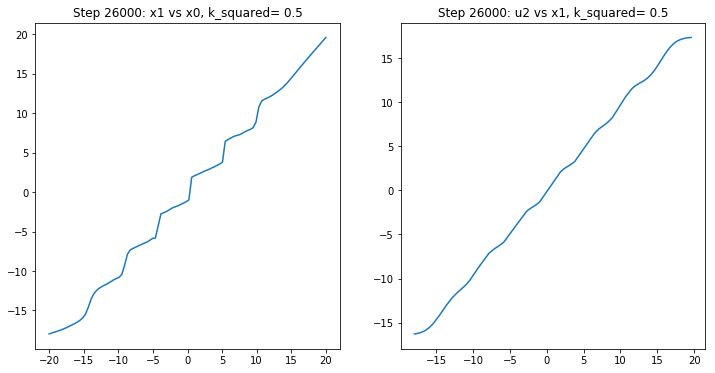

-----Step: 27000
--------Train Cost: 0.9633983969688416 Train Cost Stage1: 0.27514147758483887 Train Cost Stage2: 0.6882569193840027 
--------Test Cost: 0.9442756291071506 Test Cost_Stage1: 0.2875382703062708, Test_Cost_Stage2: 0.6567373636992697
--------10.58829927444458 seconds ---


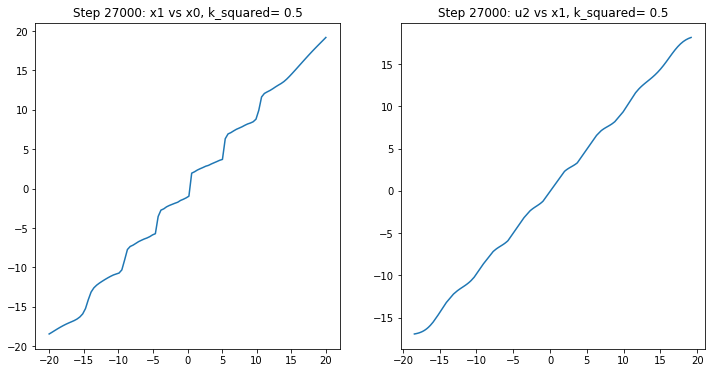

-----Step: 28000
--------Train Cost: 0.9597161412239075 Train Cost Stage1: 0.26556509733200073 Train Cost Stage2: 0.6941510438919067 
--------Test Cost: 0.9418790756363064 Test Cost_Stage1: 0.27690617899948744, Test_Cost_Stage2: 0.6649728820118515
--------9.814716339111328 seconds ---


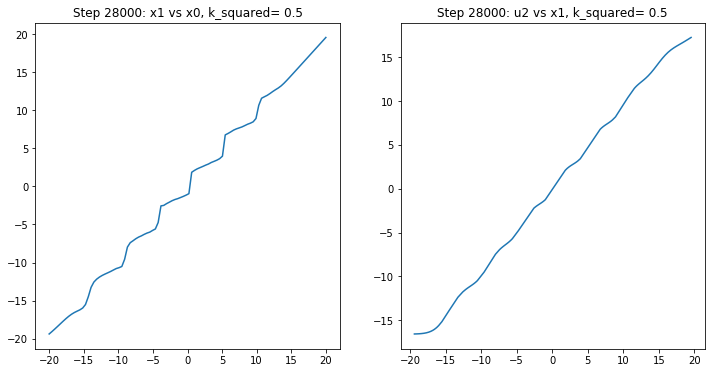

-----Step: 29000
--------Train Cost: 0.999897301197052 Train Cost Stage1: 0.27555328607559204 Train Cost Stage2: 0.72434401512146 
--------Test Cost: 0.952130294818649 Test Cost_Stage1: 0.28197291746929565, Test_Cost_Stage2: 0.6701573784007114
--------9.779555082321167 seconds ---


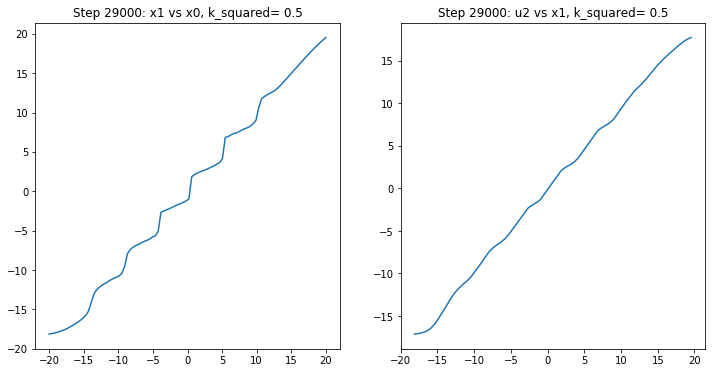

-----Step: 30000
--------Train Cost: 0.9840269088745117 Train Cost Stage1: 0.27217748761177063 Train Cost Stage2: 0.7118493914604187 
--------Test Cost: 0.9493430706708694 Test Cost_Stage1: 0.27478112689475687, Test_Cost_Stage2: 0.6745619506932188
--------9.596026420593262 seconds ---


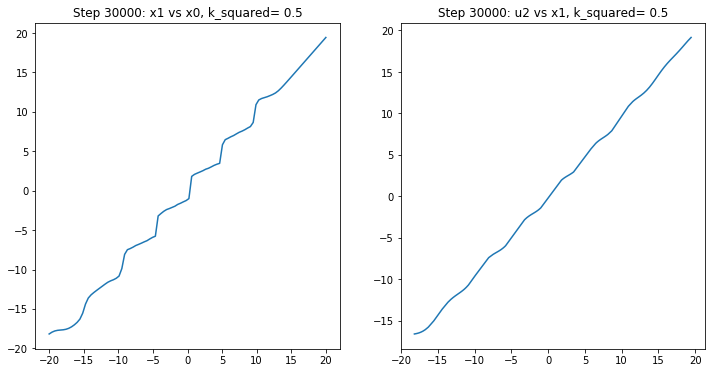

-----Step: 31000
--------Train Cost: 0.990303635597229 Train Cost Stage1: 0.28062939643859863 Train Cost Stage2: 0.7096742391586304 
--------Test Cost: 0.966432234745092 Test Cost_Stage1: 0.28355565851261183, Test_Cost_Stage2: 0.6828765722240797
--------10.4010169506073 seconds ---


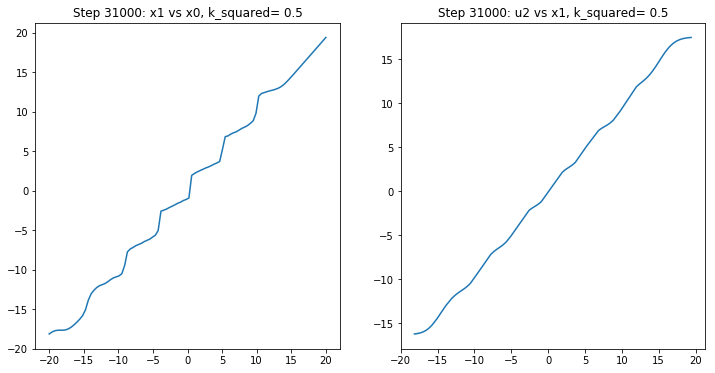

-----Step: 32000
--------Train Cost: 0.9857069253921509 Train Cost Stage1: 0.28153374791145325 Train Cost Stage2: 0.7041731476783752 
--------Test Cost: 0.9464496455738206 Test Cost_Stage1: 0.285273749479236, Test_Cost_Stage2: 0.6611759081051458
--------10.072388410568237 seconds ---


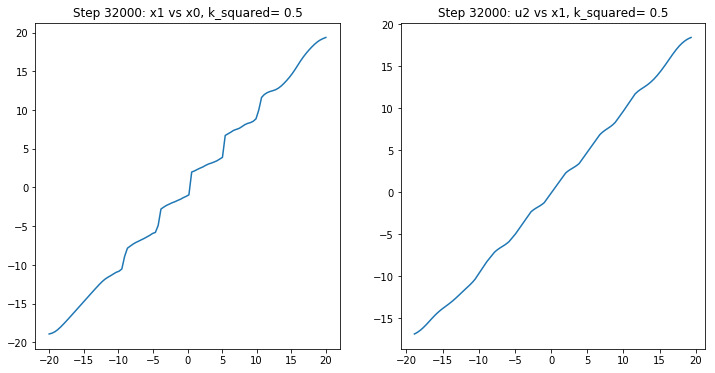

-----Step: 33000
--------Train Cost: 0.9612681865692139 Train Cost Stage1: 0.2662288546562195 Train Cost Stage2: 0.6950393319129944 
--------Test Cost: 0.9664584984239807 Test Cost_Stage1: 0.23407359456708465, Test_Cost_Stage2: 0.7323849228782562
--------9.98462963104248 seconds ---


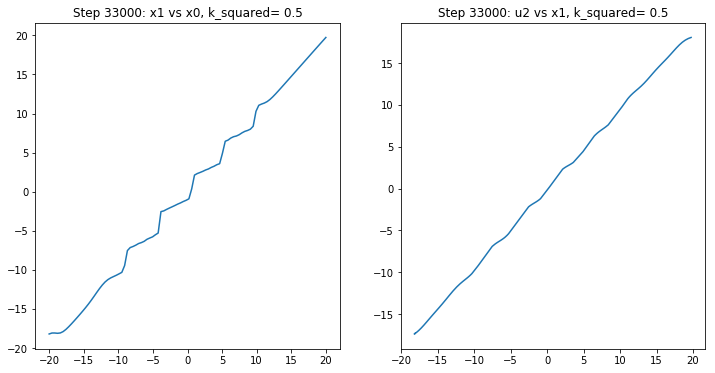

-----Step: 34000
--------Train Cost: 0.9548646211624146 Train Cost Stage1: 0.302677720785141 Train Cost Stage2: 0.6521868705749512 
--------Test Cost: 0.9580298861914083 Test Cost_Stage1: 0.27685963494002225, Test_Cost_Stage2: 0.6811702562181601
--------9.908507585525513 seconds ---


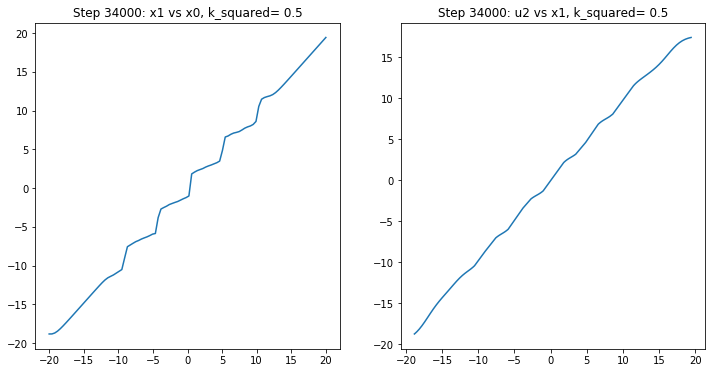

-----Step: 35000
--------Train Cost: 0.9431021213531494 Train Cost Stage1: 0.29243203997612 Train Cost Stage2: 0.6506701111793518 
--------Test Cost: 0.9510209157675305 Test Cost_Stage1: 0.3013434400680114, Test_Cost_Stage2: 0.6496774790388234
--------10.41960597038269 seconds ---


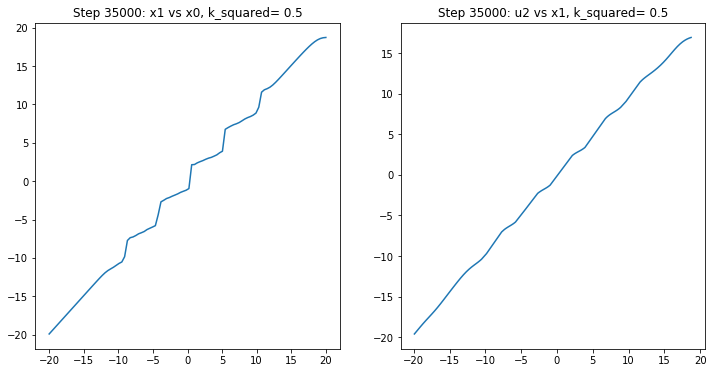

-----Step: 36000
--------Train Cost: 0.9426883459091187 Train Cost Stage1: 0.30359676480293274 Train Cost Stage2: 0.6390916109085083 
--------Test Cost: 0.9364344909723998 Test Cost_Stage1: 0.3219742794828124, Test_Cost_Stage2: 0.6144602168360285
--------9.998305082321167 seconds ---


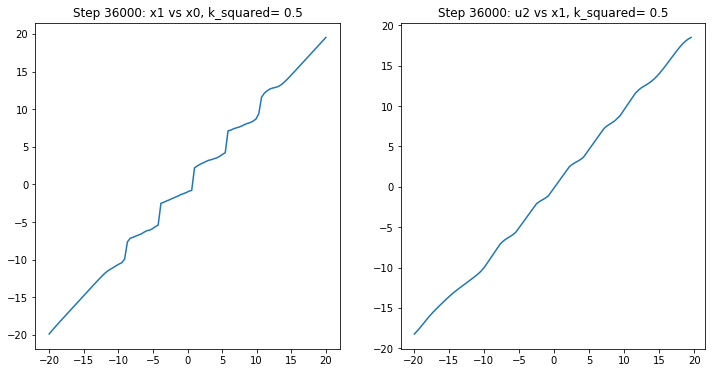

-----Step: 37000
--------Train Cost: 0.9648740291595459 Train Cost Stage1: 0.29347676038742065 Train Cost Stage2: 0.6713972687721252 
--------Test Cost: 0.9568588989420521 Test Cost_Stage1: 0.3011458558980939, Test_Cost_Stage2: 0.6557130474722269
--------11.138734340667725 seconds ---


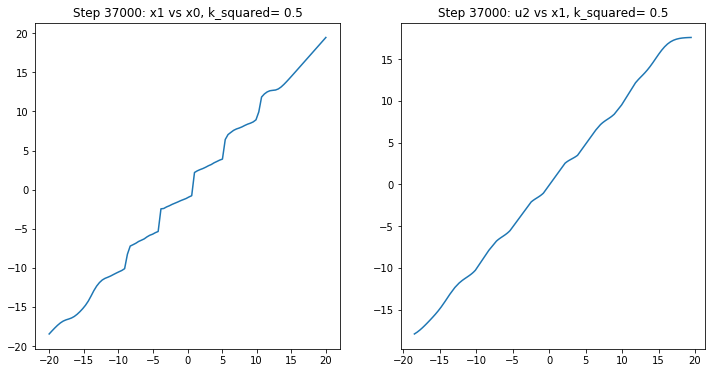

-----Step: 38000
--------Train Cost: 0.9270782470703125 Train Cost Stage1: 0.27223652601242065 Train Cost Stage2: 0.6548417210578918 
--------Test Cost: 0.956046442562787 Test Cost_Stage1: 0.2575780623722603, Test_Cost_Stage2: 0.6984683843396589
--------10.561673641204834 seconds ---


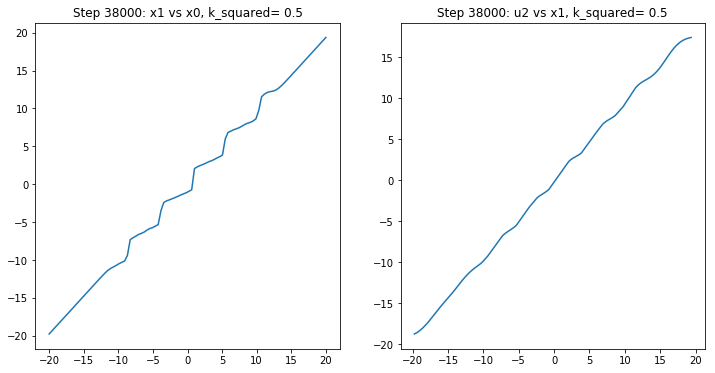

-----Step: 39000
--------Train Cost: 0.9428577423095703 Train Cost Stage1: 0.2964402139186859 Train Cost Stage2: 0.6464175581932068 
--------Test Cost: 0.9512534538354709 Test Cost_Stage1: 0.2903402614150366, Test_Cost_Stage2: 0.6609131969664949
--------9.733506679534912 seconds ---


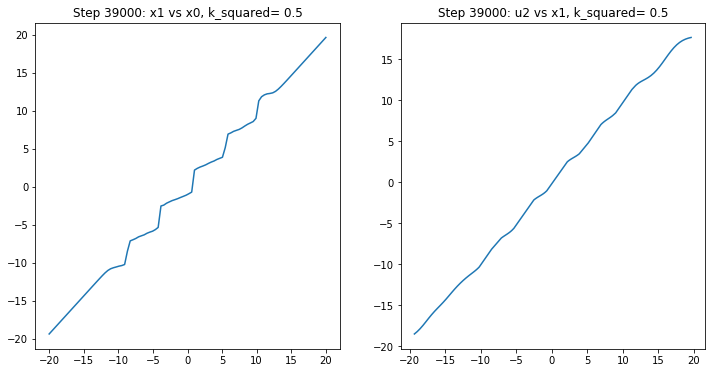

-----Step: 40000
--------Train Cost: 0.9924991130828857 Train Cost Stage1: 0.3023291826248169 Train Cost Stage2: 0.6901699304580688 
--------Test Cost: 0.9513957989564735 Test Cost_Stage1: 0.30149325043549857, Test_Cost_Stage2: 0.6499025346417215
--------10.196794748306274 seconds ---


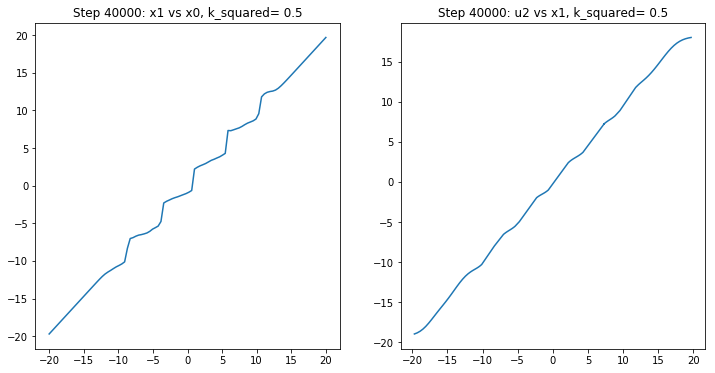

-----Step: 41000
--------Train Cost: 0.9541605710983276 Train Cost Stage1: 0.29022905230522156 Train Cost Stage2: 0.6639315485954285 
--------Test Cost: 0.9659608842203177 Test Cost_Stage1: 0.3031367687377872, Test_Cost_Stage2: 0.6628241066147151
--------10.033628940582275 seconds ---


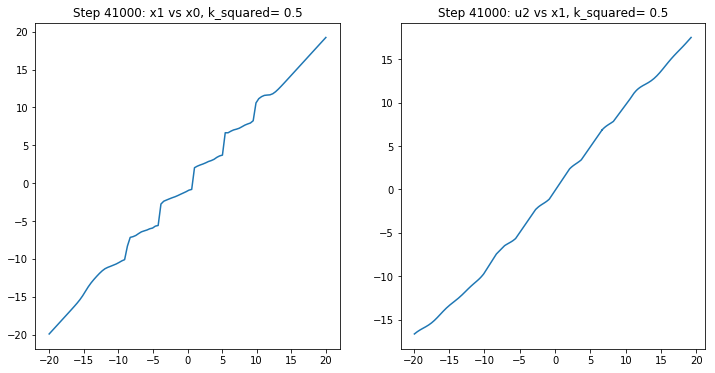

-----Step: 42000
--------Train Cost: 0.95484459400177 Train Cost Stage1: 0.2972067892551422 Train Cost Stage2: 0.6576378345489502 
--------Test Cost: 0.9505044818924909 Test Cost_Stage1: 0.300973580682082, Test_Cost_Stage2: 0.6495309077476052
--------9.693415641784668 seconds ---


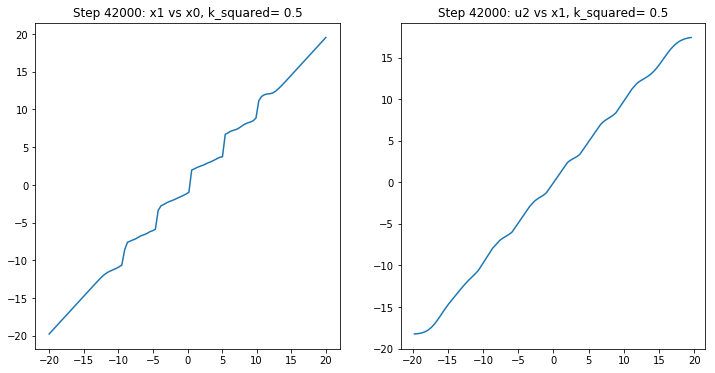

-----Step: 43000
--------Train Cost: 0.9381334185600281 Train Cost Stage1: 0.29395580291748047 Train Cost Stage2: 0.6441776156425476 
--------Test Cost: 0.9471685092091242 Test Cost_Stage1: 0.3048361283855421, Test_Cost_Stage2: 0.6423323650433079
--------10.289738416671753 seconds ---


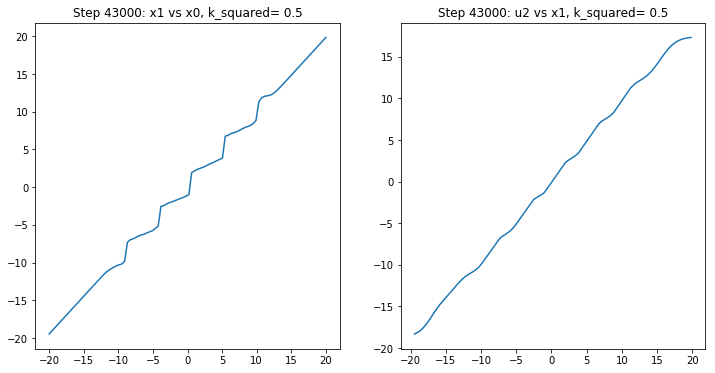

-----Step: 44000
--------Train Cost: 0.9579099416732788 Train Cost Stage1: 0.3054305911064148 Train Cost Stage2: 0.652479350566864 
--------Test Cost: 0.9526692091642404 Test Cost_Stage1: 0.30613635363268715, Test_Cost_Stage2: 0.646532844567385
--------9.723662614822388 seconds ---


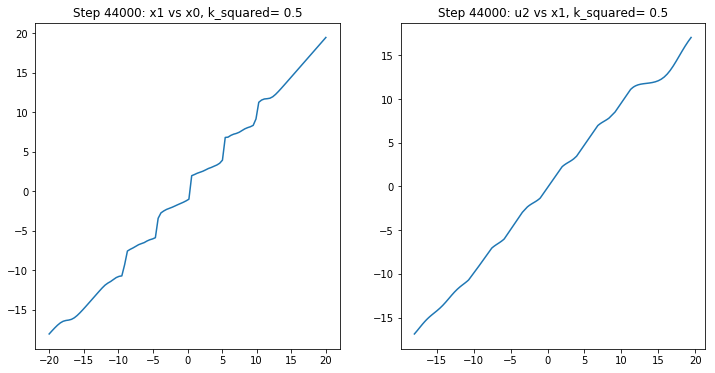

-----Step: 45000
--------Train Cost: 0.8980966806411743 Train Cost Stage1: 0.29813501238822937 Train Cost Stage2: 0.5999616980552673 
--------Test Cost: 0.9374200260823017 Test Cost_Stage1: 0.30229401128369665, Test_Cost_Stage2: 0.6351260091527341
--------10.273133993148804 seconds ---


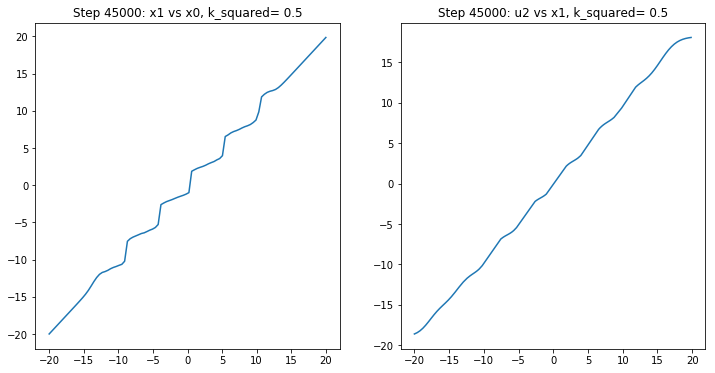

-----Step: 46000
--------Train Cost: 0.9678838849067688 Train Cost Stage1: 0.30628007650375366 Train Cost Stage2: 0.6616038084030151 
--------Test Cost: 0.9497422334939172 Test Cost_Stage1: 0.286268616275832, Test_Cost_Stage2: 0.6634736359425143
--------9.715687274932861 seconds ---


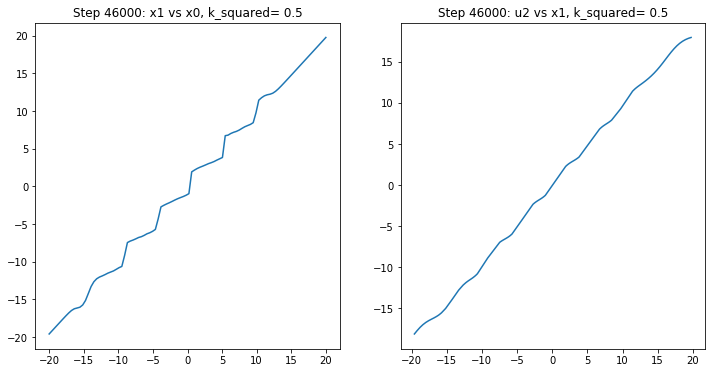

-----Step: 47000
--------Train Cost: 0.9353448152542114 Train Cost Stage1: 0.3147844672203064 Train Cost Stage2: 0.620560348033905 
--------Test Cost: 0.9530089238325619 Test Cost_Stage1: 0.29838656127003177, Test_Cost_Stage2: 0.654622355849964
--------10.345574378967285 seconds ---


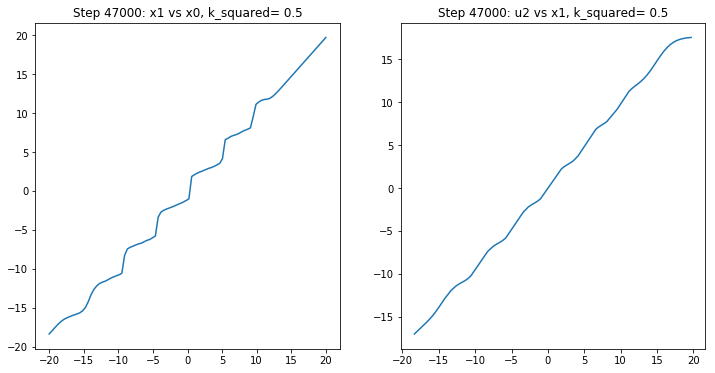

-----Step: 48000
--------Train Cost: 0.9712421894073486 Train Cost Stage1: 0.31789565086364746 Train Cost Stage2: 0.6533465385437012 
--------Test Cost: 0.953316330284503 Test Cost_Stage1: 0.3481067275686069, Test_Cost_Stage2: 0.6052095824019771
--------9.724486827850342 seconds ---


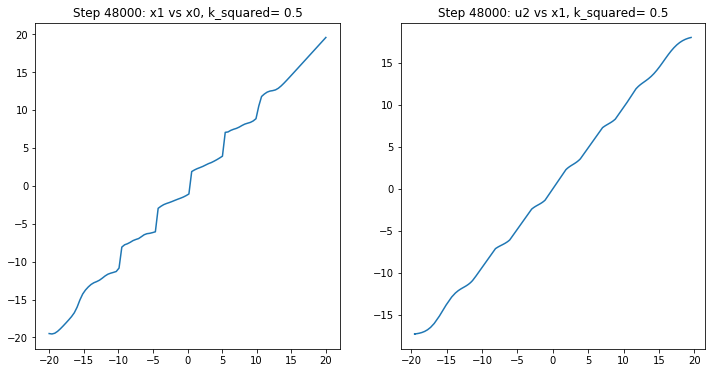

-----Step: 49000
--------Train Cost: 0.9863444566726685 Train Cost Stage1: 0.31253066658973694 Train Cost Stage2: 0.6738137602806091 
--------Test Cost: 0.9364794670665206 Test Cost_Stage1: 0.3263898416678841, Test_Cost_Stage2: 0.6100896172760986
--------9.920799255371094 seconds ---


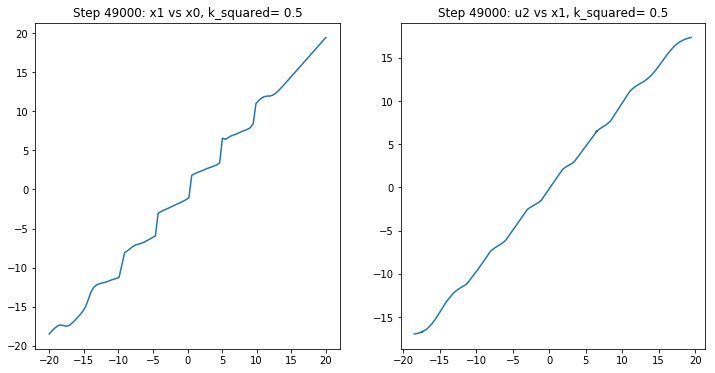

-----Step: 50000
--------Train Cost: 0.9352591633796692 Train Cost Stage1: 0.30278319120407104 Train Cost Stage2: 0.6324759721755981 
--------Test Cost: 0.9438381933681347 Test Cost_Stage1: 0.3063341797390569, Test_Cost_Stage2: 0.6375040076176827
--------10.368685245513916 seconds ---


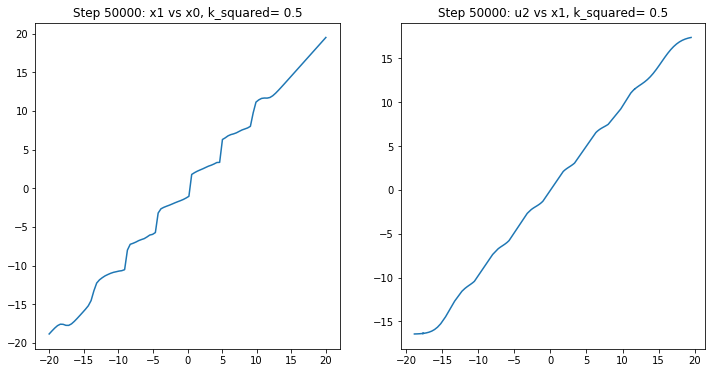

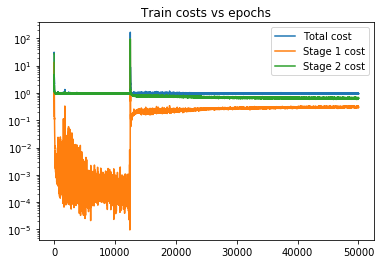

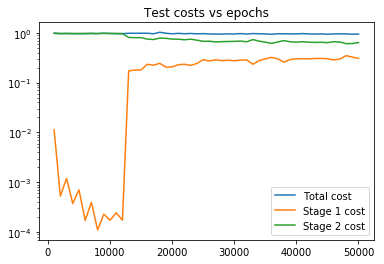

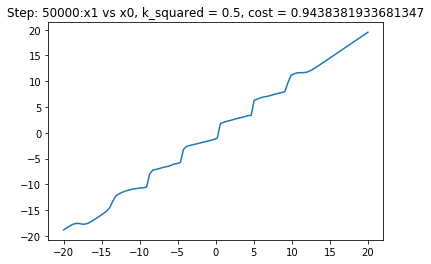

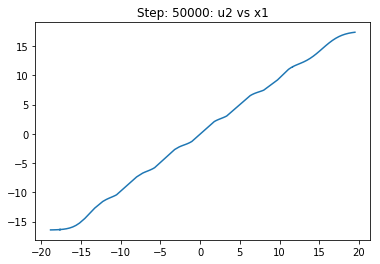

ls1_hu:150,sigmoid,nl:1,ls2_hu:1,identity,nl:1,ls3_hu:30,sigmoid,nl:1,ls4_hu:1,identity,nl:1,k_squared:0.6,lr:0.2,1,me:50000,bsz:10000,std_x0:5.0,std_z:1.0,Adam,krf:0.5
Using glorot normal initializer for encoder/layer1/kernel:0
Using zeros initializer for encoder/layer1/bias:0
Using glorot normal initializer for encoder/layer2/kernel:0
Using zeros initializer for encoder/layer2/bias:0
Using glorot normal initializer for decoder/layer3/kernel:0
Using zeros initializer for decoder/layer3/bias:0
Using glorot normal initializer for decoder/layer4/kernel:0
Using zeros initializer for decoder/layer4/bias:0
Training...


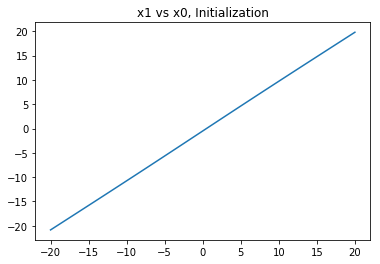

-----Step: 1000
--------Train Cost: 0.9337351322174072 Train Cost Stage1: 0.0008826898410916328 Train Cost Stage2: 0.9328524470329285 
--------Test Cost: 0.9825746171141737 Test Cost_Stage1: 0.0004146948988674711, Test_Cost_Stage2: 0.982159910974337
--------9.913227796554565 seconds ---


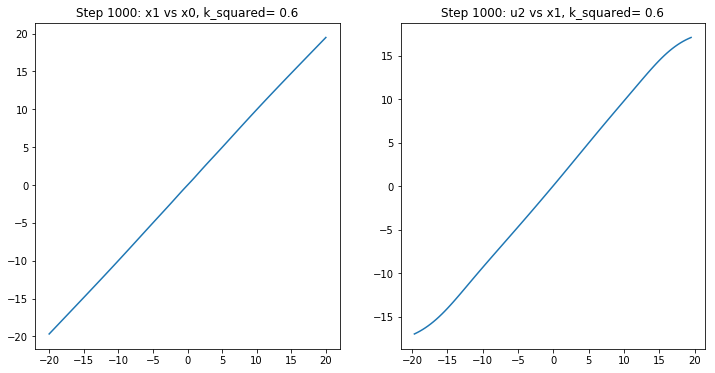

-----Step: 2000
--------Train Cost: 0.9886375069618225 Train Cost Stage1: 0.0017796913161873817 Train Cost Stage2: 0.9868578314781189 
--------Test Cost: 0.9700586080950896 Test Cost_Stage1: 0.0014198810901803027, Test_Cost_Stage2: 0.9686387334032823
--------9.833527565002441 seconds ---


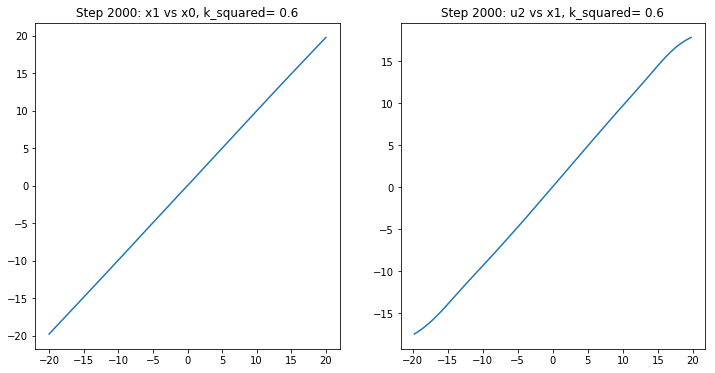

-----Step: 3000
--------Train Cost: 0.953055739402771 Train Cost Stage1: 0.0011852157767862082 Train Cost Stage2: 0.9518705010414124 
--------Test Cost: 0.9675661892982879 Test Cost_Stage1: 0.00035110935493955903, Test_Cost_Stage2: 0.9672150778031688
--------9.969574451446533 seconds ---


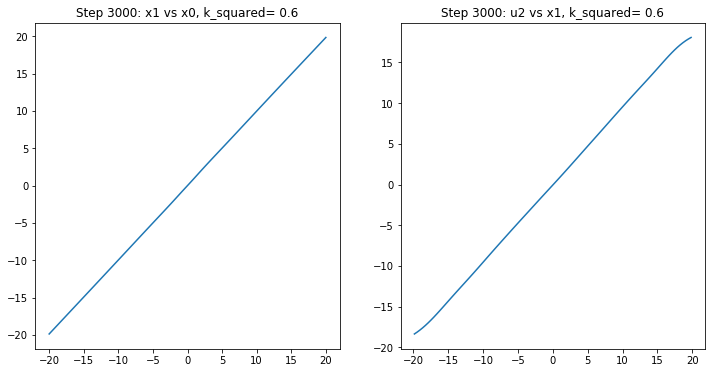

-----Step: 4000
--------Train Cost: 0.9977642297744751 Train Cost Stage1: 0.001791575225070119 Train Cost Stage2: 0.9959726333618164 
--------Test Cost: 0.971158328492151 Test Cost_Stage1: 0.0014881174716811017, Test_Cost_Stage2: 0.96967021907269
--------10.024304151535034 seconds ---


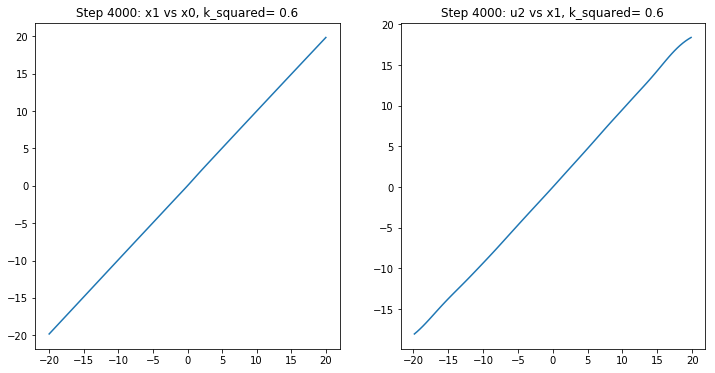

-----Step: 5000
--------Train Cost: 0.9827713966369629 Train Cost Stage1: 0.0011763429502025247 Train Cost Stage2: 0.9815950393676758 
--------Test Cost: 0.9651065226241261 Test Cost_Stage1: 0.0013212611911751486, Test_Cost_Stage2: 0.9637852813807506
--------9.745158672332764 seconds ---


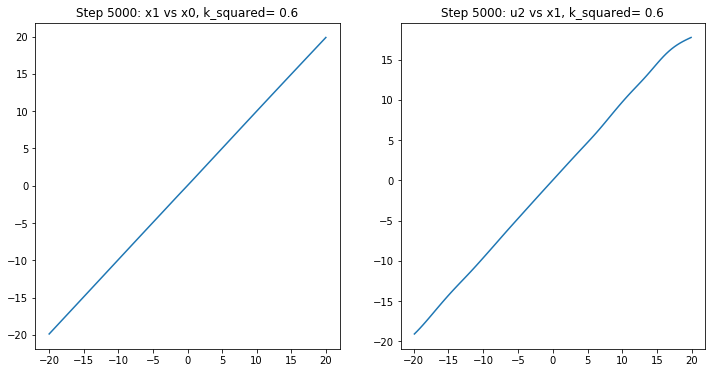

-----Step: 6000
--------Train Cost: 0.968161940574646 Train Cost Stage1: 0.0006017516134306788 Train Cost Stage2: 0.9675601720809937 
--------Test Cost: 0.9656168217306766 Test Cost_Stage1: 0.00016286575043417698, Test_Cost_Stage2: 0.9654539607793619
--------10.251249551773071 seconds ---


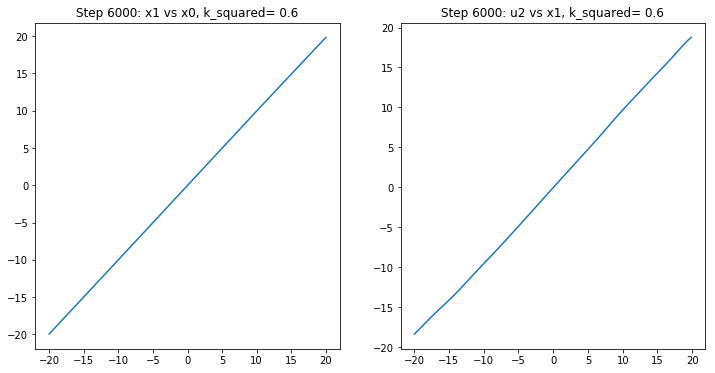

-----Step: 7000
--------Train Cost: 0.9635404348373413 Train Cost Stage1: 0.0004844159702770412 Train Cost Stage2: 0.9630560278892517 
--------Test Cost: 0.9657876263427448 Test Cost_Stage1: 0.00025025531122795157, Test_Cost_Stage2: 0.965537398213136
--------10.040252208709717 seconds ---


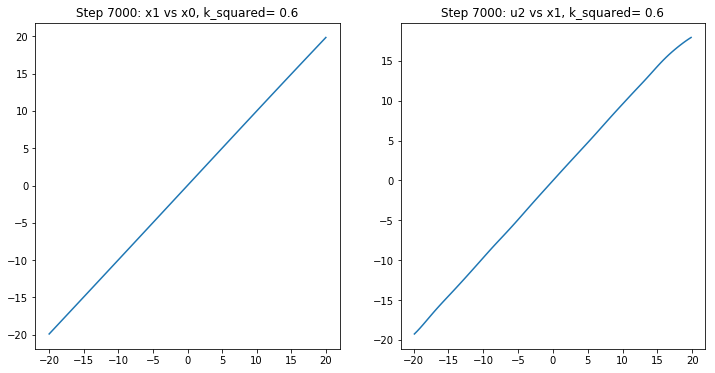

-----Step: 8000
--------Train Cost: 0.9380791187286377 Train Cost Stage1: 9.854843665380031e-05 Train Cost Stage2: 0.937980592250824 
--------Test Cost: 0.9686280441011331 Test Cost_Stage1: 0.00018184871368528928, Test_Cost_Stage2: 0.9684461900186512
--------9.736392259597778 seconds ---


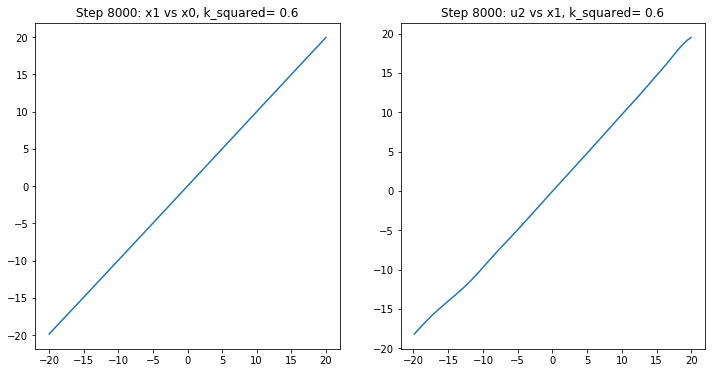

-----Step: 9000
--------Train Cost: 0.9891756176948547 Train Cost Stage1: 0.00022931367857381701 Train Cost Stage2: 0.9889463186264038 
--------Test Cost: 0.9728210085466358 Test Cost_Stage1: 0.00013970387713764193, Test_Cost_Stage2: 0.9726813050795946
--------10.027962446212769 seconds ---


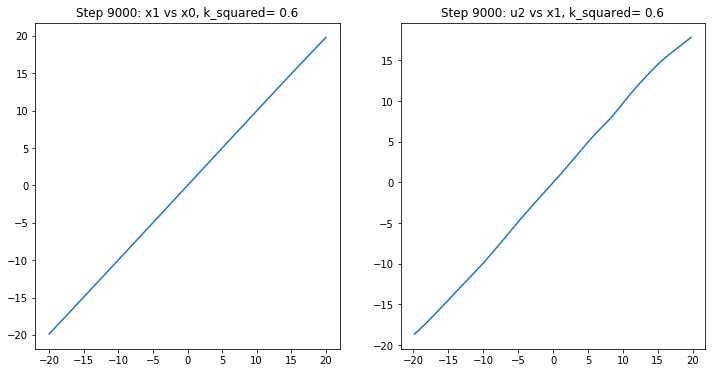

-----Step: 10000
--------Train Cost: 0.9847300052642822 Train Cost Stage1: 0.00021361303515732288 Train Cost Stage2: 0.9845163822174072 
--------Test Cost: 0.970196182408599 Test Cost_Stage1: 0.00015122301492428267, Test_Cost_Stage2: 0.9700449564472022
--------9.816019058227539 seconds ---


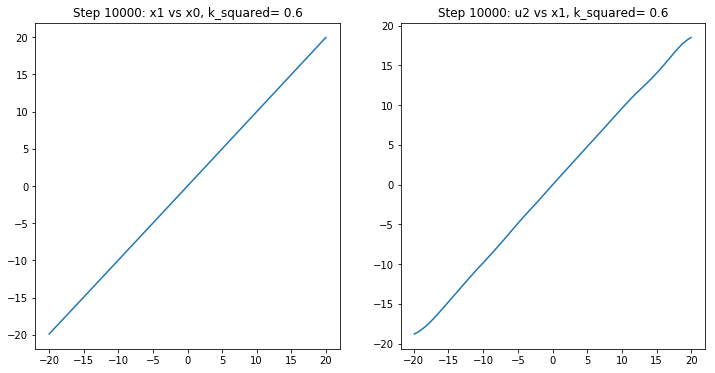

-----Step: 11000
--------Train Cost: 0.9783778786659241 Train Cost Stage1: 0.0004343556356616318 Train Cost Stage2: 0.9779435396194458 
--------Test Cost: 0.9676625103481908 Test Cost_Stage1: 0.00019577958033890224, Test_Cost_Stage2: 0.9674667269581423
--------9.98897409439087 seconds ---


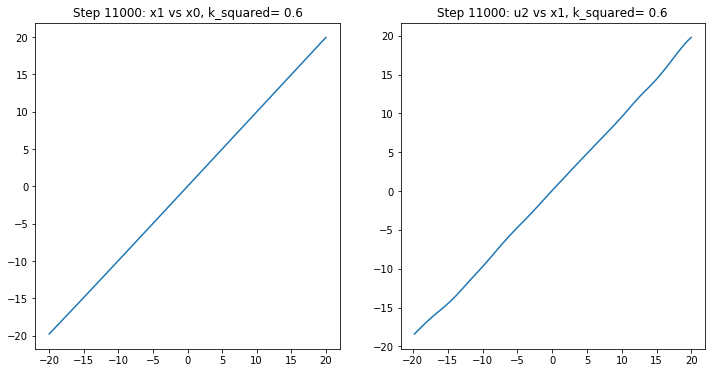

-----Step: 12000
--------Train Cost: 0.9787713885307312 Train Cost Stage1: 0.00017572655633557588 Train Cost Stage2: 0.9785956740379333 
--------Test Cost: 0.9635459169429543 Test Cost_Stage1: 0.00013690213861244948, Test_Cost_Stage2: 0.9634090144303078
--------9.714567184448242 seconds ---


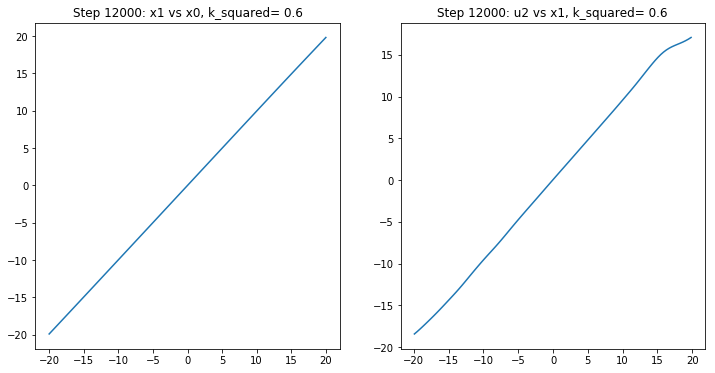

-----Step: 13000
--------Train Cost: 0.9823009371757507 Train Cost Stage1: 6.382122228387743e-05 Train Cost Stage2: 0.9822371006011963 
--------Test Cost: 0.9671399188905431 Test Cost_Stage1: 7.034929309016286e-05, Test_Cost_Stage2: 0.9670695600162208
--------10.228564739227295 seconds ---


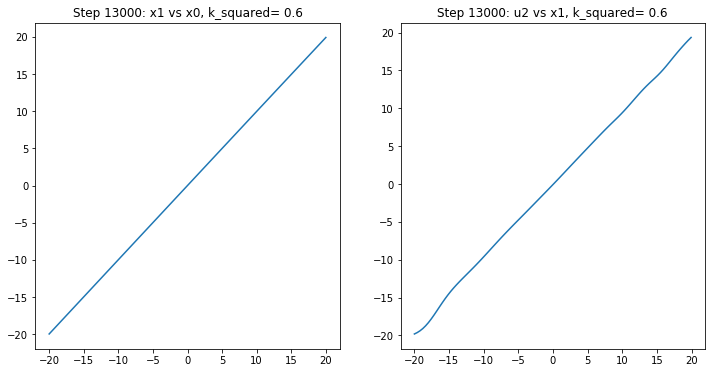

-----Step: 14000
--------Train Cost: 0.9509503245353699 Train Cost Stage1: 0.009450720623135567 Train Cost Stage2: 0.9414995908737183 
--------Test Cost: 0.9741927514857182 Test Cost_Stage1: 0.009977718469832118, Test_Cost_Stage2: 0.9642150347521672
--------9.87101936340332 seconds ---


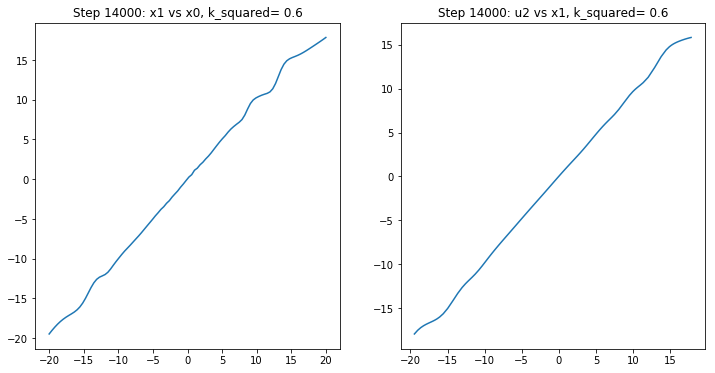

-----Step: 15000
--------Train Cost: 1.0009225606918335 Train Cost Stage1: 0.00439053401350975 Train Cost Stage2: 0.9965320229530334 
--------Test Cost: 0.9666879531518138 Test Cost_Stage1: 0.004743328698123793, Test_Cost_Stage2: 0.961944614399475
--------11.222314596176147 seconds ---


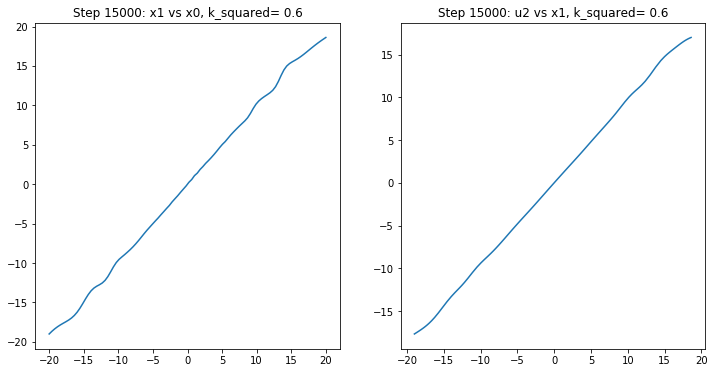

-----Step: 16000
--------Train Cost: 0.9630685448646545 Train Cost Stage1: 0.008566601201891899 Train Cost Stage2: 0.9545019268989563 
--------Test Cost: 0.9717332976270474 Test Cost_Stage1: 0.01024510820331818, Test_Cost_Stage2: 0.9614881983086341
--------9.560723781585693 seconds ---


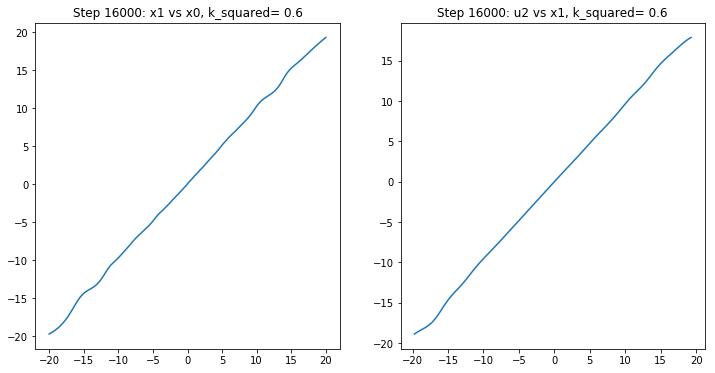

-----Step: 17000
--------Train Cost: 0.9815024137496948 Train Cost Stage1: 0.0016254716319963336 Train Cost Stage2: 0.9798769354820251 
--------Test Cost: 0.9644909519746903 Test Cost_Stage1: 0.0020826614092872837, Test_Cost_Stage2: 0.962408297385533
--------9.864429712295532 seconds ---


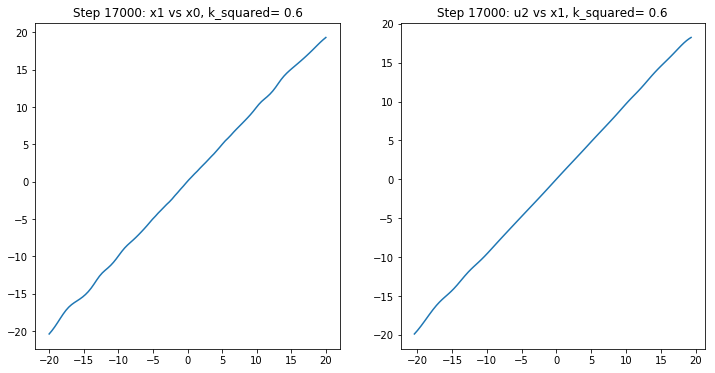

-----Step: 18000
--------Train Cost: 0.9573549628257751 Train Cost Stage1: 0.0031639267690479755 Train Cost Stage2: 0.9541910290718079 
--------Test Cost: 0.9670259444737674 Test Cost_Stage1: 0.004965210101752862, Test_Cost_Stage2: 0.9620607284413365
--------10.549273014068604 seconds ---


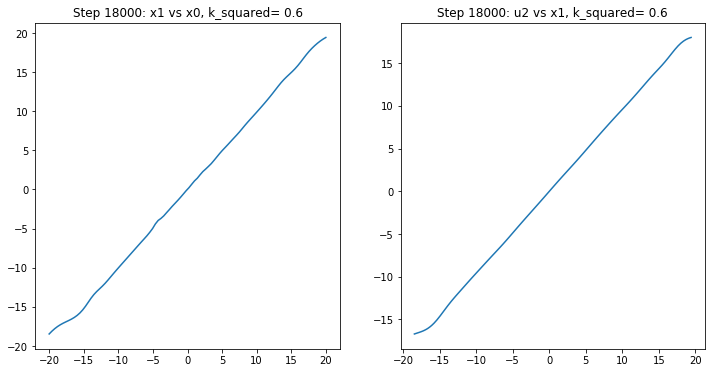

-----Step: 19000
--------Train Cost: 0.9565052390098572 Train Cost Stage1: 0.0015977161237969995 Train Cost Stage2: 0.9549075365066528 
--------Test Cost: 0.9766950235109875 Test Cost_Stage1: 0.0032110143187174304, Test_Cost_Stage2: 0.9734840018004077
--------9.555572986602783 seconds ---


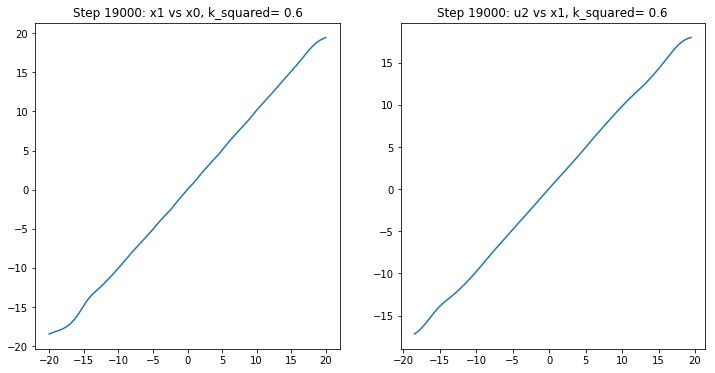

-----Step: 20000
--------Train Cost: 0.989774227142334 Train Cost Stage1: 0.019612716510891914 Train Cost Stage2: 0.970161497592926 
--------Test Cost: 0.9894037195471456 Test Cost_Stage1: 0.027353241773820876, Test_Cost_Stage2: 0.9620504981005028
--------10.176612377166748 seconds ---


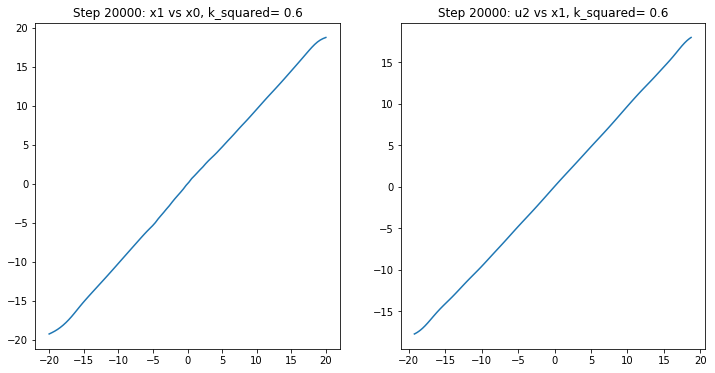

-----Step: 21000
--------Train Cost: 0.9774659276008606 Train Cost Stage1: 0.006876918952912092 Train Cost Stage2: 0.9705889821052551 
--------Test Cost: 0.9744265654711188 Test Cost_Stage1: 0.0069509943015284605, Test_Cost_Stage2: 0.9674755599674217
--------9.69791316986084 seconds ---


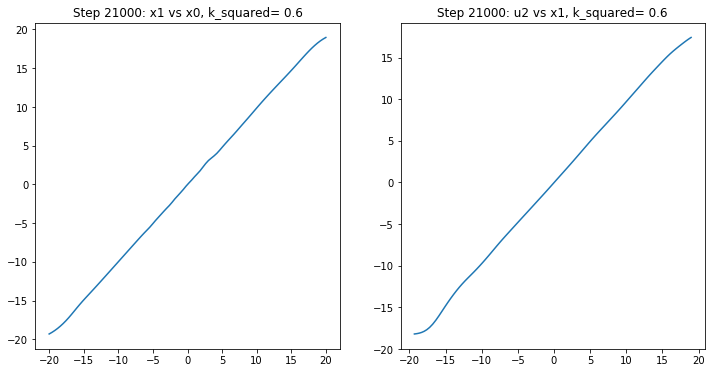

-----Step: 22000
--------Train Cost: 0.9614002108573914 Train Cost Stage1: 0.0071409279480576515 Train Cost Stage2: 0.9542592763900757 
--------Test Cost: 0.9736999514631973 Test Cost_Stage1: 0.0035093087246265793, Test_Cost_Stage2: 0.970190634839505
--------10.33376693725586 seconds ---


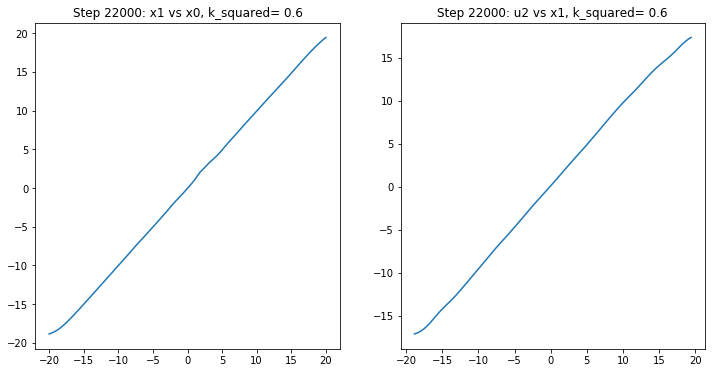

-----Step: 23000
--------Train Cost: 0.9691193103790283 Train Cost Stage1: 0.001529744011349976 Train Cost Stage2: 0.9675895571708679 
--------Test Cost: 0.9690350542798816 Test Cost_Stage1: 0.0025494538040055094, Test_Cost_Stage2: 0.9664856324701923
--------11.111557960510254 seconds ---


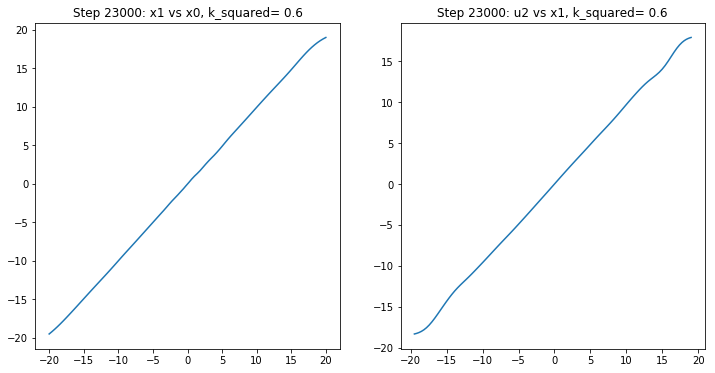

-----Step: 24000
--------Train Cost: 0.9520353674888611 Train Cost Stage1: 0.0022676049266010523 Train Cost Stage2: 0.9497677683830261 
--------Test Cost: 0.9704786780206907 Test Cost_Stage1: 0.0005919274759717175, Test_Cost_Stage2: 0.9698867580229158
--------10.221825361251831 seconds ---


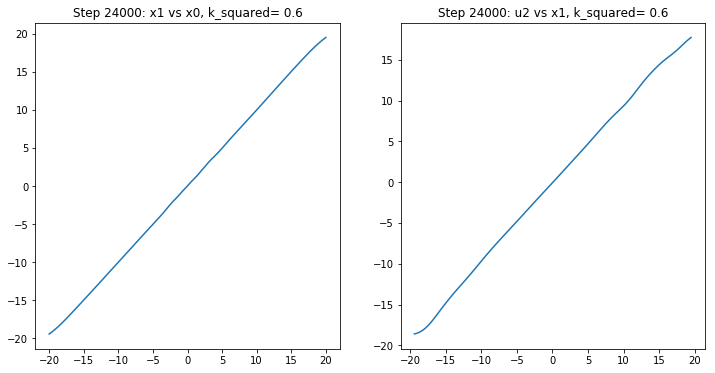

-----Step: 25000
--------Train Cost: 0.9821961522102356 Train Cost Stage1: 0.0008080514962784946 Train Cost Stage2: 0.9813880920410156 
--------Test Cost: 0.9688122384706023 Test Cost_Stage1: 0.002995817129671363, Test_Cost_Stage2: 0.9658164393206319
--------9.692232847213745 seconds ---


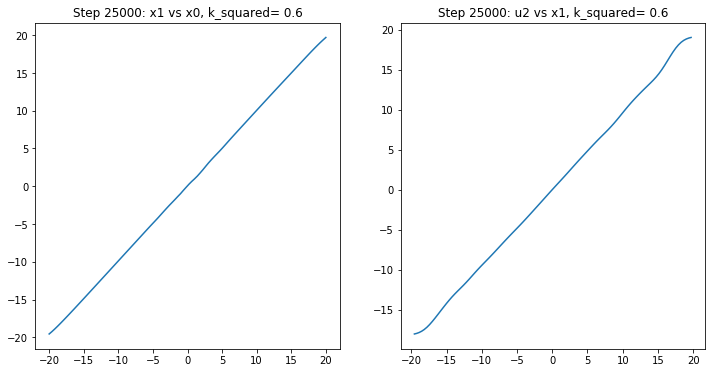

-----Step: 26000
--------Train Cost: 0.9735369086265564 Train Cost Stage1: 0.0005453481571748853 Train Cost Stage2: 0.9729915857315063 
--------Test Cost: 0.9696320431344349 Test Cost_Stage1: 0.0007243419393903981, Test_Cost_Stage2: 0.9689076978844252
--------10.361729621887207 seconds ---


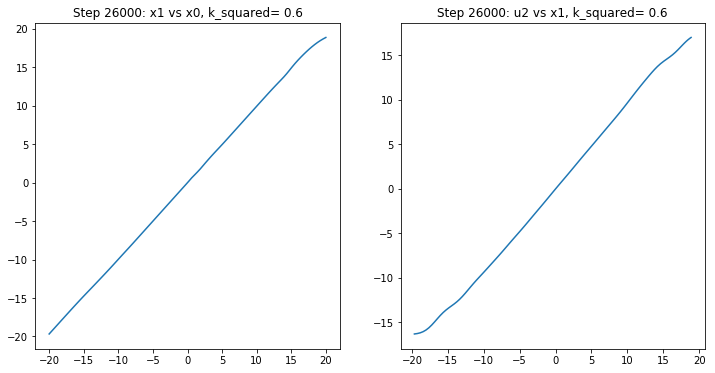

-----Step: 27000
--------Train Cost: 0.9854106903076172 Train Cost Stage1: 0.0009757316438481212 Train Cost Stage2: 0.984434962272644 
--------Test Cost: 0.9653282166659894 Test Cost_Stage1: 0.0005581137136240448, Test_Cost_Stage2: 0.964770101785288
--------10.006754875183105 seconds ---


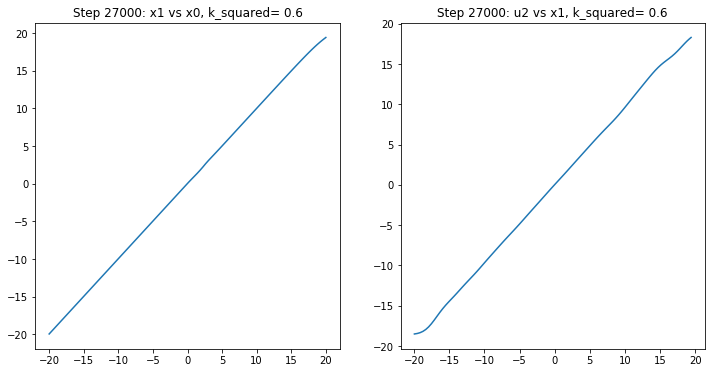

-----Step: 28000
--------Train Cost: 0.9796826839447021 Train Cost Stage1: 0.0005853040493093431 Train Cost Stage2: 0.9790973663330078 
--------Test Cost: 0.9640938544684028 Test Cost_Stage1: 0.0005621758975635562, Test_Cost_Stage2: 0.9635316581776378
--------10.1027512550354 seconds ---


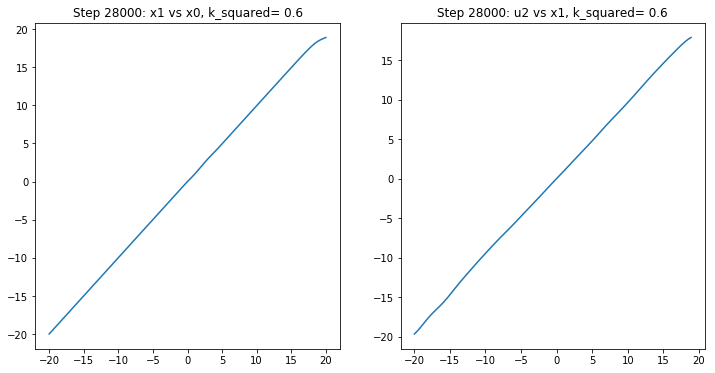

-----Step: 29000
--------Train Cost: 1.00780189037323 Train Cost Stage1: 0.00030606845393776894 Train Cost Stage2: 1.0074958801269531 
--------Test Cost: 0.9669969648133905 Test Cost_Stage1: 0.00044716576144286624, Test_Cost_Stage2: 0.9665497840581269
--------10.059174299240112 seconds ---


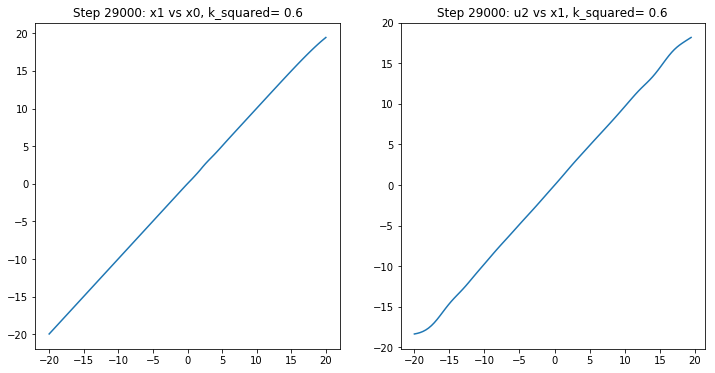

-----Step: 30000
--------Train Cost: 0.9889344573020935 Train Cost Stage1: 0.00014549268234986812 Train Cost Stage2: 0.9887889623641968 
--------Test Cost: 0.9643717416137187 Test Cost_Stage1: 0.00011619550182488671, Test_Cost_Stage2: 0.9642555502220065
--------10.48256230354309 seconds ---


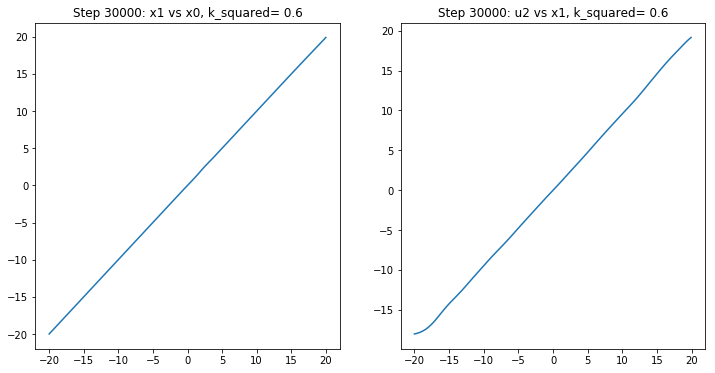

-----Step: 31000
--------Train Cost: 0.9718064069747925 Train Cost Stage1: 0.0004528768185991794 Train Cost Stage2: 0.9713535308837891 
--------Test Cost: 0.967768933140559 Test Cost_Stage1: 0.00047297467604624104, Test_Cost_Stage2: 0.9672959511868588
--------10.245263814926147 seconds ---


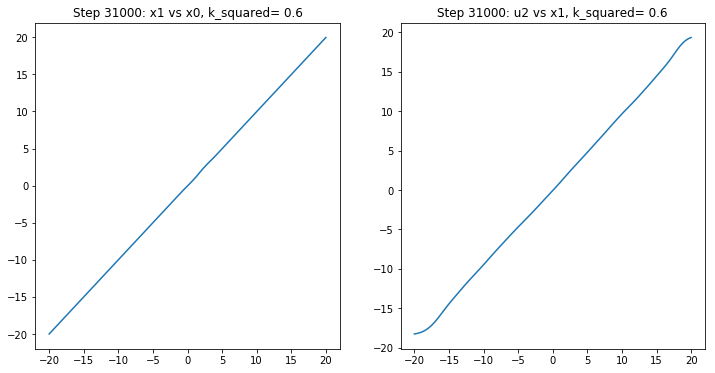

-----Step: 32000
--------Train Cost: 0.9755775928497314 Train Cost Stage1: 0.0009570276015438139 Train Cost Stage2: 0.9746205806732178 
--------Test Cost: 0.9734723676568173 Test Cost_Stage1: 0.0007457477961204843, Test_Cost_Stage2: 0.9727266120164928
--------10.14061164855957 seconds ---


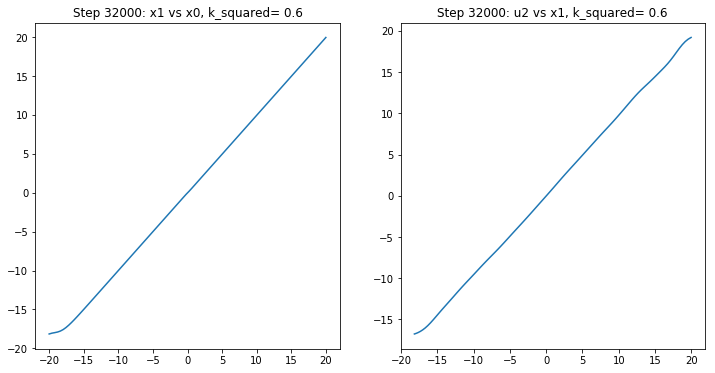

-----Step: 33000
--------Train Cost: 0.992239773273468 Train Cost Stage1: 0.0006202278891578317 Train Cost Stage2: 0.9916195273399353 
--------Test Cost: 0.9677748815037431 Test Cost_Stage1: 0.00024989476575024074, Test_Cost_Stage2: 0.9675250093431028
--------10.242199659347534 seconds ---


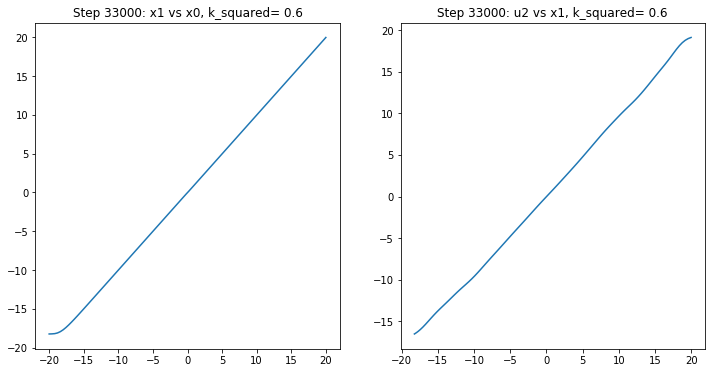

-----Step: 34000
--------Train Cost: 0.9753702282905579 Train Cost Stage1: 0.0005635072011500597 Train Cost Stage2: 0.9748067259788513 
--------Test Cost: 0.9668496841048119 Test Cost_Stage1: 0.0001960976262084407, Test_Cost_Stage2: 0.9666535972103883
--------9.867934942245483 seconds ---


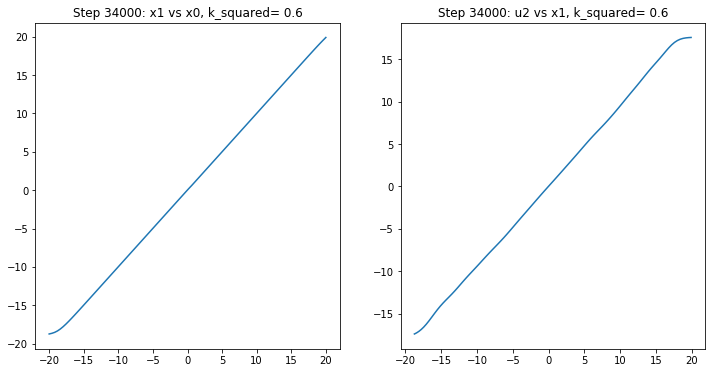

-----Step: 35000
--------Train Cost: 0.975170910358429 Train Cost Stage1: 0.0008585875621065497 Train Cost Stage2: 0.9743123054504395 
--------Test Cost: 0.9733586472734027 Test Cost_Stage1: 0.0007160373898668238, Test_Cost_Stage2: 0.9726426154443493
--------9.721327543258667 seconds ---


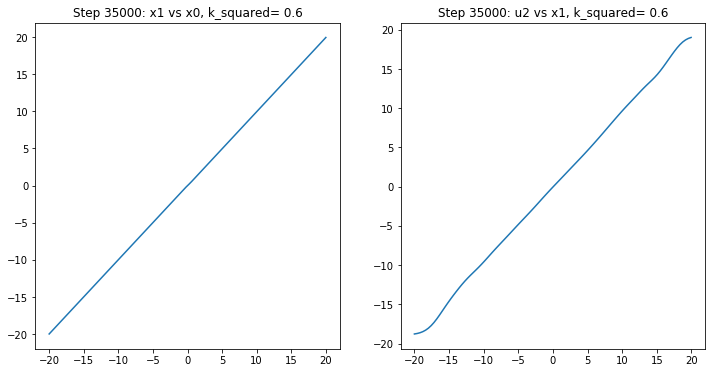

-----Step: 36000
--------Train Cost: 0.9589361548423767 Train Cost Stage1: 0.00011469612218206748 Train Cost Stage2: 0.9588214755058289 
--------Test Cost: 0.9697505722840735 Test Cost_Stage1: 0.0007627091631608265, Test_Cost_Stage2: 0.9689878722667169
--------10.507256984710693 seconds ---


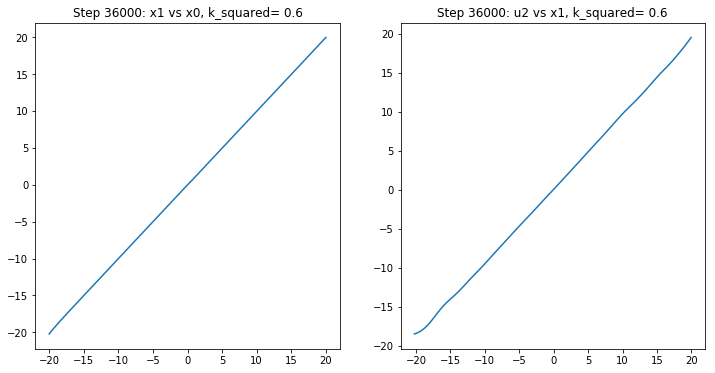

-----Step: 37000
--------Train Cost: 0.9802452921867371 Train Cost Stage1: 0.00028346735052764416 Train Cost Stage2: 0.9799618124961853 
--------Test Cost: 0.9705350317520639 Test Cost_Stage1: 0.0003567172870371547, Test_Cost_Stage2: 0.9701783196056307
--------9.90428376197815 seconds ---


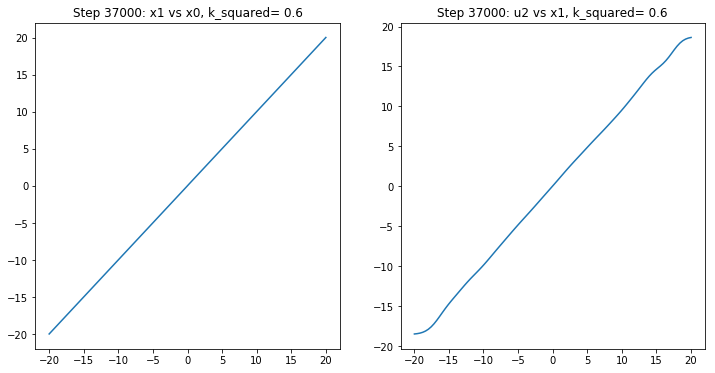

-----Step: 38000
--------Train Cost: 0.963202714920044 Train Cost Stage1: 0.0004716476541943848 Train Cost Stage2: 0.9627310633659363 
--------Test Cost: 0.9651223057442044 Test Cost_Stage1: 0.00036090618263866247, Test_Cost_Stage2: 0.9647614077688177
--------9.68361234664917 seconds ---


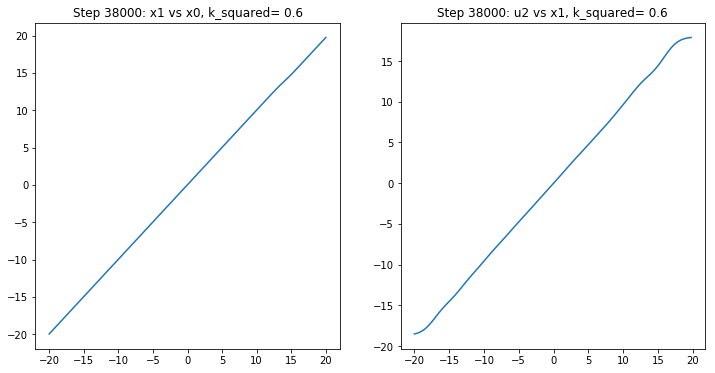

-----Step: 39000
--------Train Cost: 0.9662691354751587 Train Cost Stage1: 5.369902282836847e-05 Train Cost Stage2: 0.9662154316902161 
--------Test Cost: 0.9681218509066524 Test Cost_Stage1: 1.9719054091547226e-05, Test_Cost_Stage2: 0.9681021152361914
--------9.936892986297607 seconds ---


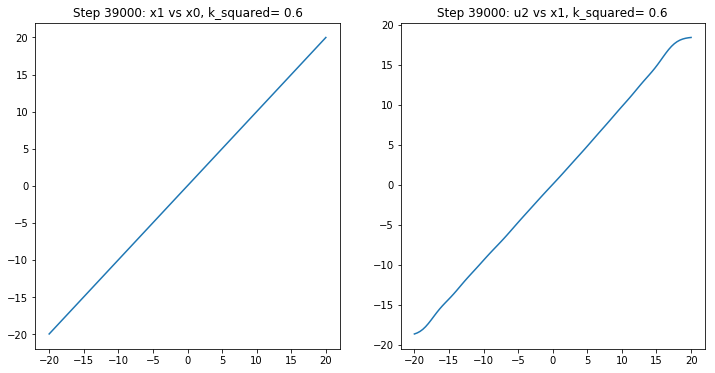

-----Step: 40000
--------Train Cost: 0.9949156045913696 Train Cost Stage1: 0.000332776689901948 Train Cost Stage2: 0.9945828318595886 
--------Test Cost: 0.9693611805744481 Test Cost_Stage1: 0.0002739453820421069, Test_Cost_Stage2: 0.9690872245173608
--------9.582568407058716 seconds ---


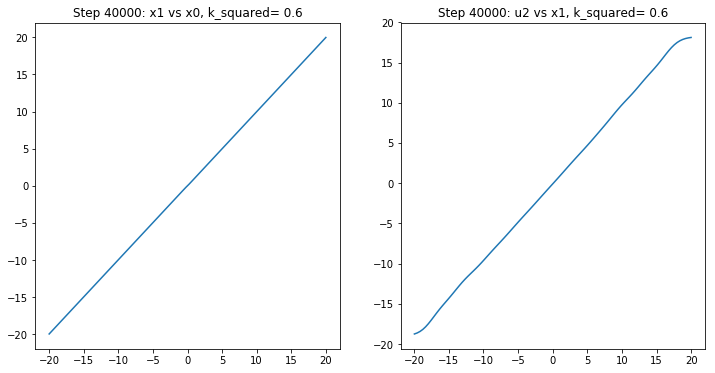

-----Step: 41000
--------Train Cost: 0.9778453707695007 Train Cost Stage1: 0.0003150372067466378 Train Cost Stage2: 0.9775303602218628 
--------Test Cost: 0.9696542329265451 Test Cost_Stage1: 0.0006540402046465355, Test_Cost_Stage2: 0.9690002005351278
--------10.567540645599365 seconds ---


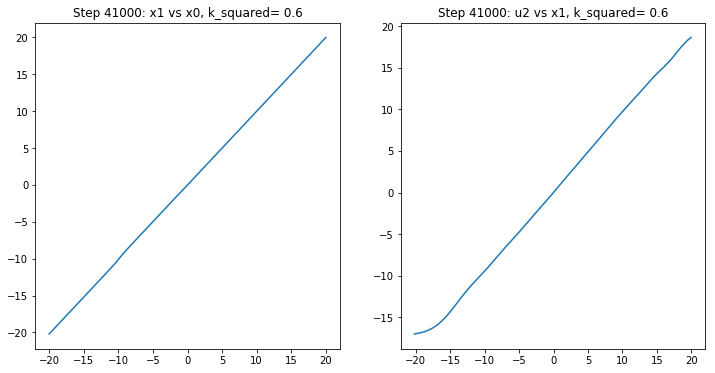

-----Step: 42000
--------Train Cost: 0.959469199180603 Train Cost Stage1: 0.0010720199206843972 Train Cost Stage2: 0.9583971500396729 
--------Test Cost: 0.9712550264215636 Test Cost_Stage1: 0.0013865557400611081, Test_Cost_Stage2: 0.9698684636518874
--------9.560247898101807 seconds ---


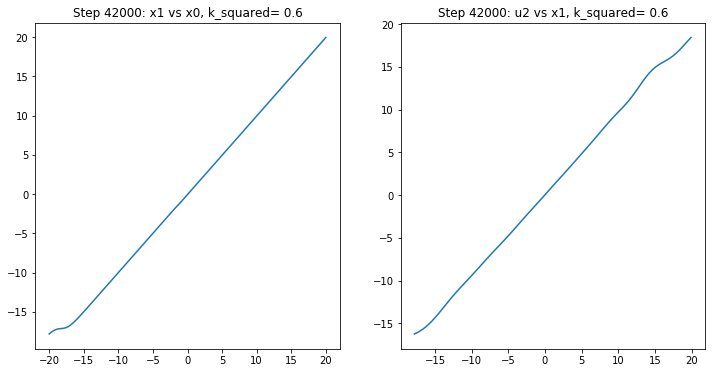

-----Step: 43000
--------Train Cost: 0.9484755992889404 Train Cost Stage1: 0.0003635631292127073 Train Cost Stage2: 0.9481120109558105 
--------Test Cost: 0.978879750477336 Test Cost_Stage1: 0.0011827432679118804, Test_Cost_Stage2: 0.9776969885179547
--------10.161494016647339 seconds ---


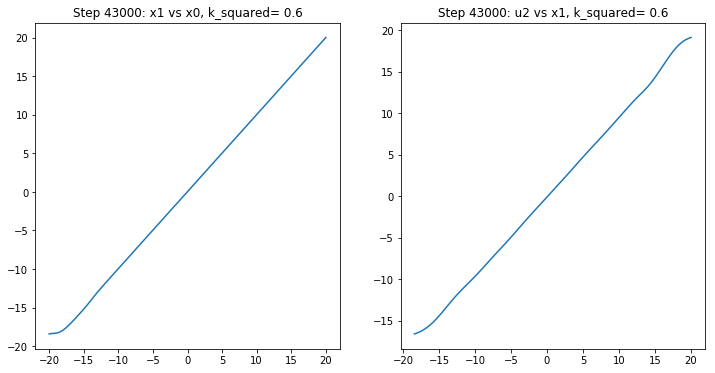

-----Step: 44000
--------Train Cost: 0.9807658195495605 Train Cost Stage1: 0.0006926227943040431 Train Cost Stage2: 0.9800732135772705 
--------Test Cost: 0.9680312374018968 Test Cost_Stage1: 0.0004685200476629787, Test_Cost_Stage2: 0.9675627142970329
--------10.156698226928711 seconds ---


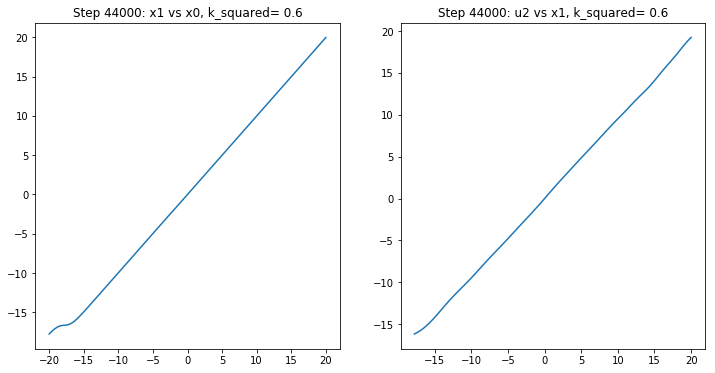

-----Step: 45000
--------Train Cost: 0.9476696848869324 Train Cost Stage1: 0.0007899916381575167 Train Cost Stage2: 0.9468796849250793 
--------Test Cost: 0.9662900637040757 Test Cost_Stage1: 0.0003586758172727985, Test_Cost_Stage2: 0.965931392230093
--------10.107243776321411 seconds ---


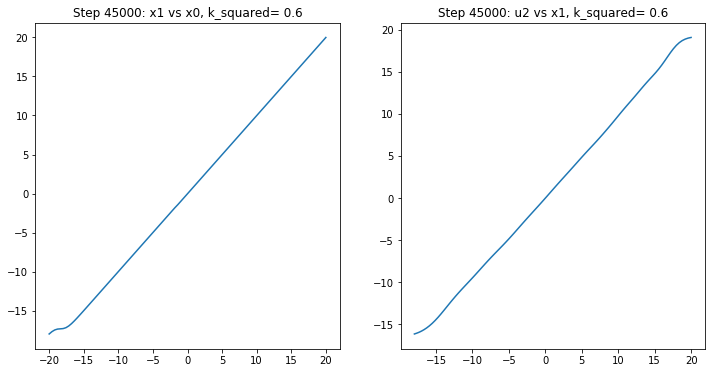

-----Step: 46000
--------Train Cost: 0.9754869937896729 Train Cost Stage1: 0.00024262764782179147 Train Cost Stage2: 0.9752443432807922 
--------Test Cost: 0.9655623081770888 Test Cost_Stage1: 0.00035977712160571154, Test_Cost_Stage2: 0.965202534945719
--------10.224234819412231 seconds ---


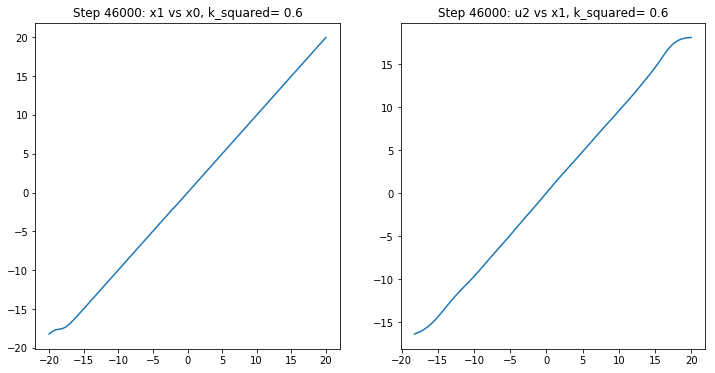

-----Step: 47000
--------Train Cost: 0.9525843858718872 Train Cost Stage1: 0.0008519626571796834 Train Cost Stage2: 0.9517323970794678 
--------Test Cost: 0.9652571428066341 Test Cost_Stage1: 0.000573142539810367, Test_Cost_Stage2: 0.9646839846325825
--------9.881549596786499 seconds ---


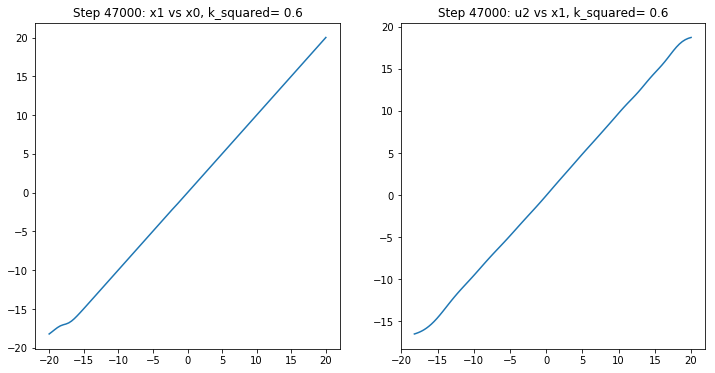

-----Step: 48000
--------Train Cost: 0.9829374551773071 Train Cost Stage1: 0.0006113386480137706 Train Cost Stage2: 0.982326090335846 
--------Test Cost: 0.9728719918027938 Test Cost_Stage1: 0.00021664685628226837, Test_Cost_Stage2: 0.972655328225536
--------9.554096698760986 seconds ---


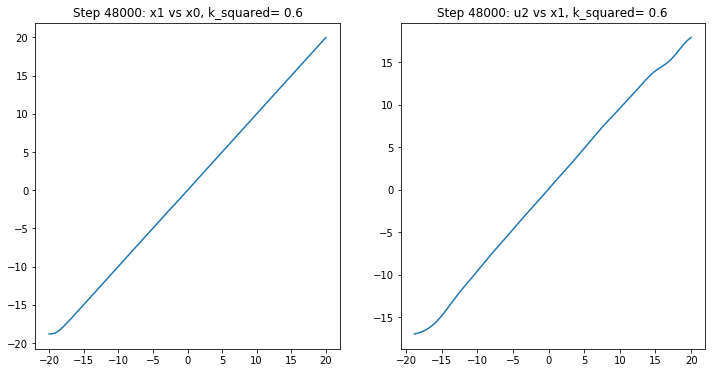

-----Step: 49000
--------Train Cost: 0.9961563348770142 Train Cost Stage1: 0.00025303784059360623 Train Cost Stage2: 0.9959033131599426 
--------Test Cost: 0.9646568254751424 Test Cost_Stage1: 0.0009968879900301804, Test_Cost_Stage2: 0.963659925705948
--------10.473504066467285 seconds ---


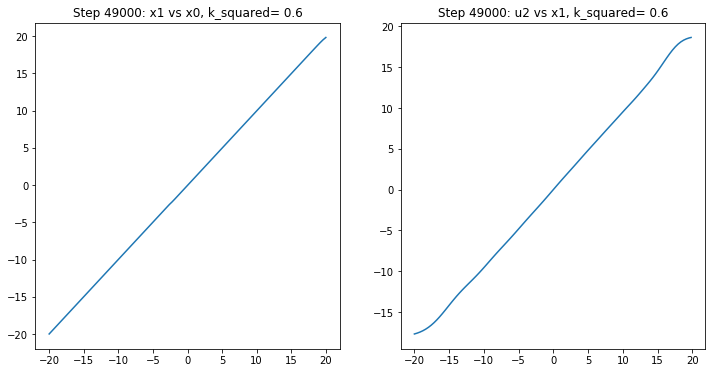

-----Step: 50000
--------Train Cost: 0.976205050945282 Train Cost Stage1: 0.0011639319127425551 Train Cost Stage2: 0.9750410914421082 
--------Test Cost: 0.9687050016681156 Test Cost_Stage1: 0.00043964924723390085, Test_Cost_Stage2: 0.9682653409921195
--------9.89750862121582 seconds ---


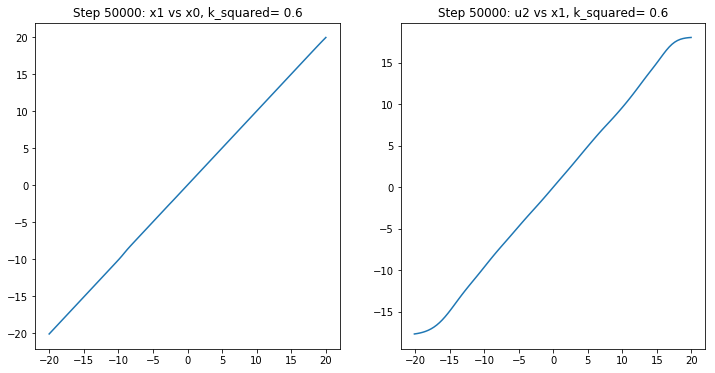

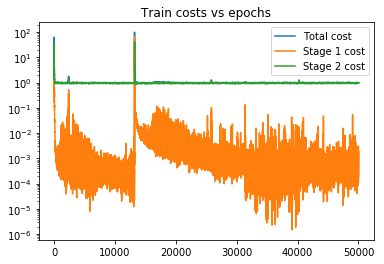

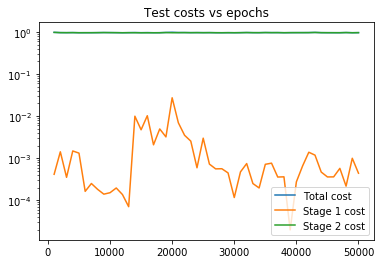

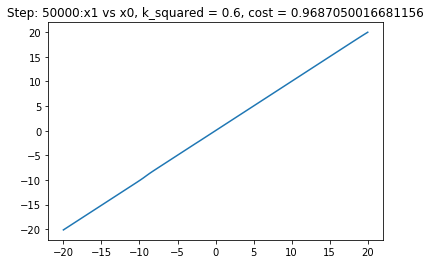

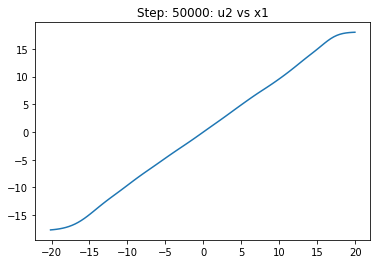

In [8]:
##################
#Main Loop
##################
# hyperparam_results_list = []
m = 1
for k,tup in enumerate((hyperparam_tuples)):
     
    layer_structure = tup[0]
    k_squared = tup[1]
    learning_rate = tup[2]
    learning_rate_decay = tup[3]
    max_epoch = tup[4]
    batch_size = tup[5]
    sigma_x0 = tup[6]
    sigma_z = tup[7]
    optimizer_function = tup[8]
    k_ramp_time_factor = tup[9]
    z1d = np.linspace(-MAXSTDREP*sigma_z, MAXSTDREP*sigma_z, num=NUMPOINTSZ)
    x1d = np.linspace(-MAXSTDREP*sigma_x0, MAXSTDREP*sigma_x0, num=NUMPOINTSX0)
    

    #WARNING: ONLY FOR m = 2
    

    if m == 1:
        z_grid = np.array(list(cartesian_product(z1d)))
        x_grid = np.array(list(cartesian_product(x1d)))

    if m == 2:
        z_grid = np.array(list(cartesian_product(z1d,z1d)))
        x_grid = np.array(list(cartesian_product(x1d,x1d)))

#  
        
    z_distribution = scipy.stats.norm(loc = 0.*np.ones(m), scale = np.ones(m)*sigma_z)
    z_density = np.product(z_distribution.pdf(z_grid), axis = 1)

    x_distribution = scipy.stats.norm(loc = 0.*np.ones(m), scale = np.ones(m)*sigma_x0)
    x_density = np.product(x_distribution.pdf(x_grid), axis = 1)
    
    
    
    xz_grid = np.array(list(cartesian_product(list(x_grid), list(z_grid))))

                
    tup_str = hyperparam_tuples_str[k]
    params = {'k_ramp_time_factor': k_ramp_time_factor, 'xz_grid':xz_grid, 'x0_grid':x_grid, 'z_density':z_density, 'x_density':x_density, 'z_grid':z_grid,'m':m, 'mini_batch_size':batch_size, 'batch_size':batch_size, 'sigma_x0':sigma_x0, 'sigma_z':sigma_z,\
              'optimizer_function':optimizer_function, 'learning_rate':learning_rate, 'max_epochs':max_epoch,\
              'learning_rate_decay':learning_rate_decay, 'layer_structures':layer_structure , 'k_squared':k_squared}
    
    print(tup_str)
    
    train_costs, train_costs_stage1, train_costs_stage2, test_costs, test_costs_stage1, test_costs_stage2,test_x1s,\
    test_x2s, test_u2s= neural_net(param_string= tup_str, params=params, m=m, verbose = True)   
    
#     ##########Print final results



    #Cost curves

    #Training costs
    plt.plot(train_costs, label = 'Total cost')
    plt.plot(train_costs_stage1, label = 'Stage 1 cost')
    plt.plot(train_costs_stage2, label = 'Stage 2 cost')
    plt.legend(loc = 'best')
    plt.title('Train costs vs epochs')
    plt.yscale('log')
    plt.show()


    #Test costs


    test_costs = np.array(test_costs)
    test_costs_stage1 = np.array(test_costs_stage1)
    test_costs_stage2 = np.array(test_costs_stage2)


    plt.plot(test_costs[:,0], test_costs[:,1], label = 'Total cost')
    plt.plot(test_costs_stage1[:,0], test_costs_stage1[:,1], label = 'Stage 1 cost')
    plt.plot(test_costs_stage2[:,0], test_costs_stage2[:,1], label = 'Stage 2 cost')
    plt.legend(loc = 'best')
    plt.title('Test costs vs epochs')
    plt.yscale('log')
    plt.show()



    #Final x0 vs x1

    plt.plot(x_grid, test_x1s[-1][1])
    title_string = 'x1 vs x0, k_squared = ' + str(k_squared) 
    plt.title('Step: ' + str(test_x1s[-1][0]) + ':' + title_string  + ', cost = ' + str(test_costs[-1,1]))
    filename = FIGURESPATH + '/uniform_' + title_string + '.png'
    plt.savefig(filename, format = 'png')
    plt.show()





    #Final u2 vs x1

    plt.plot(test_x1s[-1][1], test_u2s[-1][1])
    plt.title('Step: ' + str(test_x1s[-1][0]) + ': u2 vs x1')
    plt.show()